In [156]:
# General
import sys
import os.path as op
from time import time
from collections import OrderedDict as od
from glob import glob
import itertools
import warnings
from importlib import reload
from cluster_helper.cluster import cluster_view

# Scientific
import numpy as np
import pandas as pd
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

# Stats
import statsmodels.api as sm
from sklearn.utils.fixes import loguniform
import scipy.stats as stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale, StandardScaler
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

# Plots
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.patches as patches
# from mpl_toolkits.mplot3d import Axes3D
mpl.rcParams['grid.linewidth'] = 0.1
mpl.rcParams['grid.alpha'] = 0.75
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.markersize'] = 3
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.major.width'] = 0.8
mpl.rcParams['ytick.major.width'] = 0.8
colors = ['1f77b4', 'd62728', '2ca02c', 'ff7f0e', '9467bd', 
          '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
mpl.rcParams['axes.prop_cycle'] = mpl.cycler('color', colors)
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.formatter.offset_threshold'] = 2
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.labelpad'] = 8
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['legend.loc'] = 'upper right'
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['figure.figsize'] = (10, 4) 
mpl.rcParams['figure.subplot.wspace'] = 0.25 
mpl.rcParams['figure.subplot.hspace'] = 0.25 
mpl.rcParams['font.sans-serif'] = ['Helvetica']
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['pdf.fonttype'] = 42

# Personal
sys.path.append('/home1/dscho/code/general')
sys.path.append('/home1/dscho/code/projects/manning_replication')
sys.path.append('/home1/dscho/code/projects')
import data_io as dio
import array_operations as aop
from helper_funcs import *
from eeg_plotting import plot_trace, plot_trace2
from time_cells import spike_sorting, spike_preproc, events_preproc, events_proc, time_bin_analysis, pop_decoding

font = {'tick': 12,
        'label': 14,
        'annot': 12,
        'fig': 16}

# Colors
n = 4
c = 2
colors = [sns.color_palette('Blues', n)[c], 
          sns.color_palette('Reds', n)[c], 
          sns.color_palette('Greens', n)[c],
          sns.color_palette('Purples', n)[c],
          sns.color_palette('Oranges', n)[c],
          sns.color_palette('Greys', n)[c],
          sns.color_palette('YlOrBr', n+3)[c],
          'k']
cmap = sns.palettes.blend_palette((colors[0], 
                                   'w',
                                   colors[1]), 501)

colws = od([('1', 6.55),
            ('2-1/2', 3.15),
            ('2-1/3', 2.1),
            ('2-2/3', 4.2),
            ('3', 2.083),
            ('4', 1.525),
            ('5', 1.19),
            ('6', 0.967),
            (1, 2.05),
            (2, 3.125),
            (3, 6.45),
            ('nat1w', 3.50394),
            ('nat2w', 7.20472),
            ('natl', 9.72441)])

proj_dir = '/home1/dscho/projects/time_cells'

In [157]:
# Get sessions.
sessions = np.unique([op.basename(f).split('-')[0] 
                      for f in glob(op.join(proj_dir, 'analysis', 'events', '*-Events.pkl'))])
print('{} subjects, {} sessions'.format(len(np.unique([x.split('_')[0] for x in sessions])), len(sessions)))

10 subjects, 12 sessions


In [158]:
# Get spike counts in each time bin, for all neurons in the study.
pop_spikes = pop_decoding.load_pop_spikes()

print(pop_spikes)

457 neurons
500 ms time bins
36 trials
160 time bins/trial
pop_spikes: (5760, 460)


In [159]:
def sort_onto(sort_on, 
              apply_to, 
              n_split=None):
    """Sort the values within each split of sort_on.
    
    Apply the sorting indices to apply_to."""
    # Split the input vectors.
    if (len(np.array(apply_to).shape) == 1) & (n_split is None):
        n_split = 1
    if n_split is not None:
        sort_on = np.split(np.ravel(sort_on), n_split)
        apply_to = np.split(np.array(apply_to), n_split)
    
    # Sort each row.
    apply_to = np.array(apply_to)
    assert len(apply_to.shape) == 2
    sort_idx = np.argsort(sort_on, axis=-1)
    apply_to = np.squeeze([apply_to[ii, sort_idx[ii, :]]
                           for ii in range(sort_idx.shape[0])])
    return apply_to


def clf_error(y_test, y_test_pred, mult=1):
    """Return the difference between predicted and actual values."""
    return [int(x) for x in ((np.array(y_test_pred) - np.array(y_test)) * mult)]

# Delay1, Delay2: only time cells

In [13]:
game_states = ['Delay1', 'Delay2']
n_units = 115
unit_group = 'timeAll'
gs_steps = {'Delay1': 5, 'Delay2': 5, 'Encoding': 15, 'Retrieval': 15}

filename = op.join(proj_dir, 'analysis', 'classifiers',
                   'SVC_predicting_time_step-{}units_{}-random_search-36fold-Delay1_{}bins-Delay2_{}bins.pkl'
                   .format(n_units, unit_group, gs_steps['Delay1'], gs_steps['Delay2']))
clf_results = dio.open_pickle(filename)

xfilename = op.join(proj_dir, 'analysis', 'classifiers',
                    'SVC_predicting_time_step-{}units_{}-random_search-36fold-cross_decoding-Delay1_{}bins-Delay2_{}bins.pkl'
                    .format(n_units, unit_group, gs_steps['Delay1'], gs_steps['Delay2']))
xclf_results = dio.open_pickle(xfilename)

# --------------------------
# Resort y_test_null and y_test_pred_null on the values within each y_test_null test trial.
for _df in (clf_results, xclf_results):
    for col in ['accuracy_null', 'acc_by_time_null', 'y_test_pred_null', 'y_test_null']:
        _df[col] = _df.apply(lambda x: sort_onto(x['y_test_null'], x[col], len(x['test_trials'])), axis=1)
        
# Drop columns that we don't need.
drop_cols = ['mean_acc', 'acc_by_time', 'accuracy', 'clf',
             'mean_acc_null', 'acc_by_time_null', 'accuracy_null', 'clf_null']
for _df in (clf_results, xclf_results):
    _drop_cols = [col for col in drop_cols if col in _df.columns]
    if len(_drop_cols) > 0:
        _df.drop(columns=_drop_cols, inplace=True)

# Alias gameState in the cross-decoding dataframe.
xclf_results['gameState'] = xclf_results['gameState_test']

# Calculate performance metrics.
for _df in (clf_results, xclf_results):
    _df['recall'] = _df.apply(lambda x: metrics.recall_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
    _df['precision'] = _df.apply(lambda x: metrics.precision_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
    _df['f1'] = _df.apply(lambda x: metrics.f1_score(x['y_test'], x['y_test_pred'], average=None).tolist(), axis=1)
    _df['error'] = _df.apply(lambda x: clf_error(x['y_test'], x['y_test_pred']), axis=1)
    _df['abs_error'] = _df.apply(lambda x: np.abs(x['error']).tolist(), axis=1)
    _df['corr'] = _df.apply(lambda x: stats.pearsonr(x['y_test_pred'], x['y_test'])[0], axis=1).fillna(0)
    
    _df['recall_null'] = _df.apply(lambda x: metrics.recall_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
    _df['precision_null'] = _df.apply(lambda x: metrics.precision_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
    _df['f1_null'] = _df.apply(lambda x: metrics.f1_score(x['y_test_null'], x['y_test_pred_null'], average=None).tolist(), axis=1)
    _df['error_null'] = _df.apply(lambda x: clf_error(x['y_test_null'], x['y_test_pred_null']), axis=1)
    _df['abs_error_null'] = _df.apply(lambda x: np.abs(x['error_null']).tolist(), axis=1)
    _df['corr_null'] = _df.apply(lambda x: stats.pearsonr(x['y_test_pred_null'], x['y_test_null'])[0], axis=1).fillna(0)
    
print(clf_results.shape, xclf_results.shape)

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(72, 26) (72, 21)


Delay1, Delay2
--------------
recall
within-decoding: 0.48 ± 0.026, min = 0.00, max = 1.00
cross-decoding: 0.38 ± 0.023, min = 0.00, max = 0.80
within null: 0.19 ± 0.019, min = 0.00, max = 0.60
cross null: 0.18 ± 0.018, min = 0.00, max = 0.60
within_vs_null: T(71) = 8.9, P = 0.000000, P_holm = 0.000000, reject = True
cross_vs_null: T(71) = 7.2, P = 0.000000, P_holm = 0.000000, reject = True
within_vs_cross: T(71) = 2.7, P = 0.009833, P_holm = 0.009833, reject = True

precision
within-decoding: 0.36 ± 0.027, min = 0.00, max = 1.00
cross-decoding: 0.28 ± 0.020, min = 0.00, max = 0.70
within null: 0.10 ± 0.013, min = 0.00, max = 0.40
cross null: 0.09 ± 0.011, min = 0.00, max = 0.40
within_vs_null: T(71) = 8.5, P = 0.000000, P_holm = 0.000000, reject = True
cross_vs_null: T(71) = 8.1, P = 0.000000, P_holm = 0.000000, reject = True
within_vs_cross: T(71) = 2.4, P = 0.018571, P_holm = 0.018571, reject = True

f1
within-decoding: 0.39 ± 0.027, min = 0.00, max = 1.00
cross-decoding: 0.31 ± 0.0

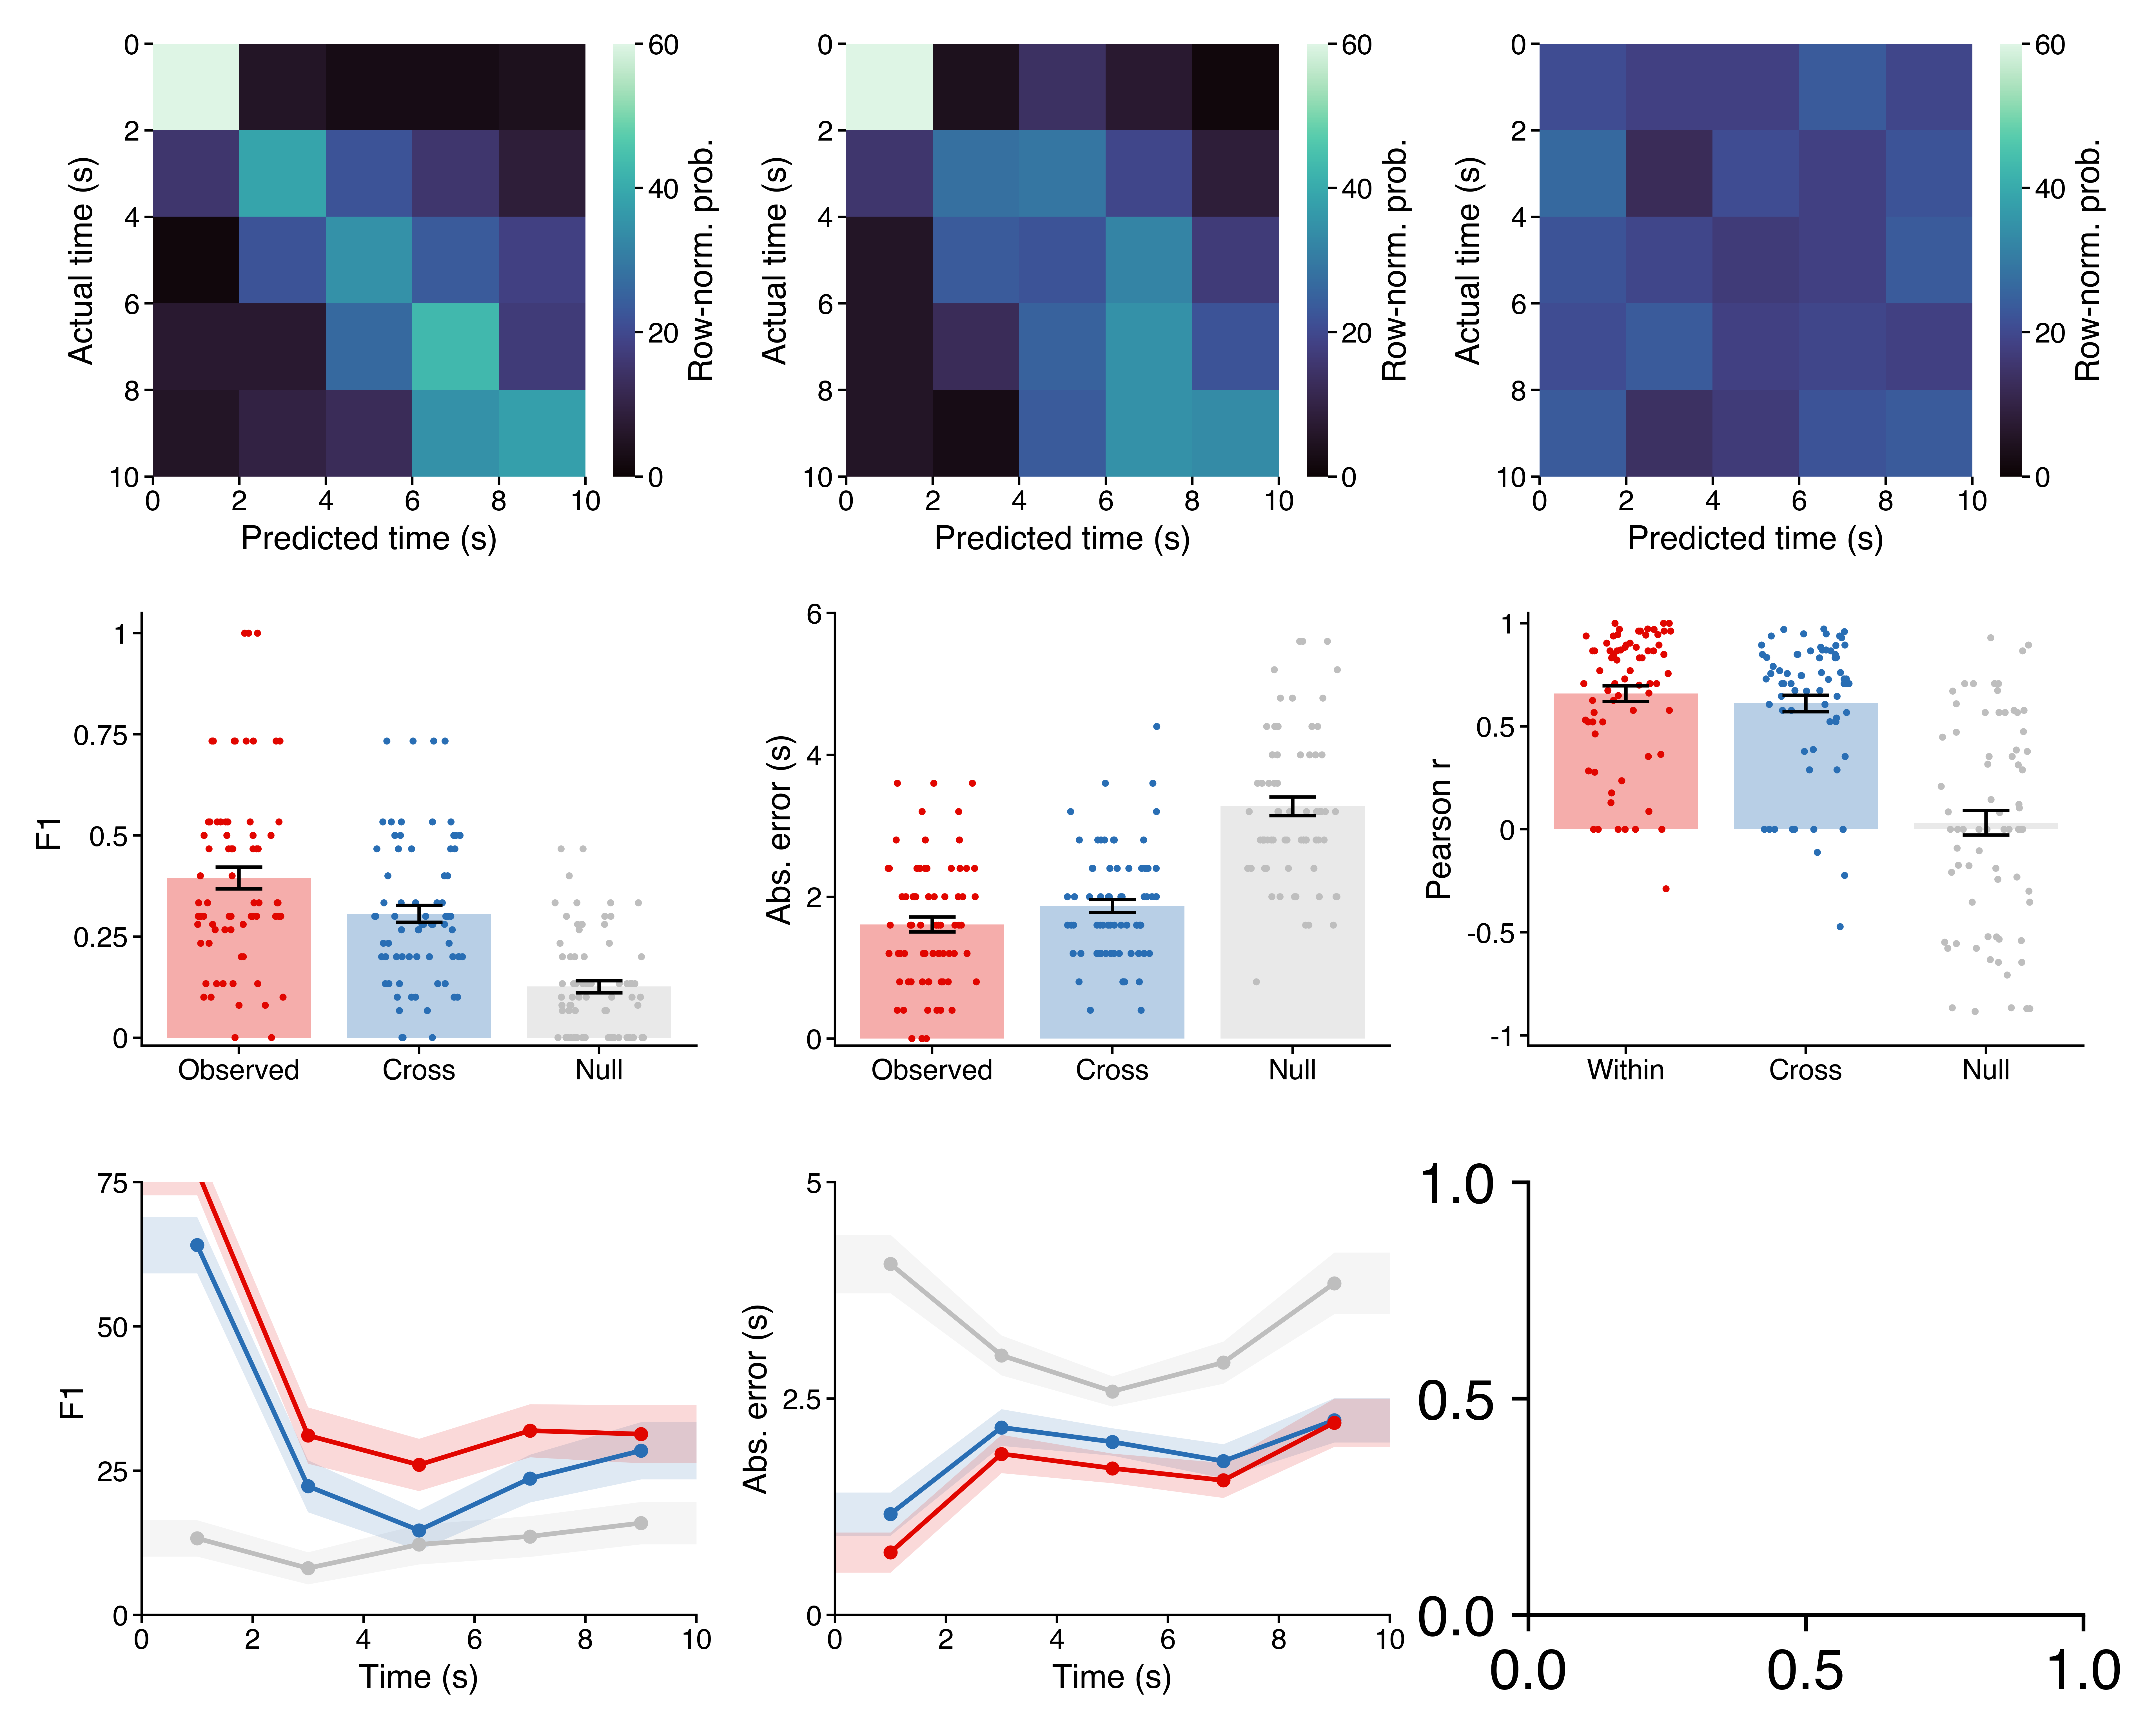

In [14]:
# !!!!!!!!!!!!
savefig = 0
overwrite = 0
verbose = 1
game_states = ['Delay1', 'Delay2']
sep_conf_mats = False
if gs_steps[game_states[0]] == 5:
    ymin_acc = -0.02
    ymax_acc = 1.05
    yticks_acc = [0, .25, .5, .75, 1]
    ymin_acc_time = 0
    ymax_acc_time = 0.75
    yticks_acc_time = [0, .25, .5, .75]
    yerr_mult = 2
    ymin_error = -0.1
    ymax_error = 6
    yticks_error = [0, 2, 4, 6]
    ymin_error_time = 0
    ymax_error_time = 5
    yticks_error_time = [0, 2.5, 5]
    ymin_corr = -1.05
    ymax_corr = 1.05
    yticks_corr = [-1, -0.5, 0, 0.5, 1]
    vmin = 0
    vmax = 60
    cbar_ticks = [0, 20, 40, 60]
elif gs_steps[game_states[0]] == 10:
    ymin_acc = -0.02
    ymax_acc = .45
    yticks_acc = [0, .1, .2, .3, .4]
    ymin_acc_time = 0
    ymax_acc_time = 0.55
    yticks_acc_time = [0, .15, .3, .45]
    yerr_mult = 1
    ymin_error = 0
    ymax_error = 6
    yticks_error = [0, 2, 4, 6]
    ymin_error_time = 0
    ymax_error_time = 6
    yticks_error_time = [0, 2, 4, 6]
    ymin_corr = -1.05
    ymax_corr = 1.05
    yticks_corr = [-1, -0.5, 0, 0.5, 1]
    vmin = 0
    vmax = 50
    cbar_ticks = [0, 20, 40]

figsize = (colws[2]*2, colws[2]*1.6)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
add_cbar = True
plot_decode = True
plot_xdecode = True
plot_null = True
alpha = 0.15
linewidth = 1
ebar_lw = 0.75
fliersize = 1.5
_cmap = 'mako'

# -----------------------------------------
plt.close()
fig, ax = plt.subplots(3, 3, dpi=dpi, figsize=figsize)
ax = np.ravel(ax)
iax = -1

print('{}\n{}'.format(', '.join(game_states), '-' * len(', '.join(game_states))))
clf_dat = clf_results.query("(gameState=={})".format(game_states)).copy()
xclf_dat = xclf_results.query("(gameState=={})".format(game_states)).copy()
clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
n_test = 1

# Run stats.
metric_cols = ['recall', 'precision', 'f1', 'abs_error', 'corr']
for metric_col in metric_cols:
    metric_col_null = '{}_null'.format(metric_col)
    _min = clf_dat[metric_col].apply(np.mean).min()
    _max = clf_dat[metric_col].apply(np.mean).max()
    _mean = clf_dat[metric_col].apply(np.mean).mean()
    _sem = stats.sem(clf_dat[metric_col].apply(np.mean))
    _xmin = xclf_dat[metric_col].apply(np.mean).min()
    _xmax = xclf_dat[metric_col].apply(np.mean).max()
    _xmean = xclf_dat[metric_col].apply(np.mean).mean()
    _xsem = stats.sem(xclf_dat[metric_col].apply(np.mean))
    _min_null = clf_dat[metric_col_null].apply(np.mean).min()
    _max_null = clf_dat[metric_col_null].apply(np.mean).max()
    _mean_null = clf_dat[metric_col_null].apply(np.mean).mean()
    _sem_null = stats.sem(clf_dat[metric_col_null].apply(np.mean))
    _xmin_null = xclf_dat[metric_col_null].apply(np.mean).min()
    _xmax_null = xclf_dat[metric_col_null].apply(np.mean).max()
    _xmean_null = xclf_dat[metric_col_null].apply(np.mean).mean()
    _xsem_null = stats.sem(xclf_dat[metric_col_null].apply(np.mean))
    print(metric_col,
          'within-decoding: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_mean, _sem, _min, _max),
          'cross-decoding: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_xmean, _xsem, _xmin, _xmax),
          'within null: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_mean_null, _sem_null, _min_null, _max_null),
          'cross null: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_xmean_null, _xsem_null, _xmin_null, _xmax_null),
          sep='\n')
    ttests = od([('within_vs_null', stats.ttest_rel(clf_dat[metric_col].apply(np.mean), clf_dat[metric_col_null].apply(np.mean))),
                 ('cross_vs_null', stats.ttest_rel(xclf_dat[metric_col].apply(np.mean), xclf_dat[metric_col_null].apply(np.mean))),
                 ('within_vs_cross', stats.ttest_rel(clf_dat[metric_col].apply(np.mean), xclf_dat[metric_col].apply(np.mean)))
                ])
    dof = len(clf_dat) - 1
    pvals_holm = sm.stats.multipletests([_test[1] for _test in ttests.values()], alpha=0.05, method='holm')
    for iTest, _test in enumerate(ttests):
        ttests[_test] = {'tstat': ttests[_test][0],
                         'pval': ttests[_test][1],
                         'pval_holm': pvals_holm[1][iTest],
                         'sig_holm': pvals_holm[0][iTest]}
        print('{}: T({}) = {:.1f}, P = {:.6f}, P_holm = {:.6f}, reject = {}'
              .format(_test,
                      dof,
                      ttests[_test]['tstat'],
                      ttests[_test]['pval'],
                      ttests[_test]['pval_holm'],
                      ttests[_test]['sig_holm']))
    print('')
    
# Make plots.
if sep_conf_mats:
    for iState, game_state in enumerate(game_states):
        clf_dat = clf_results.query("(gameState=='{}')".format(game_state)).copy()
        xclf_dat = xclf_results.query("(gameState=='{}')".format(game_state)).copy()
        clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
        xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
        clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
        xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
        n_time_steps = clf_dat.iloc[0]['n_time_steps']
        reshp = [n_test, n_time_steps]
        if game_state[:5] == 'Delay':
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]

        # Within-state confusion matrix.
        if plot_decode:
            iax += 1
            cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
            print(cmat.max())
            vmin = vmin
            vmax = vmax
            ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
            ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
            _xticks = xticks
            ax[iax].set_xlim((_xticks.min(), _xticks.max()))
            ax[iax].set_xticks(_xticks)
            ax[iax].set_xticklabels(xticklabels)
            ax[iax].set_yticks(ax[iax].get_xticks())
            ax[iax].set_yticklabels(ax[iax].get_xticklabels())
            ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
            ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
            if add_cbar:
                cbar = ax[iax].collections[0].colorbar
                cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
                cbar.set_ticks(cbar_ticks)
                cbar.set_ticklabels(cbar_ticks)
                cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
            else:
                ax[iax].collections[0].colorbar.remove()

        # Cross-decoder confusion matrix.
        if plot_xdecode:
            iax += 1
            cmat = np.mean(xclf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
            print(cmat.max())
            vmin = vmin
            vmax = vmax
            ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
            ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
            _xticks = xticks
            ax[iax].set_xlim((_xticks.min(), _xticks.max()))
            ax[iax].set_xticks(_xticks)
            ax[iax].set_xticklabels(xticklabels)
            ax[iax].set_yticks(ax[iax].get_xticks())
            ax[iax].set_yticklabels(ax[iax].get_xticklabels())
            ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
            ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
            if add_cbar:
                cbar = ax[iax].collections[0].colorbar
                cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
                cbar.set_ticks(cbar_ticks)
                cbar.set_ticklabels(cbar_ticks)
                cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
            else:
                ax[iax].collections[0].colorbar.remove()

clf_dat = clf_results.query("(gameState=={})".format(game_states)).copy()
xclf_dat = xclf_results.query("(gameState=={})".format(game_states)).copy()
clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))

if not sep_conf_mats:
    # Within-state confusion matrix.
    if plot_decode:
        iax += 1
        cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'],
                                                                normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()

    # Cross-decoder confusion matrix.
    if plot_xdecode:
        iax += 1
        cmat = np.mean(xclf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'],
                                                                 normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()

    # Within-state confusion matrix.
    if plot_decode:
        iax += 1
        cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test_null'], x['y_test_pred_null'],
                                                                normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()
        
# F1.
iax += 1
mean_acc = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['f1'].apply(np.mean).tolist())).T,
                                   np.vstack((['cross'] * len(xclf_dat), xclf_dat['f1'].apply(np.mean).tolist())).T,
                                   np.vstack((['null'] * len(clf_dat), clf_dat['f1_null'].apply(np.mean).tolist())).T)),
                        columns=['level', 'value'])
mean_acc['level'] = mean_acc['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_acc['value'] = mean_acc['value'].astype(float)

sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_acc, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_acc, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_acc['level'].unique().size),
                 mean_acc.groupby('level')['value'].mean().values,
                 yerr=mean_acc.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Observed', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_acc, ymax_acc])
ax[iax].set_yticks(yticks_acc)
ax[iax].set_yticklabels(yticks_acc, fontsize=font['tick'])
ax[iax].set_ylabel('F1', fontsize=font['label'], labelpad=labelpad)
    
# Absolute error.
iax += 1
mean_errors = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['abs_error'].apply(np.mean).tolist())).T,
                                      np.vstack((['cross'] * len(xclf_dat), xclf_dat['abs_error'].apply(np.mean).tolist())).T,
                                      np.vstack((['null'] * len(clf_dat), clf_dat['abs_error_null'].apply(np.mean).tolist())).T)),
                           columns=['level', 'value'])
mean_errors['level'] = mean_errors['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_errors['value'] = mean_errors['value'].astype(float)
sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_errors, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_errors, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_errors['level'].unique().size), mean_errors.groupby('level')['value'].mean().values,
                 yerr=mean_errors.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Observed', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_error, ymax_error])
ax[iax].set_yticks(yticks_error)
ax[iax].set_yticklabels(yticks_error, fontsize=font['tick'])
ax[iax].set_ylabel('Abs. error (s)', fontsize=font['label'], labelpad=labelpad)
    
# Correlation between actual and predicted times.
iax += 1
mean_corrs = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['corr'].tolist())).T,
                                     np.vstack((['cross'] * len(xclf_dat), xclf_dat['corr'].tolist())).T,
                                     np.vstack((['null'] * len(clf_dat), clf_dat['corr_null'].tolist())).T)),
                           columns=['level', 'value'])
mean_corrs['level'] = mean_corrs['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_corrs['value'] = mean_corrs['value'].astype(float)
sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_corrs, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_corrs, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_corrs['level'].unique().size),
                 mean_corrs.groupby('level')['value'].mean().values,
                 yerr=mean_corrs.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Within', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_corr, ymax_corr])
ax[iax].set_yticks(yticks_corr)
ax[iax].set_yticklabels(yticks_corr, fontsize=font['tick'])
ax[iax].set_ylabel('Pearson r', fontsize=font['label'], labelpad=labelpad)

# F1 by time.
iax += 1
if plot_decode:
    _means = np.mean(clf_dat['f1'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['f1'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#e10600', linewidth=0, alpha=alpha, zorder=2)
    ax[iax].plot(xvals, _means, color='#e10600', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=5)
if plot_xdecode:
    _means = np.mean(xclf_dat['f1'].tolist(), axis=0)
    _sems = stats.sem(xclf_dat['f1'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#296eb4', linewidth=0, alpha=alpha, zorder=1)
    ax[iax].plot(xvals, _means, color='#296eb4', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=4)
if plot_null:
    _means = np.mean(clf_dat['f1_null'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['f1_null'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#bebebe', linewidth=0, alpha=alpha, zorder=0)
    ax[iax].plot(xvals, _means, color='#bebebe', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=3)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
_xticks = xticks - 0.5
ax[iax].set_xlim([-0.5, xvals.size-0.5])
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylim([ymin_acc_time, ymax_acc_time])
ax[iax].set_yticks(yticks_acc_time)
ax[iax].set_yticklabels([int(x*100) for x in yticks_acc_time], fontsize=font['tick'])
ax[iax].set_ylabel('F1', fontsize=font['label'], labelpad=labelpad)

# Error distance by time.
iax += 1
if plot_decode:
    _means = np.mean(clf_dat['abs_error'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['abs_error'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#e10600', linewidth=0, alpha=alpha, zorder=2)
    ax[iax].plot(xvals, _means, color='#e10600', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=5)
if plot_xdecode:
    _means = np.mean(xclf_dat['abs_error'].tolist(), axis=0)
    _sems = stats.sem(xclf_dat['abs_error'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#296eb4', linewidth=0, alpha=alpha, zorder=1)
    ax[iax].plot(xvals, _means, color='#296eb4', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=4)
if plot_null:
    _means = np.mean(clf_dat['abs_error_null'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['abs_error_null'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#bebebe', linewidth=0, alpha=alpha, zorder=0)
    ax[iax].plot(xvals, _means, color='#bebebe', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=3)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
_xticks = xticks - 0.5
ax[iax].set_xlim([-0.5, xvals.size-0.5])
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylim([ymin_error_time, ymax_error_time])
ax[iax].set_yticks(yticks_error_time)
ax[iax].set_yticklabels(yticks_error_time, fontsize=font['tick'])
ax[iax].set_ylabel('Abs. error (s)', fontsize=font['label'], labelpad=labelpad)
        
fig.tight_layout(pad=0.25, h_pad=1)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}bins.pdf'
                       .format(n_units, unit_group, game_states[0], n_time_steps, game_states[1], n_time_steps))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight')
        
fig.show()

# Delay1, Delay2: not time cells

In [9]:
game_states = ['Delay1', 'Delay2']
n_units = 342
unit_group = 'timeNo'
gs_steps = {'Delay1': 5, 'Delay2': 5, 'Encoding': 15, 'Retrieval': 15}

filename = op.join(proj_dir, 'analysis', 'classifiers',
                   'SVC_predicting_time_step-{}units_{}-random_search-36fold-Delay1_{}bins-Delay2_{}bins.pkl'
                   .format(n_units, unit_group, gs_steps['Delay1'], gs_steps['Delay2']))
clf_results = dio.open_pickle(filename)

xfilename = op.join(proj_dir, 'analysis', 'classifiers',
                    'SVC_predicting_time_step-{}units_{}-random_search-36fold-cross_decoding-Delay1_{}bins-Delay2_{}bins.pkl'
                    .format(n_units, unit_group, gs_steps['Delay1'], gs_steps['Delay2']))
xclf_results = dio.open_pickle(xfilename)

# --------------------------
# Resort y_test_null and y_test_pred_null on the values within each y_test_null test trial.
for _df in (clf_results, xclf_results):
    for col in ['accuracy_null', 'acc_by_time_null', 'y_test_pred_null', 'y_test_null']:
        _df[col] = _df.apply(lambda x: sort_onto(x['y_test_null'], x[col], len(x['test_trials'])), axis=1)
        
# Drop columns that we don't need.
drop_cols = ['mean_acc', 'acc_by_time', 'accuracy', 'clf',
             'mean_acc_null', 'acc_by_time_null', 'accuracy_null', 'clf_null']
for _df in (clf_results, xclf_results):
    _drop_cols = [col for col in drop_cols if col in _df.columns]
    if len(_drop_cols) > 0:
        _df.drop(columns=_drop_cols, inplace=True)

# Alias gameState in the cross-decoding dataframe.
xclf_results['gameState'] = xclf_results['gameState_test']

# Calculate performance metrics.
for _df in (clf_results, xclf_results):
    _df['recall'] = _df.apply(lambda x: metrics.recall_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
    _df['precision'] = _df.apply(lambda x: metrics.precision_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
    _df['f1'] = _df.apply(lambda x: metrics.f1_score(x['y_test'], x['y_test_pred'], average=None).tolist(), axis=1)
    _df['error'] = _df.apply(lambda x: clf_error(x['y_test'], x['y_test_pred']), axis=1)
    _df['abs_error'] = _df.apply(lambda x: np.abs(x['error']).tolist(), axis=1)
    _df['corr'] = _df.apply(lambda x: stats.pearsonr(x['y_test_pred'], x['y_test'])[0], axis=1).fillna(0)
    
    _df['recall_null'] = _df.apply(lambda x: metrics.recall_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
    _df['precision_null'] = _df.apply(lambda x: metrics.precision_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
    _df['f1_null'] = _df.apply(lambda x: metrics.f1_score(x['y_test_null'], x['y_test_pred_null'], average=None).tolist(), axis=1)
    _df['error_null'] = _df.apply(lambda x: clf_error(x['y_test_null'], x['y_test_pred_null']), axis=1)
    _df['abs_error_null'] = _df.apply(lambda x: np.abs(x['error_null']).tolist(), axis=1)
    _df['corr_null'] = _df.apply(lambda x: stats.pearsonr(x['y_test_pred_null'], x['y_test_null'])[0], axis=1).fillna(0)
    
print(clf_results.shape, xclf_results.shape)

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(72, 26) (72, 21)


Delay1, Delay2
--------------
recall
within-decoding: 0.22 ± 0.019, min = 0.00, max = 0.80
cross-decoding: 0.17 ± 0.020, min = 0.00, max = 0.60
within null: 0.23 ± 0.020, min = 0.00, max = 0.60
cross null: 0.16 ± 0.018, min = 0.00, max = 0.60
within_vs_null: T(71) = -0.2, P = 0.850311, P_holm = 1.000000, reject = False
cross_vs_null: T(71) = 0.3, P = 0.767627, P_holm = 1.000000, reject = False
within_vs_cross: T(71) = 2.0, P = 0.053065, P_holm = 0.159194, reject = False

precision
within-decoding: 0.14 ± 0.016, min = 0.00, max = 0.70
cross-decoding: 0.11 ± 0.015, min = 0.00, max = 0.50
within null: 0.13 ± 0.018, min = 0.00, max = 0.60
cross null: 0.07 ± 0.012, min = 0.00, max = 0.50
within_vs_null: T(71) = 0.5, P = 0.627927, P_holm = 0.627927, reject = False
cross_vs_null: T(71) = 1.6, P = 0.106004, P_holm = 0.237131, reject = False
within_vs_cross: T(71) = 1.8, P = 0.079044, P_holm = 0.237131, reject = False

f1
within-decoding: 0.17 ± 0.017, min = 0.00, max = 0.73
cross-decoding: 0.1

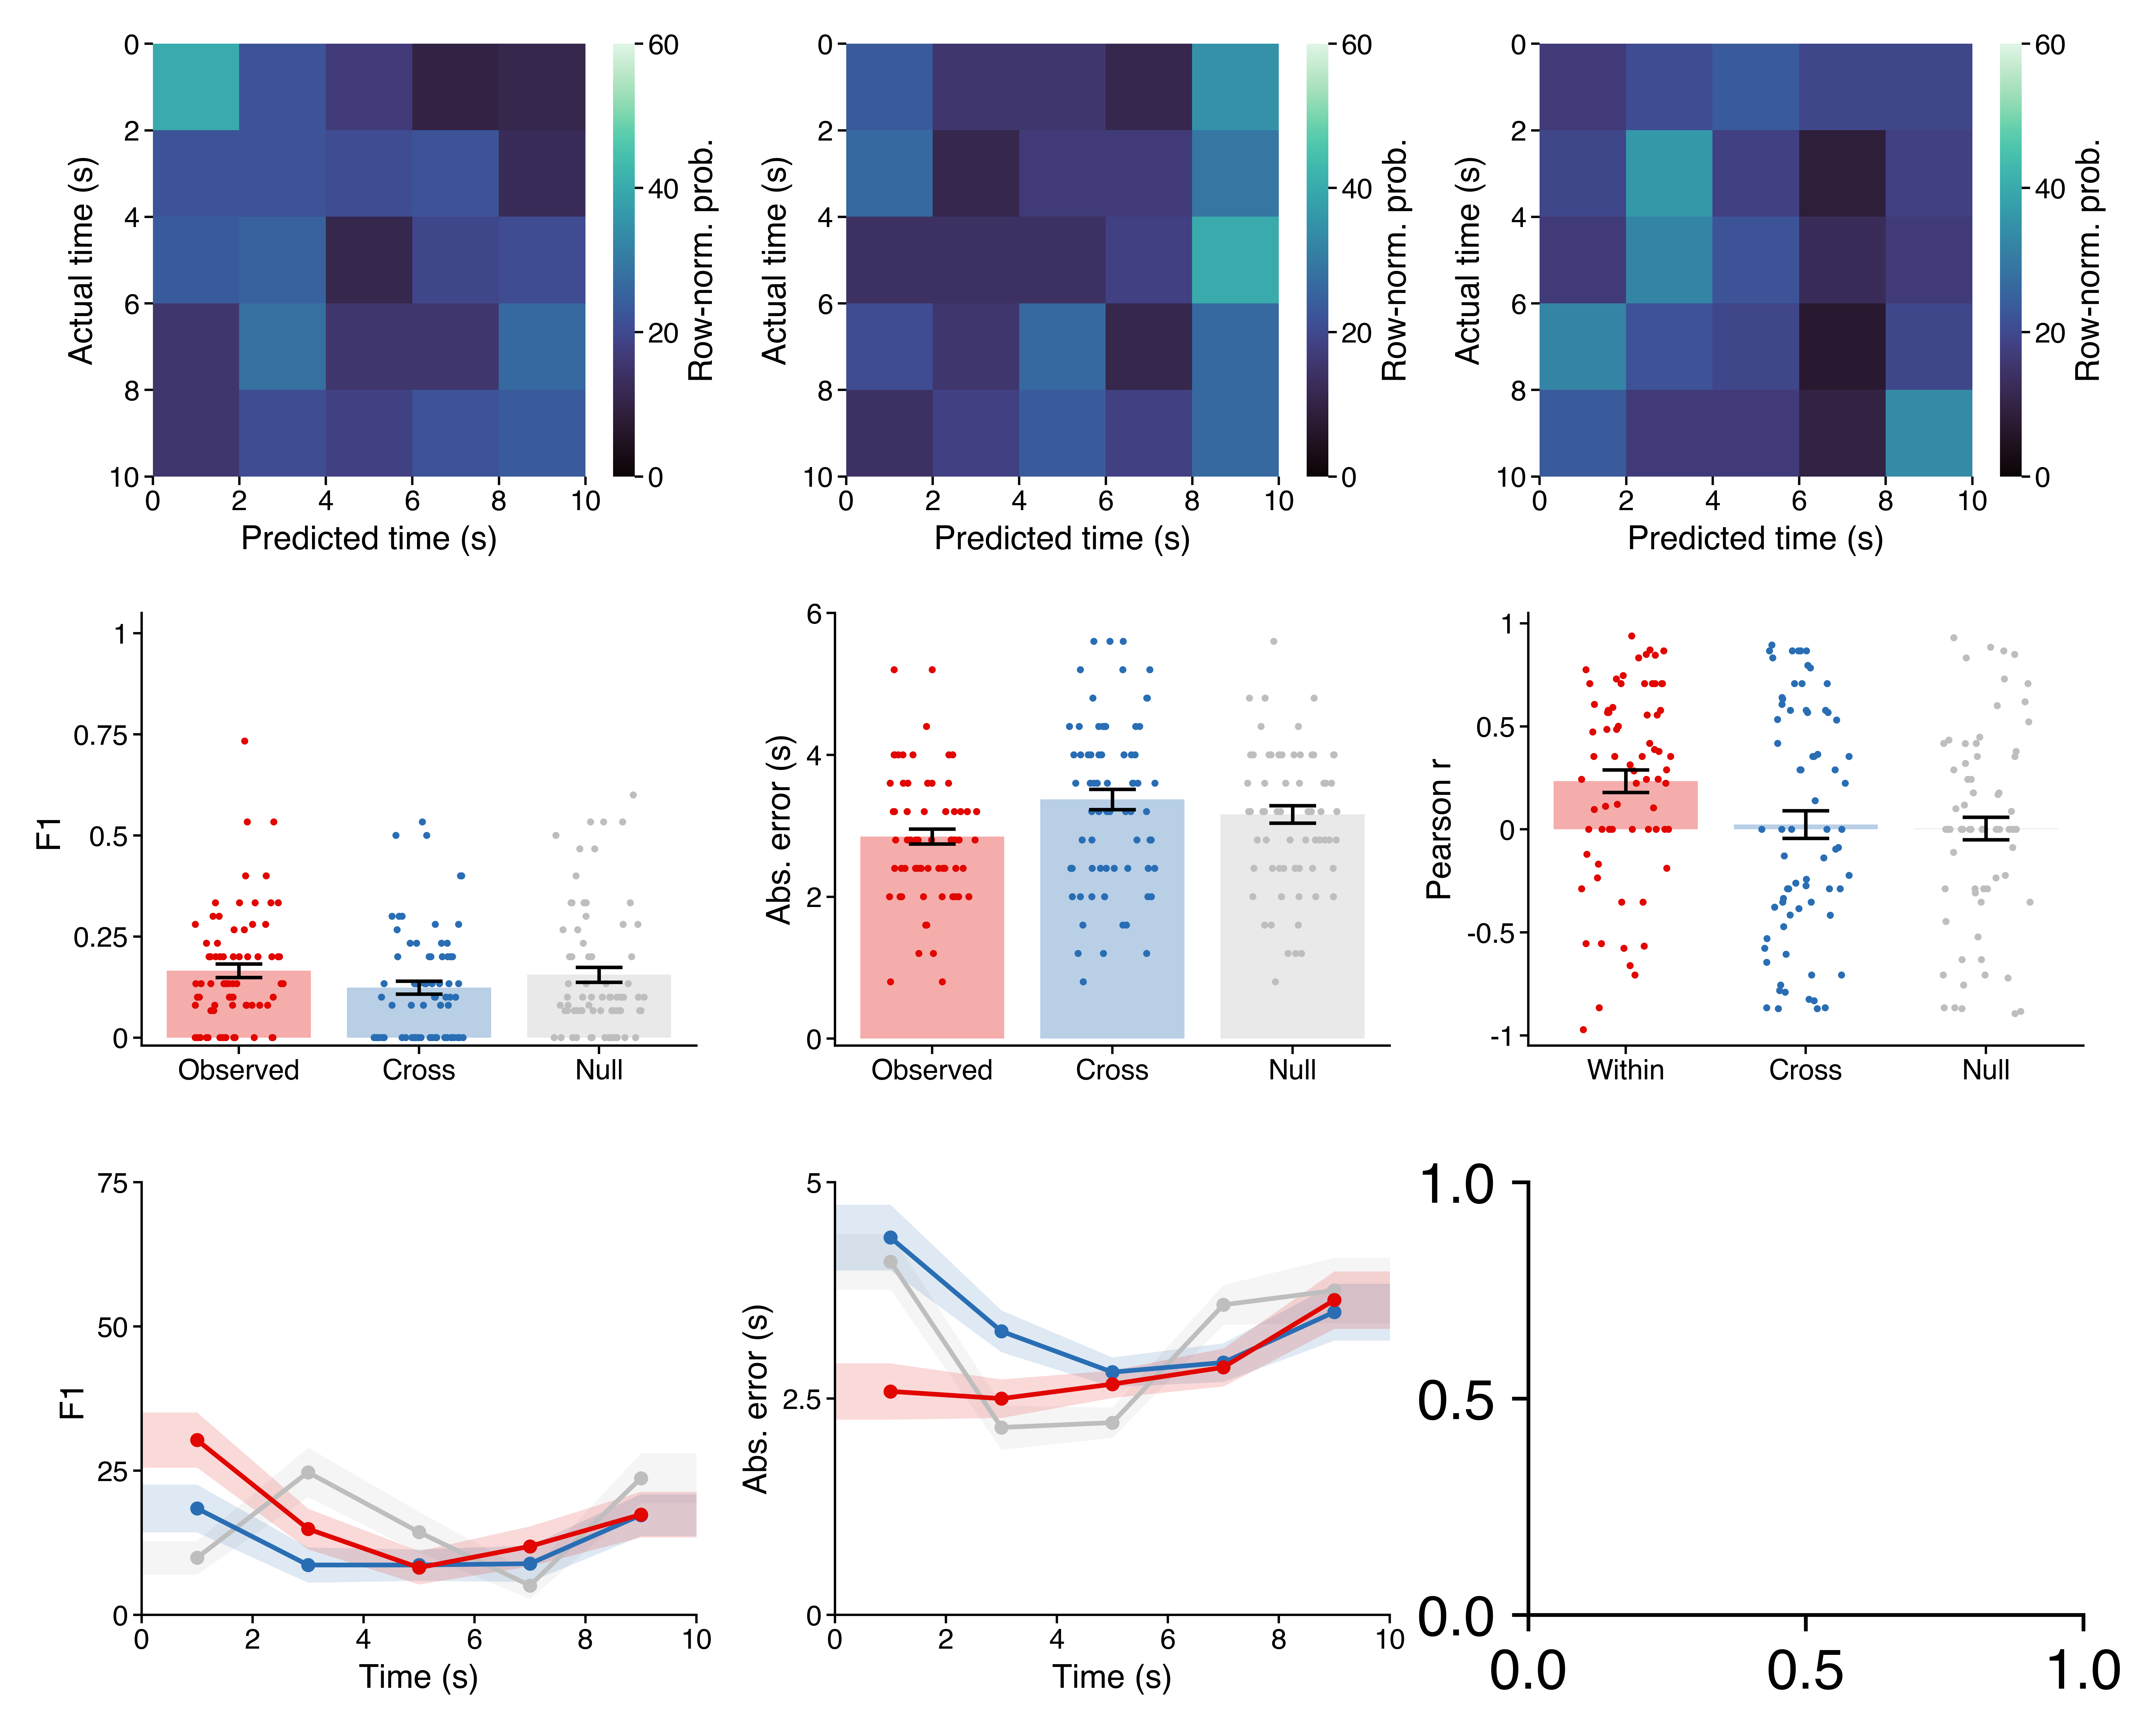

In [12]:
# !!!!!!!!!!!!
savefig = 0
overwrite = 0
verbose = 1
game_states = ['Delay1', 'Delay2']
sep_conf_mats = False
if gs_steps[game_states[0]] == 5:
    ymin_acc = -0.02
    ymax_acc = 1.05
    yticks_acc = [0, .25, .5, .75, 1]
    ymin_acc_time = 0
    ymax_acc_time = 0.75
    yticks_acc_time = [0, .25, .5, .75]
    yerr_mult = 2
    ymin_error = -0.1
    ymax_error = 6
    yticks_error = [0, 2, 4, 6]
    ymin_error_time = 0
    ymax_error_time = 5
    yticks_error_time = [0, 2.5, 5]
    ymin_corr = -1.05
    ymax_corr = 1.05
    yticks_corr = [-1, -0.5, 0, 0.5, 1]
    vmin = 0
    vmax = 60
    cbar_ticks = [0, 20, 40, 60]
elif gs_steps[game_states[0]] == 10:
    ymin_acc = -0.02
    ymax_acc = .45
    yticks_acc = [0, .1, .2, .3, .4]
    ymin_acc_time = 0
    ymax_acc_time = 0.55
    yticks_acc_time = [0, .15, .3, .45]
    yerr_mult = 1
    ymin_error = 0
    ymax_error = 6
    yticks_error = [0, 2, 4, 6]
    ymin_error_time = 0
    ymax_error_time = 6
    yticks_error_time = [0, 2, 4, 6]
    ymin_corr = -1.05
    ymax_corr = 1.05
    yticks_corr = [-1, -0.5, 0, 0.5, 1]
    vmin = 0
    vmax = 50
    cbar_ticks = [0, 20, 40]

figsize = (colws[2]*2, colws[2]*1.6)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
add_cbar = True
plot_decode = True
plot_xdecode = True
plot_null = True
alpha = 0.15
linewidth = 1
ebar_lw = 0.75
fliersize = 1.5
_cmap = 'mako'

# -----------------------------------------
plt.close()
fig, ax = plt.subplots(3, 3, dpi=dpi, figsize=figsize)
ax = np.ravel(ax)
iax = -1

print('{}\n{}'.format(', '.join(game_states), '-' * len(', '.join(game_states))))
clf_dat = clf_results.query("(gameState=={})".format(game_states)).copy()
xclf_dat = xclf_results.query("(gameState=={})".format(game_states)).copy()
clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
n_test = 1

# Run stats.
metric_cols = ['recall', 'precision', 'f1', 'abs_error', 'corr']
for metric_col in metric_cols:
    metric_col_null = '{}_null'.format(metric_col)
    _min = clf_dat[metric_col].apply(np.mean).min()
    _max = clf_dat[metric_col].apply(np.mean).max()
    _mean = clf_dat[metric_col].apply(np.mean).mean()
    _sem = stats.sem(clf_dat[metric_col].apply(np.mean))
    _xmin = xclf_dat[metric_col].apply(np.mean).min()
    _xmax = xclf_dat[metric_col].apply(np.mean).max()
    _xmean = xclf_dat[metric_col].apply(np.mean).mean()
    _xsem = stats.sem(xclf_dat[metric_col].apply(np.mean))
    _min_null = clf_dat[metric_col_null].apply(np.mean).min()
    _max_null = clf_dat[metric_col_null].apply(np.mean).max()
    _mean_null = clf_dat[metric_col_null].apply(np.mean).mean()
    _sem_null = stats.sem(clf_dat[metric_col_null].apply(np.mean))
    _xmin_null = xclf_dat[metric_col_null].apply(np.mean).min()
    _xmax_null = xclf_dat[metric_col_null].apply(np.mean).max()
    _xmean_null = xclf_dat[metric_col_null].apply(np.mean).mean()
    _xsem_null = stats.sem(xclf_dat[metric_col_null].apply(np.mean))
    print(metric_col,
          'within-decoding: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_mean, _sem, _min, _max),
          'cross-decoding: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_xmean, _xsem, _xmin, _xmax),
          'within null: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_mean_null, _sem_null, _min_null, _max_null),
          'cross null: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_xmean_null, _xsem_null, _xmin_null, _xmax_null),
          sep='\n')
    ttests = od([('within_vs_null', stats.ttest_rel(clf_dat[metric_col].apply(np.mean), clf_dat[metric_col_null].apply(np.mean))),
                 ('cross_vs_null', stats.ttest_rel(xclf_dat[metric_col].apply(np.mean), xclf_dat[metric_col_null].apply(np.mean))),
                 ('within_vs_cross', stats.ttest_rel(clf_dat[metric_col].apply(np.mean), xclf_dat[metric_col].apply(np.mean)))
                ])
    dof = len(clf_dat) - 1
    pvals_holm = sm.stats.multipletests([_test[1] for _test in ttests.values()], alpha=0.05, method='holm')
    for iTest, _test in enumerate(ttests):
        ttests[_test] = {'tstat': ttests[_test][0],
                         'pval': ttests[_test][1],
                         'pval_holm': pvals_holm[1][iTest],
                         'sig_holm': pvals_holm[0][iTest]}
        print('{}: T({}) = {:.1f}, P = {:.6f}, P_holm = {:.6f}, reject = {}'
              .format(_test,
                      dof,
                      ttests[_test]['tstat'],
                      ttests[_test]['pval'],
                      ttests[_test]['pval_holm'],
                      ttests[_test]['sig_holm']))
    print('')
    
# Make plots.
if sep_conf_mats:
    for iState, game_state in enumerate(game_states):
        clf_dat = clf_results.query("(gameState=='{}')".format(game_state)).copy()
        xclf_dat = xclf_results.query("(gameState=='{}')".format(game_state)).copy()
        clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
        xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
        clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
        xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
        n_time_steps = clf_dat.iloc[0]['n_time_steps']
        reshp = [n_test, n_time_steps]
        if game_state[:5] == 'Delay':
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]

        # Within-state confusion matrix.
        if plot_decode:
            iax += 1
            cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
            print(cmat.max())
            vmin = vmin
            vmax = vmax
            ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
            ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
            _xticks = xticks
            ax[iax].set_xlim((_xticks.min(), _xticks.max()))
            ax[iax].set_xticks(_xticks)
            ax[iax].set_xticklabels(xticklabels)
            ax[iax].set_yticks(ax[iax].get_xticks())
            ax[iax].set_yticklabels(ax[iax].get_xticklabels())
            ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
            ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
            if add_cbar:
                cbar = ax[iax].collections[0].colorbar
                cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
                cbar.set_ticks(cbar_ticks)
                cbar.set_ticklabels(cbar_ticks)
                cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
            else:
                ax[iax].collections[0].colorbar.remove()

        # Cross-decoder confusion matrix.
        if plot_xdecode:
            iax += 1
            cmat = np.mean(xclf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
            print(cmat.max())
            vmin = vmin
            vmax = vmax
            ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
            ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
            _xticks = xticks
            ax[iax].set_xlim((_xticks.min(), _xticks.max()))
            ax[iax].set_xticks(_xticks)
            ax[iax].set_xticklabels(xticklabels)
            ax[iax].set_yticks(ax[iax].get_xticks())
            ax[iax].set_yticklabels(ax[iax].get_xticklabels())
            ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
            ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
            if add_cbar:
                cbar = ax[iax].collections[0].colorbar
                cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
                cbar.set_ticks(cbar_ticks)
                cbar.set_ticklabels(cbar_ticks)
                cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
            else:
                ax[iax].collections[0].colorbar.remove()

clf_dat = clf_results.query("(gameState=={})".format(game_states)).copy()
xclf_dat = xclf_results.query("(gameState=={})".format(game_states)).copy()
clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))

if not sep_conf_mats:
    # Within-state confusion matrix.
    if plot_decode:
        iax += 1
        cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'],
                                                                normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()

    # Cross-decoder confusion matrix.
    if plot_xdecode:
        iax += 1
        cmat = np.mean(xclf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'],
                                                                 normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()

    # Within-state confusion matrix.
    if plot_decode:
        iax += 1
        cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test_null'], x['y_test_pred_null'],
                                                                normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()
        
# F1.
iax += 1
mean_acc = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['f1'].apply(np.mean).tolist())).T,
                                   np.vstack((['cross'] * len(xclf_dat), xclf_dat['f1'].apply(np.mean).tolist())).T,
                                   np.vstack((['null'] * len(clf_dat), clf_dat['f1_null'].apply(np.mean).tolist())).T)),
                        columns=['level', 'value'])
mean_acc['level'] = mean_acc['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_acc['value'] = mean_acc['value'].astype(float)

sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_acc, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_acc, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_acc['level'].unique().size),
                 mean_acc.groupby('level')['value'].mean().values,
                 yerr=mean_acc.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Observed', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_acc, ymax_acc])
ax[iax].set_yticks(yticks_acc)
ax[iax].set_yticklabels(yticks_acc, fontsize=font['tick'])
ax[iax].set_ylabel('F1', fontsize=font['label'], labelpad=labelpad)
    
# Absolute error.
iax += 1
mean_errors = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['abs_error'].apply(np.mean).tolist())).T,
                                      np.vstack((['cross'] * len(xclf_dat), xclf_dat['abs_error'].apply(np.mean).tolist())).T,
                                      np.vstack((['null'] * len(clf_dat), clf_dat['abs_error_null'].apply(np.mean).tolist())).T)),
                           columns=['level', 'value'])
mean_errors['level'] = mean_errors['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_errors['value'] = mean_errors['value'].astype(float)
sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_errors, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_errors, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_errors['level'].unique().size), mean_errors.groupby('level')['value'].mean().values,
                 yerr=mean_errors.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Observed', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_error, ymax_error])
ax[iax].set_yticks(yticks_error)
ax[iax].set_yticklabels(yticks_error, fontsize=font['tick'])
ax[iax].set_ylabel('Abs. error (s)', fontsize=font['label'], labelpad=labelpad)
    
# Correlation between actual and predicted times.
iax += 1
mean_corrs = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['corr'].tolist())).T,
                                     np.vstack((['cross'] * len(xclf_dat), xclf_dat['corr'].tolist())).T,
                                     np.vstack((['null'] * len(clf_dat), clf_dat['corr_null'].tolist())).T)),
                           columns=['level', 'value'])
mean_corrs['level'] = mean_corrs['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_corrs['value'] = mean_corrs['value'].astype(float)
sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_corrs, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_corrs, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_corrs['level'].unique().size),
                 mean_corrs.groupby('level')['value'].mean().values,
                 yerr=mean_corrs.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Within', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_corr, ymax_corr])
ax[iax].set_yticks(yticks_corr)
ax[iax].set_yticklabels(yticks_corr, fontsize=font['tick'])
ax[iax].set_ylabel('Pearson r', fontsize=font['label'], labelpad=labelpad)

# F1 by time.
iax += 1
if plot_decode:
    _means = np.mean(clf_dat['f1'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['f1'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#e10600', linewidth=0, alpha=alpha, zorder=2)
    ax[iax].plot(xvals, _means, color='#e10600', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=5)
if plot_xdecode:
    _means = np.mean(xclf_dat['f1'].tolist(), axis=0)
    _sems = stats.sem(xclf_dat['f1'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#296eb4', linewidth=0, alpha=alpha, zorder=1)
    ax[iax].plot(xvals, _means, color='#296eb4', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=4)
if plot_null:
    _means = np.mean(clf_dat['f1_null'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['f1_null'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#bebebe', linewidth=0, alpha=alpha, zorder=0)
    ax[iax].plot(xvals, _means, color='#bebebe', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=3)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
_xticks = xticks - 0.5
ax[iax].set_xlim([-0.5, xvals.size-0.5])
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylim([ymin_acc_time, ymax_acc_time])
ax[iax].set_yticks(yticks_acc_time)
ax[iax].set_yticklabels([int(x*100) for x in yticks_acc_time], fontsize=font['tick'])
ax[iax].set_ylabel('F1', fontsize=font['label'], labelpad=labelpad)

# Error distance by time.
iax += 1
if plot_decode:
    _means = np.mean(clf_dat['abs_error'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['abs_error'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#e10600', linewidth=0, alpha=alpha, zorder=2)
    ax[iax].plot(xvals, _means, color='#e10600', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=5)
if plot_xdecode:
    _means = np.mean(xclf_dat['abs_error'].tolist(), axis=0)
    _sems = stats.sem(xclf_dat['abs_error'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#296eb4', linewidth=0, alpha=alpha, zorder=1)
    ax[iax].plot(xvals, _means, color='#296eb4', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=4)
if plot_null:
    _means = np.mean(clf_dat['abs_error_null'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['abs_error_null'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#bebebe', linewidth=0, alpha=alpha, zorder=0)
    ax[iax].plot(xvals, _means, color='#bebebe', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=3)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
_xticks = xticks - 0.5
ax[iax].set_xlim([-0.5, xvals.size-0.5])
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylim([ymin_error_time, ymax_error_time])
ax[iax].set_yticks(yticks_error_time)
ax[iax].set_yticklabels(yticks_error_time, fontsize=font['tick'])
ax[iax].set_ylabel('Abs. error (s)', fontsize=font['label'], labelpad=labelpad)
        
fig.tight_layout(pad=0.25, h_pad=1)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}bins.pdf'
                       .format(n_units, unit_group, game_states[0], n_time_steps, game_states[1], n_time_steps))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight')
        
fig.show()

# Encoding, Retrieval: only time cells

In [28]:
game_states = ['Encoding', 'Retrieval']
n_units = 119
unit_group = 'timeAll'
gs_steps = {'Delay1': 5, 'Delay2': 5, 'Encoding': 15, 'Retrieval': 15}

filename = op.join(proj_dir, 'analysis', 'classifiers',
                   'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}bins.pkl'
                   .format(n_units, unit_group,
                           game_states[0], gs_steps[game_states[0]],
                           game_states[1], gs_steps[game_states[1]]))
clf_results = dio.open_pickle(filename)

xfilename = op.join(proj_dir, 'analysis', 'classifiers',
                    'SVC_predicting_time_step-{}units_{}-random_search-36fold-cross_decoding-{}_{}bins-{}_{}bins.pkl'
                    .format(n_units, unit_group,
                            game_states[0], gs_steps[game_states[0]],
                            game_states[1], gs_steps[game_states[1]]))
xclf_results = dio.open_pickle(xfilename)

# --------------------------
# Resort y_test_null and y_test_pred_null on the values within each y_test_null test trial.
for _df in (clf_results, xclf_results):
    for col in ['accuracy_null', 'acc_by_time_null', 'y_test_pred_null', 'y_test_null']:
        _df[col] = _df.apply(lambda x: sort_onto(x['y_test_null'], x[col], len(x['test_trials'])), axis=1)
        
# Drop columns that we don't need.
drop_cols = ['mean_acc', 'acc_by_time', 'accuracy', 'clf',
             'mean_acc_null', 'acc_by_time_null', 'accuracy_null', 'clf_null']
for _df in (clf_results, xclf_results):
    _drop_cols = [col for col in drop_cols if col in _df.columns]
    if len(_drop_cols) > 0:
        _df.drop(columns=_drop_cols, inplace=True)

# Alias gameState in the cross-decoding dataframe.
xclf_results['gameState'] = xclf_results['gameState_test']

# Calculate performance metrics.
for _df in (clf_results, xclf_results):
    _df['recall'] = _df.apply(lambda x: metrics.recall_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
    _df['precision'] = _df.apply(lambda x: metrics.precision_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
    _df['f1'] = _df.apply(lambda x: metrics.f1_score(x['y_test'], x['y_test_pred'], average=None).tolist(), axis=1)
    _df['error'] = _df.apply(lambda x: clf_error(x['y_test'], x['y_test_pred']), axis=1)
    _df['abs_error'] = _df.apply(lambda x: np.abs(x['error']).tolist(), axis=1)
    _df['corr'] = _df.apply(lambda x: stats.pearsonr(x['y_test_pred'], x['y_test'])[0], axis=1).fillna(0)
    
    _df['recall_null'] = _df.apply(lambda x: metrics.recall_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
    _df['precision_null'] = _df.apply(lambda x: metrics.precision_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
    _df['f1_null'] = _df.apply(lambda x: metrics.f1_score(x['y_test_null'], x['y_test_pred_null'], average=None).tolist(), axis=1)
    _df['error_null'] = _df.apply(lambda x: clf_error(x['y_test_null'], x['y_test_pred_null']), axis=1)
    _df['abs_error_null'] = _df.apply(lambda x: np.abs(x['error_null']).tolist(), axis=1)
    _df['corr_null'] = _df.apply(lambda x: stats.pearsonr(x['y_test_pred_null'], x['y_test_null'])[0], axis=1).fillna(0)
    
print(clf_results.shape, xclf_results.shape)

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(72, 26) (72, 21)


Encoding, Retrieval
-------------------
recall
within-decoding: 0.24 ± 0.011, min = 0.07, max = 0.47
cross-decoding: 0.12 ± 0.010, min = 0.00, max = 0.40
within null: 0.06 ± 0.006, min = 0.00, max = 0.20
cross null: 0.06 ± 0.007, min = 0.00, max = 0.20
within_vs_null: T(71) = 13.9, P = 0.000000, P_holm = 0.000000, reject = True
cross_vs_null: T(71) = 4.2, P = 0.000087, P_holm = 0.000087, reject = True
within_vs_cross: T(71) = 8.0, P = 0.000000, P_holm = 0.000000, reject = True

precision
within-decoding: 0.16 ± 0.009, min = 0.01, max = 0.33
cross-decoding: 0.07 ± 0.008, min = 0.00, max = 0.30
within null: 0.03 ± 0.004, min = 0.00, max = 0.13
cross null: 0.03 ± 0.005, min = 0.00, max = 0.20
within_vs_null: T(71) = 12.5, P = 0.000000, P_holm = 0.000000, reject = True
cross_vs_null: T(71) = 4.2, P = 0.000078, P_holm = 0.000078, reject = True
within_vs_cross: T(71) = 7.7, P = 0.000000, P_holm = 0.000000, reject = True

f1
within-decoding: 0.18 ± 0.010, min = 0.02, max = 0.37
cross-decoding

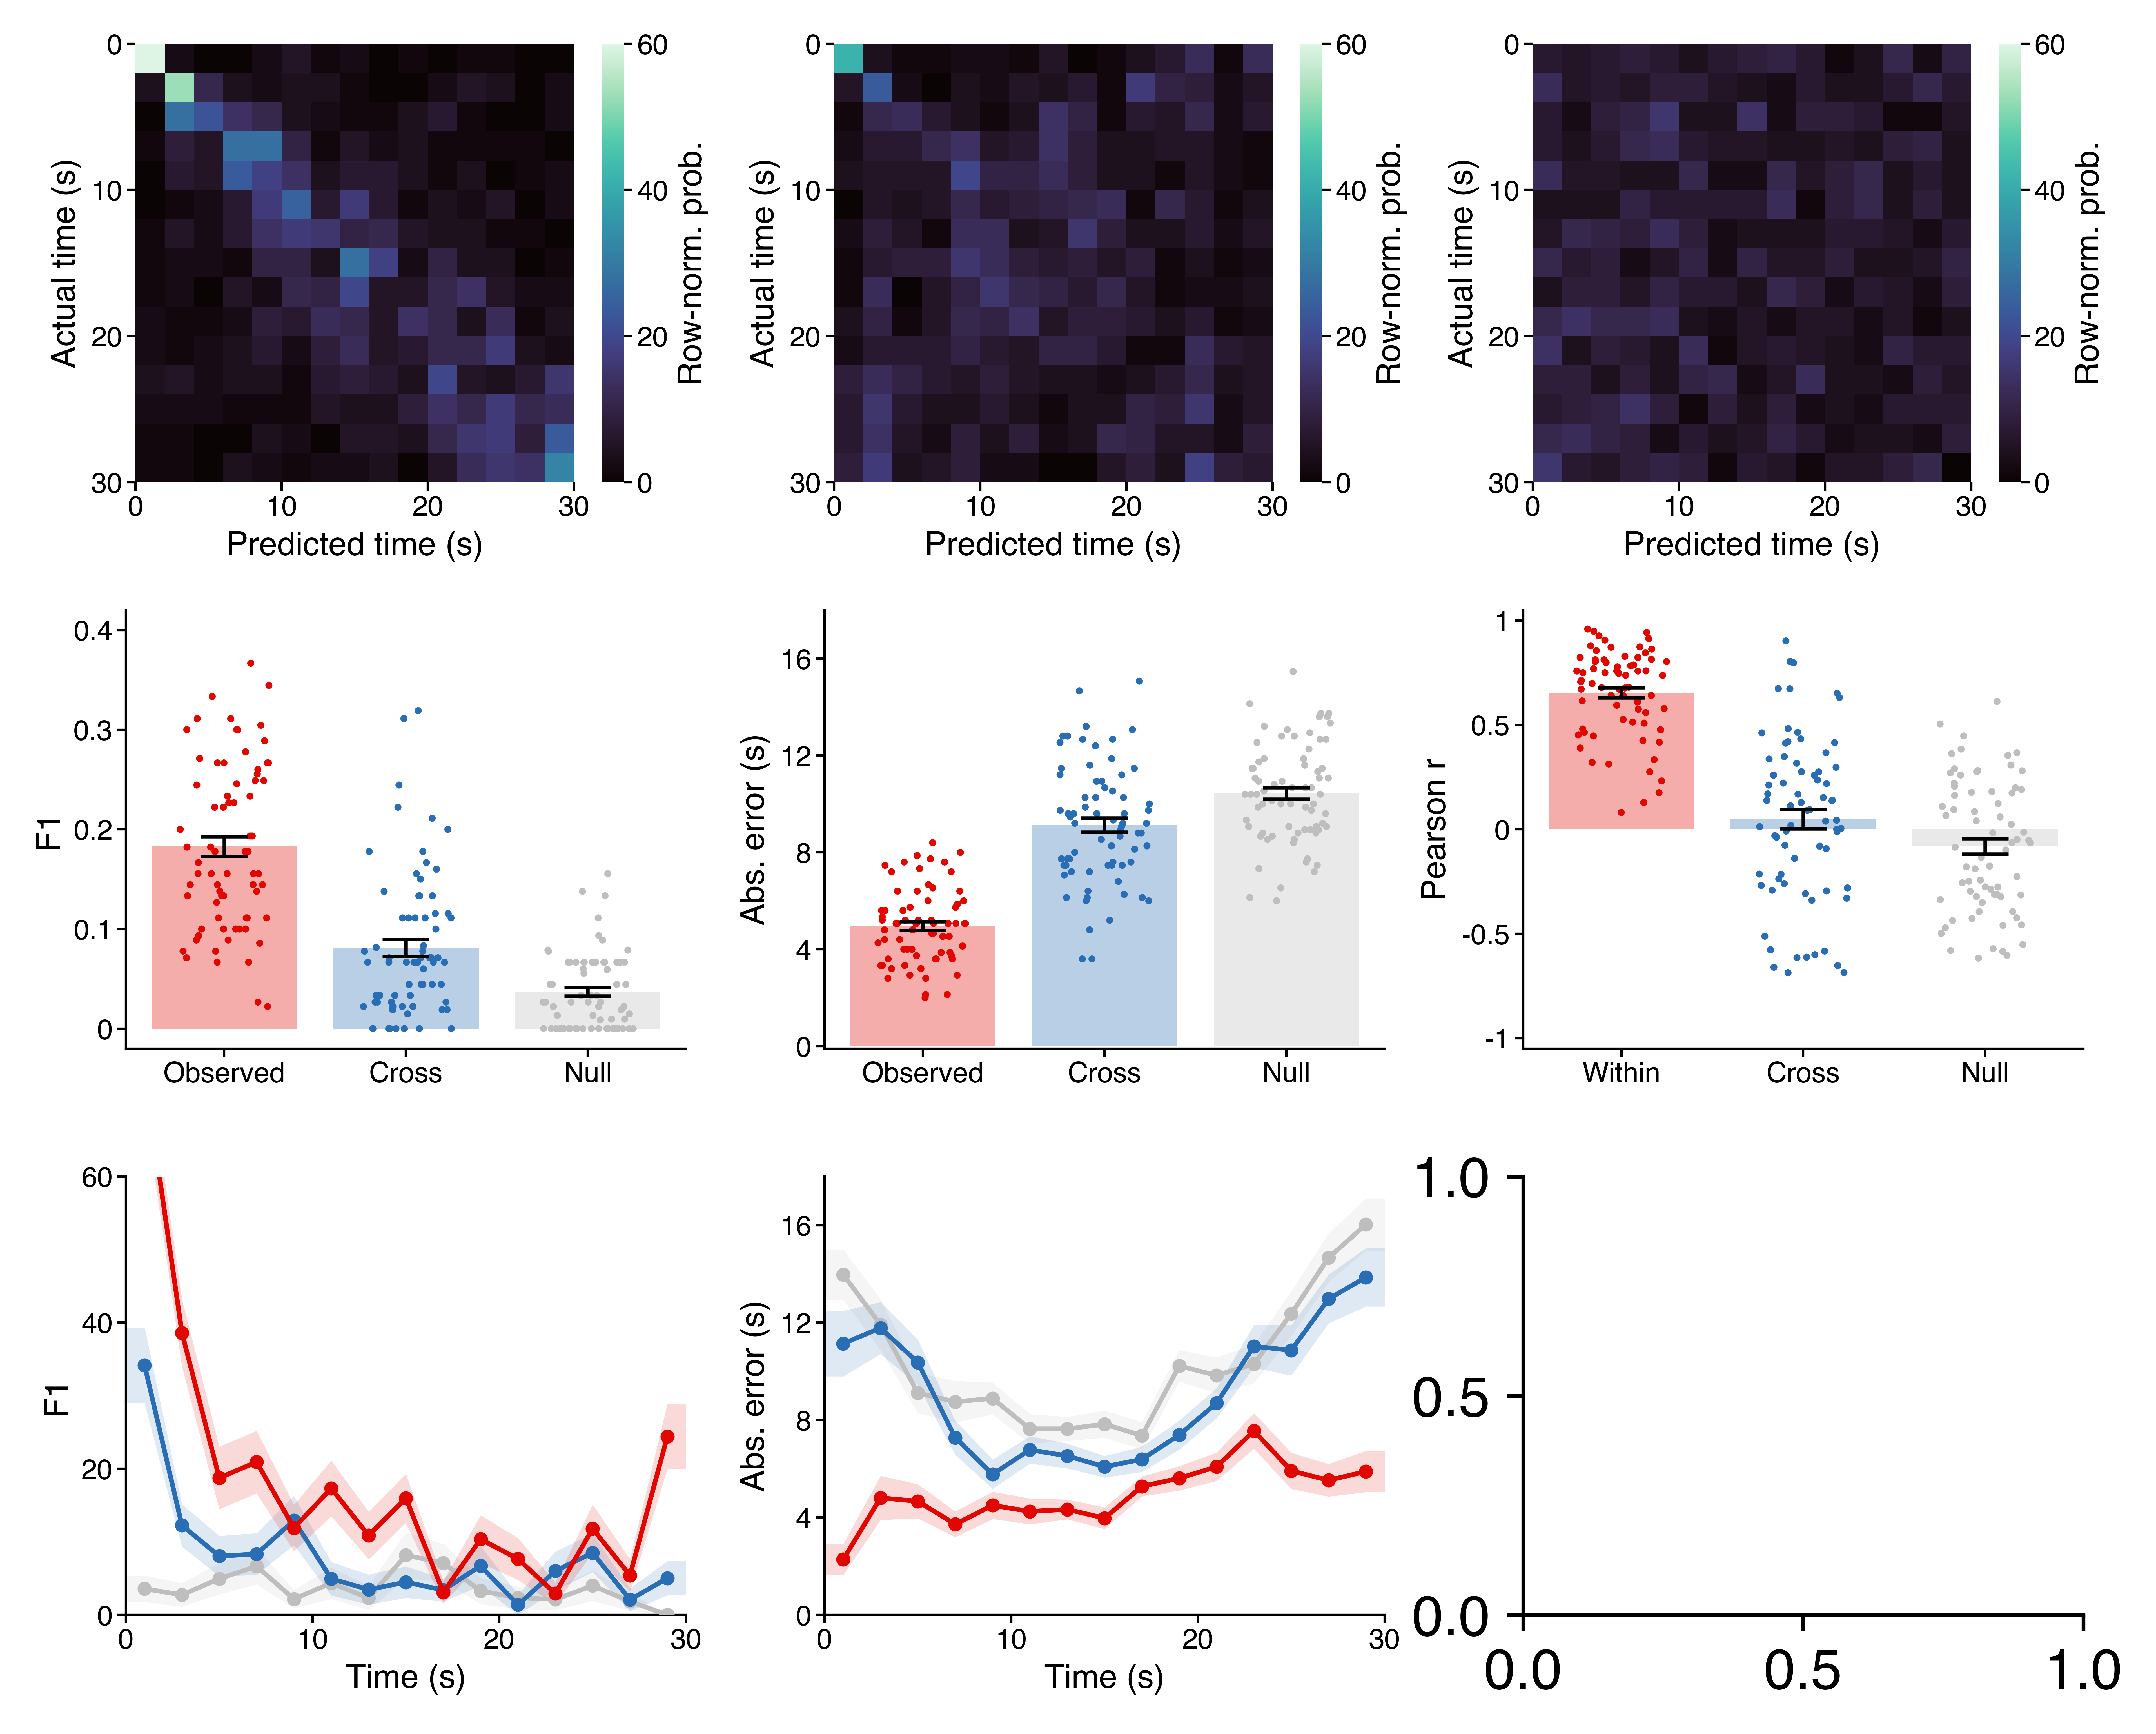

In [29]:
# !!!!!!!!!!!!
savefig = 0
overwrite = 0
verbose = 1
sep_conf_mats = False
if gs_steps[game_states[0]] == 5:
    ymin_acc = -0.02
    ymax_acc = 1.05
    yticks_acc = [0, .25, .5, .75, 1]
    ymin_acc_time = 0
    ymax_acc_time = 0.75
    yticks_acc_time = [0, .25, .5, .75]
    yerr_mult = 2
    ymin_error = -0.1
    ymax_error = 6
    yticks_error = [0, 2, 4, 6]
    ymin_error_time = 0
    ymax_error_time = 5
    yticks_error_time = [0, 2.5, 5]
    ymin_corr = -1.05
    ymax_corr = 1.05
    yticks_corr = [-1, -0.5, 0, 0.5, 1]
    vmin = 0
    vmax = 60
    cbar_ticks = [0, 20, 40, 60]
elif gs_steps[game_states[0]] == 15:
    ymin_acc = -0.02
    ymax_acc = .42
    yticks_acc = [0, .1, .2, .3, .4]
    ymin_acc_time = 0
    ymax_acc_time = 0.6
    yticks_acc_time = [0, .2, .4, .6]
    yerr_mult = 2
    ymin_error = -0.1
    ymax_error = 18
    yticks_error = [0, 4, 8, 12, 16]
    ymin_error_time = 0
    ymax_error_time = 18
    yticks_error_time = [0, 4, 8, 12, 16]
    ymin_corr = -1.05
    ymax_corr = 1.05
    yticks_corr = [-1, -0.5, 0, 0.5, 1]
    vmin = 0
    vmax = 60
    cbar_ticks = [0, 20, 40, 60]

figsize = (colws[2]*2, colws[2]*1.6)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
add_cbar = True
plot_decode = True
plot_xdecode = True
plot_null = True
alpha = 0.15
linewidth = 1
ebar_lw = 0.75
fliersize = 1.5
_cmap = 'mako'

# -----------------------------------------
plt.close()
fig, ax = plt.subplots(3, 3, dpi=dpi, figsize=figsize)
ax = np.ravel(ax)
iax = -1

print('{}\n{}'.format(', '.join(game_states), '-' * len(', '.join(game_states))))
clf_dat = clf_results.query("(gameState=={})".format(game_states)).copy()
xclf_dat = xclf_results.query("(gameState=={})".format(game_states)).copy()
clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
n_test = 1

# Run stats.
metric_cols = ['recall', 'precision', 'f1', 'abs_error', 'corr']
for metric_col in metric_cols:
    metric_col_null = '{}_null'.format(metric_col)
    _min = clf_dat[metric_col].apply(np.mean).min()
    _max = clf_dat[metric_col].apply(np.mean).max()
    _mean = clf_dat[metric_col].apply(np.mean).mean()
    _sem = stats.sem(clf_dat[metric_col].apply(np.mean))
    _xmin = xclf_dat[metric_col].apply(np.mean).min()
    _xmax = xclf_dat[metric_col].apply(np.mean).max()
    _xmean = xclf_dat[metric_col].apply(np.mean).mean()
    _xsem = stats.sem(xclf_dat[metric_col].apply(np.mean))
    _min_null = clf_dat[metric_col_null].apply(np.mean).min()
    _max_null = clf_dat[metric_col_null].apply(np.mean).max()
    _mean_null = clf_dat[metric_col_null].apply(np.mean).mean()
    _sem_null = stats.sem(clf_dat[metric_col_null].apply(np.mean))
    _xmin_null = xclf_dat[metric_col_null].apply(np.mean).min()
    _xmax_null = xclf_dat[metric_col_null].apply(np.mean).max()
    _xmean_null = xclf_dat[metric_col_null].apply(np.mean).mean()
    _xsem_null = stats.sem(xclf_dat[metric_col_null].apply(np.mean))
    print(metric_col,
          'within-decoding: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_mean, _sem, _min, _max),
          'cross-decoding: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_xmean, _xsem, _xmin, _xmax),
          'within null: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_mean_null, _sem_null, _min_null, _max_null),
          'cross null: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_xmean_null, _xsem_null, _xmin_null, _xmax_null),
          sep='\n')
    ttests = od([('within_vs_null', stats.ttest_rel(clf_dat[metric_col].apply(np.mean), clf_dat[metric_col_null].apply(np.mean))),
                 ('cross_vs_null', stats.ttest_rel(xclf_dat[metric_col].apply(np.mean), xclf_dat[metric_col_null].apply(np.mean))),
                 ('within_vs_cross', stats.ttest_rel(clf_dat[metric_col].apply(np.mean), xclf_dat[metric_col].apply(np.mean)))
                ])
    dof = len(clf_dat) - 1
    pvals_holm = sm.stats.multipletests([_test[1] for _test in ttests.values()], alpha=0.05, method='holm')
    for iTest, _test in enumerate(ttests):
        ttests[_test] = {'tstat': ttests[_test][0],
                         'pval': ttests[_test][1],
                         'pval_holm': pvals_holm[1][iTest],
                         'sig_holm': pvals_holm[0][iTest]}
        print('{}: T({}) = {:.1f}, P = {:.6f}, P_holm = {:.6f}, reject = {}'
              .format(_test,
                      dof,
                      ttests[_test]['tstat'],
                      ttests[_test]['pval'],
                      ttests[_test]['pval_holm'],
                      ttests[_test]['sig_holm']))
    print('')
    
# Make plots.
if sep_conf_mats:
    for iState, game_state in enumerate(game_states):
        clf_dat = clf_results.query("(gameState=='{}')".format(game_state)).copy()
        xclf_dat = xclf_results.query("(gameState=='{}')".format(game_state)).copy()
        clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
        xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
        clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
        xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
        n_time_steps = clf_dat.iloc[0]['n_time_steps']
        reshp = [n_test, n_time_steps]
        if game_state[:5] == 'Delay':
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]

        # Within-state confusion matrix.
        if plot_decode:
            iax += 1
            cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
            print(cmat.max())
            vmin = vmin
            vmax = vmax
            ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
            ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
            _xticks = xticks
            ax[iax].set_xlim((_xticks.min(), _xticks.max()))
            ax[iax].set_xticks(_xticks)
            ax[iax].set_xticklabels(xticklabels)
            ax[iax].set_yticks(ax[iax].get_xticks())
            ax[iax].set_yticklabels(ax[iax].get_xticklabels())
            ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
            ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
            if add_cbar:
                cbar = ax[iax].collections[0].colorbar
                cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
                cbar.set_ticks(cbar_ticks)
                cbar.set_ticklabels(cbar_ticks)
                cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
            else:
                ax[iax].collections[0].colorbar.remove()

        # Cross-decoder confusion matrix.
        if plot_xdecode:
            iax += 1
            cmat = np.mean(xclf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
            print(cmat.max())
            vmin = vmin
            vmax = vmax
            ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
            ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
            _xticks = xticks
            ax[iax].set_xlim((_xticks.min(), _xticks.max()))
            ax[iax].set_xticks(_xticks)
            ax[iax].set_xticklabels(xticklabels)
            ax[iax].set_yticks(ax[iax].get_xticks())
            ax[iax].set_yticklabels(ax[iax].get_xticklabels())
            ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
            ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
            if add_cbar:
                cbar = ax[iax].collections[0].colorbar
                cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
                cbar.set_ticks(cbar_ticks)
                cbar.set_ticklabels(cbar_ticks)
                cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
            else:
                ax[iax].collections[0].colorbar.remove()

clf_dat = clf_results.query("(gameState=={})".format(game_states)).copy()
xclf_dat = xclf_results.query("(gameState=={})".format(game_states)).copy()
clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
n_time_steps = clf_results.iloc[0]['n_time_steps']

if not sep_conf_mats:
    # Within-state confusion matrix.
    if plot_decode:
        iax += 1
        cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'],
                                                                normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()

    # Cross-decoder confusion matrix.
    if plot_xdecode:
        iax += 1
        cmat = np.mean(xclf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'],
                                                                 normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()

    # Within-state confusion matrix.
    if plot_decode:
        iax += 1
        cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test_null'], x['y_test_pred_null'],
                                                                normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()
        
# F1.
iax += 1
mean_acc = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['f1'].apply(np.mean).tolist())).T,
                                   np.vstack((['cross'] * len(xclf_dat), xclf_dat['f1'].apply(np.mean).tolist())).T,
                                   np.vstack((['null'] * len(clf_dat), clf_dat['f1_null'].apply(np.mean).tolist())).T)),
                        columns=['level', 'value'])
mean_acc['level'] = mean_acc['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_acc['value'] = mean_acc['value'].astype(float)

sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_acc, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_acc, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_acc['level'].unique().size),
                 mean_acc.groupby('level')['value'].mean().values,
                 yerr=mean_acc.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Observed', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_acc, ymax_acc])
ax[iax].set_yticks(yticks_acc)
ax[iax].set_yticklabels(yticks_acc, fontsize=font['tick'])
ax[iax].set_ylabel('F1', fontsize=font['label'], labelpad=labelpad)
    
# Absolute error.
iax += 1
mean_errors = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['abs_error'].apply(np.mean).tolist())).T,
                                      np.vstack((['cross'] * len(xclf_dat), xclf_dat['abs_error'].apply(np.mean).tolist())).T,
                                      np.vstack((['null'] * len(clf_dat), clf_dat['abs_error_null'].apply(np.mean).tolist())).T)),
                           columns=['level', 'value'])
mean_errors['level'] = mean_errors['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_errors['value'] = mean_errors['value'].astype(float)
sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_errors, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_errors, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_errors['level'].unique().size), mean_errors.groupby('level')['value'].mean().values,
                 yerr=mean_errors.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Observed', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_error, ymax_error])
ax[iax].set_yticks(yticks_error)
ax[iax].set_yticklabels(yticks_error, fontsize=font['tick'])
ax[iax].set_ylabel('Abs. error (s)', fontsize=font['label'], labelpad=labelpad)
    
# Correlation between actual and predicted times.
iax += 1
mean_corrs = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['corr'].tolist())).T,
                                     np.vstack((['cross'] * len(xclf_dat), xclf_dat['corr'].tolist())).T,
                                     np.vstack((['null'] * len(clf_dat), clf_dat['corr_null'].tolist())).T)),
                           columns=['level', 'value'])
mean_corrs['level'] = mean_corrs['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_corrs['value'] = mean_corrs['value'].astype(float)
sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_corrs, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_corrs, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_corrs['level'].unique().size),
                 mean_corrs.groupby('level')['value'].mean().values,
                 yerr=mean_corrs.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Within', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_corr, ymax_corr])
ax[iax].set_yticks(yticks_corr)
ax[iax].set_yticklabels(yticks_corr, fontsize=font['tick'])
ax[iax].set_ylabel('Pearson r', fontsize=font['label'], labelpad=labelpad)

# F1 by time.
iax += 1
if plot_decode:
    _means = np.mean(clf_dat['f1'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['f1'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#e10600', linewidth=0, alpha=alpha, zorder=2)
    ax[iax].plot(xvals, _means, color='#e10600', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=5)
if plot_xdecode:
    _means = np.mean(xclf_dat['f1'].tolist(), axis=0)
    _sems = stats.sem(xclf_dat['f1'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#296eb4', linewidth=0, alpha=alpha, zorder=1)
    ax[iax].plot(xvals, _means, color='#296eb4', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=4)
if plot_null:
    _means = np.mean(clf_dat['f1_null'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['f1_null'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#bebebe', linewidth=0, alpha=alpha, zorder=0)
    ax[iax].plot(xvals, _means, color='#bebebe', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=3)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
_xticks = xticks - 0.5
ax[iax].set_xlim([-0.5, xvals.size-0.5])
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylim([ymin_acc_time, ymax_acc_time])
ax[iax].set_yticks(yticks_acc_time)
ax[iax].set_yticklabels([int(x*100) for x in yticks_acc_time], fontsize=font['tick'])
ax[iax].set_ylabel('F1', fontsize=font['label'], labelpad=labelpad)

# Error distance by time.
iax += 1
if plot_decode:
    _means = np.mean(clf_dat['abs_error'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['abs_error'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#e10600', linewidth=0, alpha=alpha, zorder=2)
    ax[iax].plot(xvals, _means, color='#e10600', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=5)
if plot_xdecode:
    _means = np.mean(xclf_dat['abs_error'].tolist(), axis=0)
    _sems = stats.sem(xclf_dat['abs_error'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#296eb4', linewidth=0, alpha=alpha, zorder=1)
    ax[iax].plot(xvals, _means, color='#296eb4', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=4)
if plot_null:
    _means = np.mean(clf_dat['abs_error_null'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['abs_error_null'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#bebebe', linewidth=0, alpha=alpha, zorder=0)
    ax[iax].plot(xvals, _means, color='#bebebe', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=3)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
_xticks = xticks - 0.5
ax[iax].set_xlim([-0.5, xvals.size-0.5])
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylim([ymin_error_time, ymax_error_time])
ax[iax].set_yticks(yticks_error_time)
ax[iax].set_yticklabels(yticks_error_time, fontsize=font['tick'])
ax[iax].set_ylabel('Abs. error (s)', fontsize=font['label'], labelpad=labelpad)
        
fig.tight_layout(pad=0.25, h_pad=1)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}bins.pdf'
                       .format(n_units, unit_group, game_states[0], n_time_steps, game_states[1], n_time_steps))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight')
        
fig.show()

# Encoding, Retrieval: not time cells

In [21]:
game_states = ['Encoding', 'Retrieval']
n_units = 338
unit_group = 'timeNo'
gs_steps = {'Delay1': 5, 'Delay2': 5, 'Encoding': 15, 'Retrieval': 15}

filename = op.join(proj_dir, 'analysis', 'classifiers',
                   'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}bins.pkl'
                   .format(n_units, unit_group,
                           game_states[0], gs_steps[game_states[0]],
                           game_states[1], gs_steps[game_states[1]]))
clf_results = dio.open_pickle(filename)

xfilename = op.join(proj_dir, 'analysis', 'classifiers',
                    'SVC_predicting_time_step-{}units_{}-random_search-36fold-cross_decoding-{}_{}bins-{}_{}bins.pkl'
                    .format(n_units, unit_group,
                            game_states[0], gs_steps[game_states[0]],
                            game_states[1], gs_steps[game_states[1]]))
xclf_results = dio.open_pickle(xfilename)

# --------------------------
# Resort y_test_null and y_test_pred_null on the values within each y_test_null test trial.
for _df in (clf_results, xclf_results):
    for col in ['accuracy_null', 'acc_by_time_null', 'y_test_pred_null', 'y_test_null']:
        _df[col] = _df.apply(lambda x: sort_onto(x['y_test_null'], x[col], len(x['test_trials'])), axis=1)
        
# Drop columns that we don't need.
drop_cols = ['mean_acc', 'acc_by_time', 'accuracy', 'clf',
             'mean_acc_null', 'acc_by_time_null', 'accuracy_null', 'clf_null']
for _df in (clf_results, xclf_results):
    _drop_cols = [col for col in drop_cols if col in _df.columns]
    if len(_drop_cols) > 0:
        _df.drop(columns=_drop_cols, inplace=True)

# Alias gameState in the cross-decoding dataframe.
xclf_results['gameState'] = xclf_results['gameState_test']

# Calculate performance metrics.
for _df in (clf_results, xclf_results):
    _df['recall'] = _df.apply(lambda x: metrics.recall_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
    _df['precision'] = _df.apply(lambda x: metrics.precision_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
    _df['f1'] = _df.apply(lambda x: metrics.f1_score(x['y_test'], x['y_test_pred'], average=None).tolist(), axis=1)
    _df['error'] = _df.apply(lambda x: clf_error(x['y_test'], x['y_test_pred']), axis=1)
    _df['abs_error'] = _df.apply(lambda x: np.abs(x['error']).tolist(), axis=1)
    _df['corr'] = _df.apply(lambda x: stats.pearsonr(x['y_test_pred'], x['y_test'])[0], axis=1).fillna(0)
    
    _df['recall_null'] = _df.apply(lambda x: metrics.recall_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
    _df['precision_null'] = _df.apply(lambda x: metrics.precision_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
    _df['f1_null'] = _df.apply(lambda x: metrics.f1_score(x['y_test_null'], x['y_test_pred_null'], average=None).tolist(), axis=1)
    _df['error_null'] = _df.apply(lambda x: clf_error(x['y_test_null'], x['y_test_pred_null']), axis=1)
    _df['abs_error_null'] = _df.apply(lambda x: np.abs(x['error_null']).tolist(), axis=1)
    _df['corr_null'] = _df.apply(lambda x: stats.pearsonr(x['y_test_pred_null'], x['y_test_null'])[0], axis=1).fillna(0)
    
print(clf_results.shape, xclf_results.shape)

/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home1/dscho/anaconda3/envs/memlab/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(72, 26) (72, 21)


Encoding, Retrieval
-------------------
recall
within-decoding: 0.23 ± 0.012, min = 0.07, max = 0.40
cross-decoding: 0.19 ± 0.011, min = 0.00, max = 0.40
within null: 0.06 ± 0.008, min = 0.00, max = 0.27
cross null: 0.06 ± 0.007, min = 0.00, max = 0.27
within_vs_null: T(71) = 10.6, P = 0.000000, P_holm = 0.000000, reject = True
cross_vs_null: T(71) = 10.4, P = 0.000000, P_holm = 0.000000, reject = True
within_vs_cross: T(71) = 2.1, P = 0.038644, P_holm = 0.038644, reject = True

precision
within-decoding: 0.16 ± 0.009, min = 0.03, max = 0.34
cross-decoding: 0.12 ± 0.008, min = 0.00, max = 0.27
within null: 0.03 ± 0.005, min = 0.00, max = 0.17
cross null: 0.03 ± 0.005, min = 0.00, max = 0.20
within_vs_null: T(71) = 11.3, P = 0.000000, P_holm = 0.000000, reject = True
cross_vs_null: T(71) = 10.6, P = 0.000000, P_holm = 0.000000, reject = True
within_vs_cross: T(71) = 2.8, P = 0.005730, P_holm = 0.005730, reject = True

f1
within-decoding: 0.17 ± 0.010, min = 0.04, max = 0.35
cross-decodi

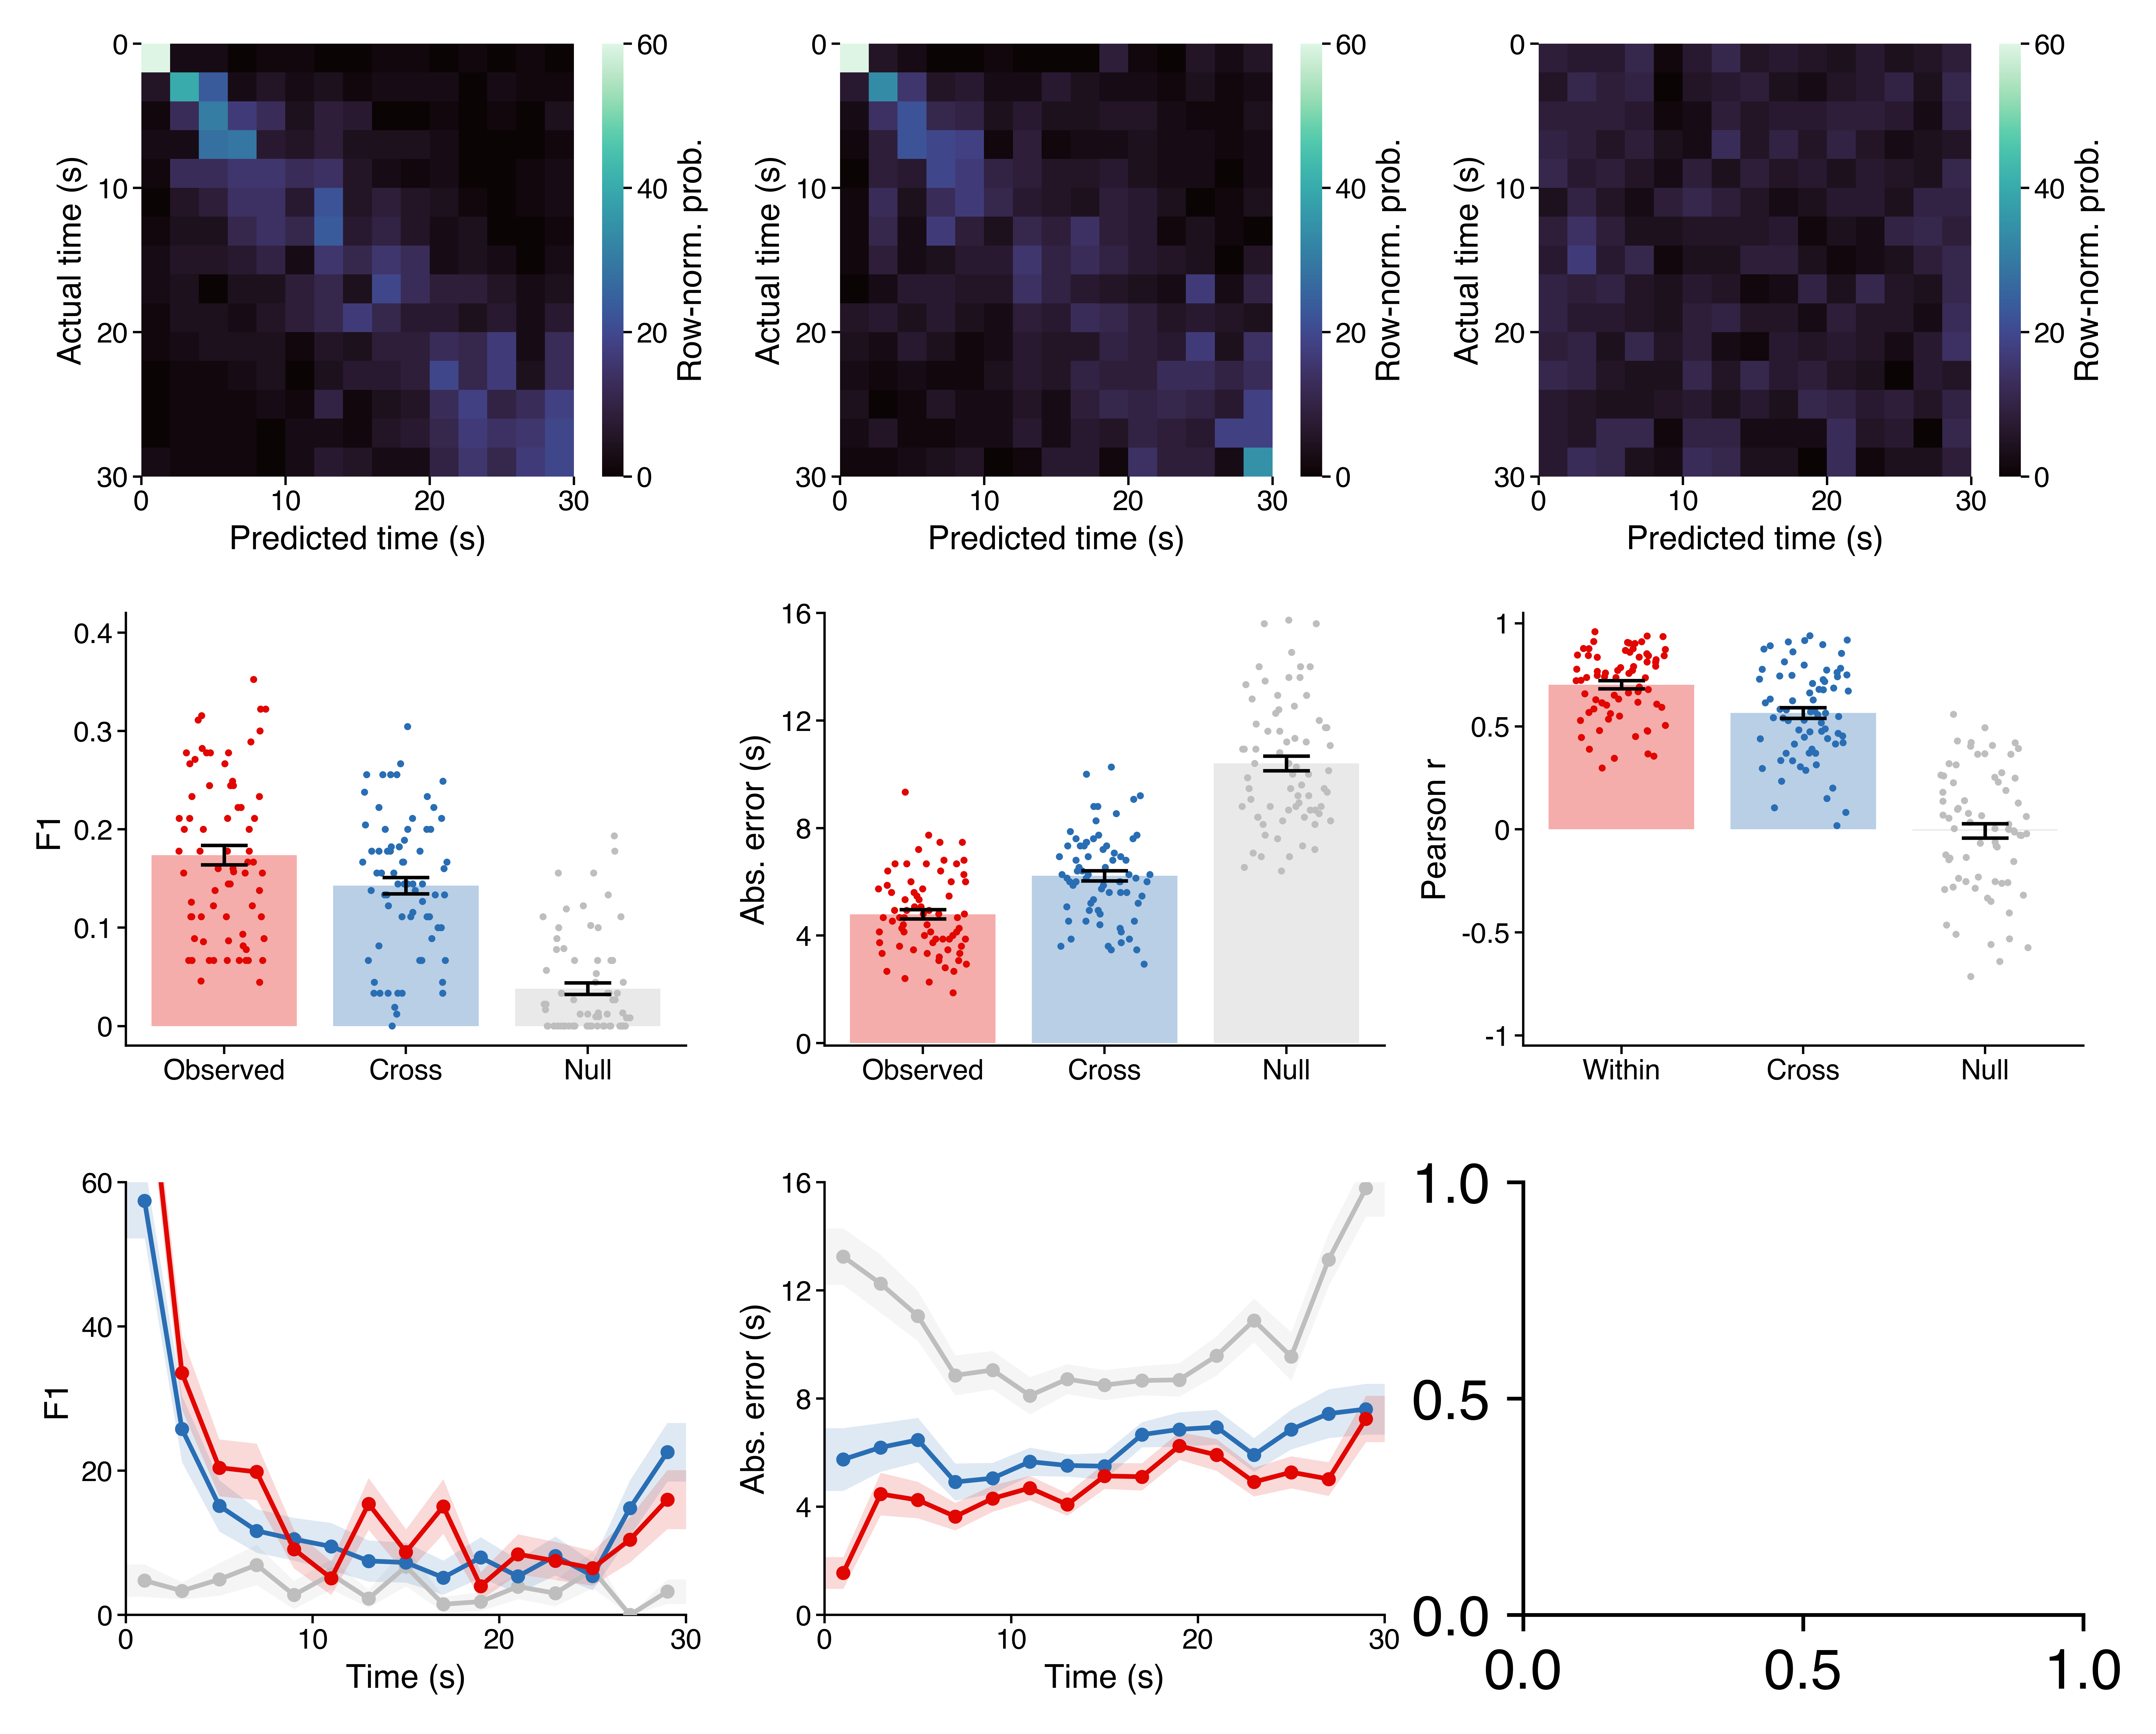

In [24]:
# !!!!!!!!!!!!
savefig = 0
overwrite = 0
verbose = 1
sep_conf_mats = False
if gs_steps[game_states[0]] == 5:
    ymin_acc = -0.02
    ymax_acc = 1.05
    yticks_acc = [0, .25, .5, .75, 1]
    ymin_acc_time = 0
    ymax_acc_time = 0.75
    yticks_acc_time = [0, .25, .5, .75]
    yerr_mult = 2
    ymin_error = -0.1
    ymax_error = 6
    yticks_error = [0, 2, 4, 6]
    ymin_error_time = 0
    ymax_error_time = 5
    yticks_error_time = [0, 2.5, 5]
    ymin_corr = -1.05
    ymax_corr = 1.05
    yticks_corr = [-1, -0.5, 0, 0.5, 1]
    vmin = 0
    vmax = 60
    cbar_ticks = [0, 20, 40, 60]
elif gs_steps[game_states[0]] == 15:
    ymin_acc = -0.02
    ymax_acc = .42
    yticks_acc = [0, .1, .2, .3, .4]
    ymin_acc_time = 0
    ymax_acc_time = 0.6
    yticks_acc_time = [0, .2, .4, .6]
    yerr_mult = 2
    ymin_error = -0.1
    ymax_error = 16
    yticks_error = [0, 4, 8, 12, 16]
    ymin_error_time = 0
    ymax_error_time = 16
    yticks_error_time = [0, 4, 8, 12, 16]
    ymin_corr = -1.05
    ymax_corr = 1.05
    yticks_corr = [-1, -0.5, 0, 0.5, 1]
    vmin = 0
    vmax = 60
    cbar_ticks = [0, 20, 40, 60]

figsize = (colws[2]*2, colws[2]*1.6)
dpi = 1200
font = {'tick': 6, 'label': 7, 'fig': 11, 'annot': 6}
spine_lw = 0.5
spine_len = 1.8
labelpad = 2
add_cbar = True
plot_decode = True
plot_xdecode = True
plot_null = True
alpha = 0.15
linewidth = 1
ebar_lw = 0.75
fliersize = 1.5
_cmap = 'mako'

# -----------------------------------------
plt.close()
fig, ax = plt.subplots(3, 3, dpi=dpi, figsize=figsize)
ax = np.ravel(ax)
iax = -1

print('{}\n{}'.format(', '.join(game_states), '-' * len(', '.join(game_states))))
clf_dat = clf_results.query("(gameState=={})".format(game_states)).copy()
xclf_dat = xclf_results.query("(gameState=={})".format(game_states)).copy()
clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
n_test = 1

# Run stats.
metric_cols = ['recall', 'precision', 'f1', 'abs_error', 'corr']
for metric_col in metric_cols:
    metric_col_null = '{}_null'.format(metric_col)
    _min = clf_dat[metric_col].apply(np.mean).min()
    _max = clf_dat[metric_col].apply(np.mean).max()
    _mean = clf_dat[metric_col].apply(np.mean).mean()
    _sem = stats.sem(clf_dat[metric_col].apply(np.mean))
    _xmin = xclf_dat[metric_col].apply(np.mean).min()
    _xmax = xclf_dat[metric_col].apply(np.mean).max()
    _xmean = xclf_dat[metric_col].apply(np.mean).mean()
    _xsem = stats.sem(xclf_dat[metric_col].apply(np.mean))
    _min_null = clf_dat[metric_col_null].apply(np.mean).min()
    _max_null = clf_dat[metric_col_null].apply(np.mean).max()
    _mean_null = clf_dat[metric_col_null].apply(np.mean).mean()
    _sem_null = stats.sem(clf_dat[metric_col_null].apply(np.mean))
    _xmin_null = xclf_dat[metric_col_null].apply(np.mean).min()
    _xmax_null = xclf_dat[metric_col_null].apply(np.mean).max()
    _xmean_null = xclf_dat[metric_col_null].apply(np.mean).mean()
    _xsem_null = stats.sem(xclf_dat[metric_col_null].apply(np.mean))
    print(metric_col,
          'within-decoding: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_mean, _sem, _min, _max),
          'cross-decoding: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_xmean, _xsem, _xmin, _xmax),
          'within null: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_mean_null, _sem_null, _min_null, _max_null),
          'cross null: {:.2f} ± {:.3f}, min = {:.2f}, max = {:.2f}'.format(_xmean_null, _xsem_null, _xmin_null, _xmax_null),
          sep='\n')
    ttests = od([('within_vs_null', stats.ttest_rel(clf_dat[metric_col].apply(np.mean), clf_dat[metric_col_null].apply(np.mean))),
                 ('cross_vs_null', stats.ttest_rel(xclf_dat[metric_col].apply(np.mean), xclf_dat[metric_col_null].apply(np.mean))),
                 ('within_vs_cross', stats.ttest_rel(clf_dat[metric_col].apply(np.mean), xclf_dat[metric_col].apply(np.mean)))
                ])
    dof = len(clf_dat) - 1
    pvals_holm = sm.stats.multipletests([_test[1] for _test in ttests.values()], alpha=0.05, method='holm')
    for iTest, _test in enumerate(ttests):
        ttests[_test] = {'tstat': ttests[_test][0],
                         'pval': ttests[_test][1],
                         'pval_holm': pvals_holm[1][iTest],
                         'sig_holm': pvals_holm[0][iTest]}
        print('{}: T({}) = {:.1f}, P = {:.6f}, P_holm = {:.6f}, reject = {}'
              .format(_test,
                      dof,
                      ttests[_test]['tstat'],
                      ttests[_test]['pval'],
                      ttests[_test]['pval_holm'],
                      ttests[_test]['sig_holm']))
    print('')
    
# Make plots.
if sep_conf_mats:
    for iState, game_state in enumerate(game_states):
        clf_dat = clf_results.query("(gameState=='{}')".format(game_state)).copy()
        xclf_dat = xclf_results.query("(gameState=='{}')".format(game_state)).copy()
        clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
        xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
        clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
        xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
        n_time_steps = clf_dat.iloc[0]['n_time_steps']
        reshp = [n_test, n_time_steps]
        if game_state[:5] == 'Delay':
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]

        # Within-state confusion matrix.
        if plot_decode:
            iax += 1
            cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
            print(cmat.max())
            vmin = vmin
            vmax = vmax
            ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
            ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
            _xticks = xticks
            ax[iax].set_xlim((_xticks.min(), _xticks.max()))
            ax[iax].set_xticks(_xticks)
            ax[iax].set_xticklabels(xticklabels)
            ax[iax].set_yticks(ax[iax].get_xticks())
            ax[iax].set_yticklabels(ax[iax].get_xticklabels())
            ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
            ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
            if add_cbar:
                cbar = ax[iax].collections[0].colorbar
                cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
                cbar.set_ticks(cbar_ticks)
                cbar.set_ticklabels(cbar_ticks)
                cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
            else:
                ax[iax].collections[0].colorbar.remove()

        # Cross-decoder confusion matrix.
        if plot_xdecode:
            iax += 1
            cmat = np.mean(xclf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
            print(cmat.max())
            vmin = vmin
            vmax = vmax
            ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
            ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
            _xticks = xticks
            ax[iax].set_xlim((_xticks.min(), _xticks.max()))
            ax[iax].set_xticks(_xticks)
            ax[iax].set_xticklabels(xticklabels)
            ax[iax].set_yticks(ax[iax].get_xticks())
            ax[iax].set_yticklabels(ax[iax].get_xticklabels())
            ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
            ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
            if add_cbar:
                cbar = ax[iax].collections[0].colorbar
                cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
                cbar.set_ticks(cbar_ticks)
                cbar.set_ticklabels(cbar_ticks)
                cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
            else:
                ax[iax].collections[0].colorbar.remove()

clf_dat = clf_results.query("(gameState=={})".format(game_states)).copy()
xclf_dat = xclf_results.query("(gameState=={})".format(game_states)).copy()
clf_dat['abs_error'] = clf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error'] = xclf_dat['abs_error'].apply(lambda x: list(np.array(x) * yerr_mult))
clf_dat['abs_error_null'] = clf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
xclf_dat['abs_error_null'] = xclf_dat['abs_error_null'].apply(lambda x: list(np.array(x) * yerr_mult))
n_time_steps = clf_results.iloc[0]['n_time_steps']

if not sep_conf_mats:
    # Within-state confusion matrix.
    if plot_decode:
        iax += 1
        cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'],
                                                                normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()

    # Cross-decoder confusion matrix.
    if plot_xdecode:
        iax += 1
        cmat = np.mean(xclf_dat.apply(lambda x: confusion_matrix(x['y_test'], x['y_test_pred'],
                                                                 normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()

    # Within-state confusion matrix.
    if plot_decode:
        iax += 1
        cmat = np.mean(clf_dat.apply(lambda x: confusion_matrix(x['y_test_null'], x['y_test_pred_null'],
                                                                normalize='true'), axis=1).tolist(), axis=0) * 100
        print(cmat.max())
        vmin = vmin
        vmax = vmax
        if n_time_steps in (5, 10):
            xticks = np.linspace(0, n_time_steps, num=6)
            xticklabels = [0, 2, 4, 6, 8, 10]
        else:
            xticks = np.linspace(0, n_time_steps, num=4)
            xticklabels = [0, 10, 20, 30]
        ax[iax] = sns.heatmap(cmat, vmin=vmin, vmax=vmax, square=True, cmap=_cmap, ax=ax[iax])
        ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw, rotation=0)
        _xticks = xticks
        ax[iax].set_xlim((_xticks.min(), _xticks.max()))
        ax[iax].set_xticks(_xticks)
        ax[iax].set_xticklabels(xticklabels)
        ax[iax].set_yticks(ax[iax].get_xticks())
        ax[iax].set_yticklabels(ax[iax].get_xticklabels())
        ax[iax].set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
        ax[iax].set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
        if add_cbar:
            cbar = ax[iax].collections[0].colorbar
            cbar.ax.tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
            cbar.set_ticks(cbar_ticks)
            cbar.set_ticklabels(cbar_ticks)
            cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
        else:
            ax[iax].collections[0].colorbar.remove()
        
# F1.
iax += 1
mean_acc = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['f1'].apply(np.mean).tolist())).T,
                                   np.vstack((['cross'] * len(xclf_dat), xclf_dat['f1'].apply(np.mean).tolist())).T,
                                   np.vstack((['null'] * len(clf_dat), clf_dat['f1_null'].apply(np.mean).tolist())).T)),
                        columns=['level', 'value'])
mean_acc['level'] = mean_acc['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_acc['value'] = mean_acc['value'].astype(float)

sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_acc, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_acc, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_acc['level'].unique().size),
                 mean_acc.groupby('level')['value'].mean().values,
                 yerr=mean_acc.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Observed', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_acc, ymax_acc])
ax[iax].set_yticks(yticks_acc)
ax[iax].set_yticklabels(yticks_acc, fontsize=font['tick'])
ax[iax].set_ylabel('F1', fontsize=font['label'], labelpad=labelpad)
    
# Absolute error.
iax += 1
mean_errors = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['abs_error'].apply(np.mean).tolist())).T,
                                      np.vstack((['cross'] * len(xclf_dat), xclf_dat['abs_error'].apply(np.mean).tolist())).T,
                                      np.vstack((['null'] * len(clf_dat), clf_dat['abs_error_null'].apply(np.mean).tolist())).T)),
                           columns=['level', 'value'])
mean_errors['level'] = mean_errors['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_errors['value'] = mean_errors['value'].astype(float)
sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_errors, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_errors, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_errors['level'].unique().size), mean_errors.groupby('level')['value'].mean().values,
                 yerr=mean_errors.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Observed', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_error, ymax_error])
ax[iax].set_yticks(yticks_error)
ax[iax].set_yticklabels(yticks_error, fontsize=font['tick'])
ax[iax].set_ylabel('Abs. error (s)', fontsize=font['label'], labelpad=labelpad)
    
# Correlation between actual and predicted times.
iax += 1
mean_corrs = pd.DataFrame(np.vstack((np.vstack((['matched'] * len(clf_dat), clf_dat['corr'].tolist())).T,
                                     np.vstack((['cross'] * len(xclf_dat), xclf_dat['corr'].tolist())).T,
                                     np.vstack((['null'] * len(clf_dat), clf_dat['corr_null'].tolist())).T)),
                           columns=['level', 'value'])
mean_corrs['level'] = mean_corrs['level'].astype(pd.CategoricalDtype(['matched', 'cross', 'null'], ordered=True))
mean_corrs['value'] = mean_corrs['value'].astype(float)
sns.set_context(rc={'patch.linewidth': spine_lw})
ax[iax] = sns.barplot(x='level', y='value', data=mean_corrs, ax=ax[iax],
                      ci=None,
                      palette=['#e10600', '#296eb4', '#bebebe'],
                      saturation=1, alpha=0.33, zorder=0)
ax[iax] = sns.stripplot(x='level', y='value', data=mean_corrs, ax=ax[iax],
                        palette=['#e10600', '#296eb4', '#bebebe'],
                        size=fliersize, alpha=1, jitter=0.25, zorder=1)
ax[iax].errorbar(np.arange(mean_corrs['level'].unique().size),
                 mean_corrs.groupby('level')['value'].mean().values,
                 yerr=mean_corrs.groupby('level')['value'].apply(lambda x: stats.sem(x)).values,
                 ecolor='k', elinewidth=ebar_lw, capsize=5, capthick=ebar_lw, linewidth=0, zorder=2)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
ax[iax].set_xticks(np.arange(mean_acc['level'].unique().size))
ax[iax].set_xticklabels(['Within', 'Cross', 'Null'], fontsize=font['tick'])
ax[iax].set_xlabel('')
ax[iax].set_ylim([ymin_corr, ymax_corr])
ax[iax].set_yticks(yticks_corr)
ax[iax].set_yticklabels(yticks_corr, fontsize=font['tick'])
ax[iax].set_ylabel('Pearson r', fontsize=font['label'], labelpad=labelpad)

# F1 by time.
iax += 1
if plot_decode:
    _means = np.mean(clf_dat['f1'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['f1'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#e10600', linewidth=0, alpha=alpha, zorder=2)
    ax[iax].plot(xvals, _means, color='#e10600', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=5)
if plot_xdecode:
    _means = np.mean(xclf_dat['f1'].tolist(), axis=0)
    _sems = stats.sem(xclf_dat['f1'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#296eb4', linewidth=0, alpha=alpha, zorder=1)
    ax[iax].plot(xvals, _means, color='#296eb4', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=4)
if plot_null:
    _means = np.mean(clf_dat['f1_null'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['f1_null'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#bebebe', linewidth=0, alpha=alpha, zorder=0)
    ax[iax].plot(xvals, _means, color='#bebebe', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=3)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
_xticks = xticks - 0.5
ax[iax].set_xlim([-0.5, xvals.size-0.5])
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylim([ymin_acc_time, ymax_acc_time])
ax[iax].set_yticks(yticks_acc_time)
ax[iax].set_yticklabels([int(x*100) for x in yticks_acc_time], fontsize=font['tick'])
ax[iax].set_ylabel('F1', fontsize=font['label'], labelpad=labelpad)

# Error distance by time.
iax += 1
if plot_decode:
    _means = np.mean(clf_dat['abs_error'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['abs_error'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#e10600', linewidth=0, alpha=alpha, zorder=2)
    ax[iax].plot(xvals, _means, color='#e10600', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=5)
if plot_xdecode:
    _means = np.mean(xclf_dat['abs_error'].tolist(), axis=0)
    _sems = stats.sem(xclf_dat['abs_error'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#296eb4', linewidth=0, alpha=alpha, zorder=1)
    ax[iax].plot(xvals, _means, color='#296eb4', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=4)
if plot_null:
    _means = np.mean(clf_dat['abs_error_null'].tolist(), axis=0)
    _sems = stats.sem(clf_dat['abs_error_null'].tolist(), axis=0)
    xvals = np.arange(len(_means))
    _xvals = np.concatenate([(xvals[0]-0.5,), xvals, (xvals[-1]+0.5,)])
    __means = np.concatenate([(_means[0],), _means, (_means[-1],)])
    __sems = np.concatenate([(_sems[0],), _sems, (_sems[-1],)])
    ax[iax].fill_between(_xvals, __means + __sems, __means - __sems,
                         color='#bebebe', linewidth=0, alpha=alpha, zorder=0)
    ax[iax].plot(xvals, _means, color='#bebebe', linewidth=linewidth,
                 linestyle='-', marker='o', markersize=font['annot']/3, zorder=3)
for axis in ['left', 'bottom']:
    ax[iax].spines[axis].set_linewidth(spine_lw)
ax[iax].tick_params(labelsize=font['tick'], pad=1, length=spine_len, width=spine_lw)
_xticks = xticks - 0.5
ax[iax].set_xlim([-0.5, xvals.size-0.5])
ax[iax].set_xticks(_xticks)
ax[iax].set_xticklabels(xticklabels)
ax[iax].set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
ax[iax].set_ylim([ymin_error_time, ymax_error_time])
ax[iax].set_yticks(yticks_error_time)
ax[iax].set_yticklabels(yticks_error_time, fontsize=font['tick'])
ax[iax].set_ylabel('Abs. error (s)', fontsize=font['label'], labelpad=labelpad)
        
fig.tight_layout(pad=0.25, h_pad=1)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}bins.pdf'
                       .format(n_units, unit_group, game_states[0], n_time_steps, game_states[1], n_time_steps))
    if overwrite or not op.exists(filename):
        fig.savefig(filename, format='pdf', bbox_inches='tight')
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight')
        
fig.show()

# Delay: within, cross-delay results; all neurons, time cells, non-time cells

In [182]:
# Load within- and cross-classifier results for all neurons,
# only time cells, and only non-time cells.
game_states = ['Delay1', 'Delay2']
unit_groups = od([('all', 457),
                  ('timeAll', 115),
                  ('timeNo', 342)])
gs_steps = {'Delay1': 5, 'Delay2': 5, 'Encoding': 15, 'Retrieval': 15}

# ---------------------
timer = Timer()
warnings.filterwarnings('ignore')
fglobs = od([('within', op.join(proj_dir, 'analysis', 'classifiers',
                                'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}*bins.pkl')),
             ('cross', op.join(proj_dir, 'analysis', 'classifiers',
                               'SVC_predicting_time_step-{}units_{}-random_search-36fold-cross_decoding-{}_{}bins-{}_{}*bins.pkl'))])

clf_results = []
for unit_group, n_units in unit_groups.items():
    for clf_cat, fglob in fglobs.items():
        fpath = fglob.format(n_units, unit_group, game_states[0], gs_steps[game_states[0]], game_states[1], gs_steps[game_states[1]])
        glob_res = glob(fpath)
        assert len(glob_res) == 1
        clf_results.append(dio.open_pickle(glob_res[0]))
        
        # Drop columns that we don't need.
        drop_cols = ['unit_group', 'mean_acc', 'acc_by_time', 'accuracy', 'clf',
                     'mean_acc_null', 'acc_by_time_null', 'accuracy_null', 'clf_null',
                     'best_trainval_score', 'best_trainval_C', 'best_trainval_gamma',
                     'best_trainval_score_null', 'best_trainval_C_null', 'best_trainval_gamma_null']
        _drop_cols = [col for col in drop_cols if col in clf_results[-1].columns]
        if len(_drop_cols) > 0:
            clf_results[-1].drop(columns=_drop_cols, inplace=True)
        
        # Align gameState column naming across dataframes.
        if clf_cat == 'within':
            clf_results[-1].rename(columns={'gameState': 'gameState_train'}, inplace=True)
            clf_results[-1].insert(clf_results[-1].columns.tolist().index('gameState_train') + 1,
                                   'gameState_test',
                                   clf_results[-1]['gameState_train'])
        
        # Restrict rows to game states of interest.
        clf_results[-1] = clf_results[-1].query("(gameState_train=={})".format(game_states))
        
        # Add unique identifying columns.
        clf_results[-1].insert(0, 'unit_group', unit_group)
        clf_results[-1].insert(1, 'n_units', n_units)
        clf_results[-1].insert(2, 'clf_cat', clf_cat)
        
        # Resort y_test_null and y_test_pred_null on the values within each y_test_null test trial.
        for col in ['y_test_pred_null', 'y_test_null']:
            clf_results[-1][col] = clf_results[-1].apply(lambda x: sort_onto(x['y_test_null'],
                                                                             x[col],
                                                                             len(x['test_trials'])),
                                                         axis=1)
        
        # Calculate performance metrics.
        if gs_steps[game_states[0]] in (5, 15):
            err_mult = 2
        else:
            err_mult = 1
        clf_results[-1]['recall'] = clf_results[-1].apply(
            lambda x: metrics.recall_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
        clf_results[-1]['precision'] = clf_results[-1].apply(
            lambda x: metrics.precision_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
        clf_results[-1]['f1'] = clf_results[-1].apply(
            lambda x: metrics.f1_score(x['y_test'], x['y_test_pred'], average=None).tolist(), axis=1)
        clf_results[-1]['error'] = clf_results[-1].apply(
            lambda x: clf_error(x['y_test'], x['y_test_pred'], err_mult), axis=1)
        clf_results[-1]['abs_error'] = clf_results[-1].apply(
            lambda x: np.abs(x['error']).tolist(), axis=1)
        clf_results[-1]['corr'] = clf_results[-1].apply(
            lambda x: stats.pearsonr(x['y_test_pred'], x['y_test'])[0], axis=1).fillna(0)
        clf_results[-1]['recall_null'] = clf_results[-1].apply(
            lambda x: metrics.recall_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
        clf_results[-1]['precision_null'] = clf_results[-1].apply(
            lambda x: metrics.precision_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
        clf_results[-1]['f1_null'] = clf_results[-1].apply(
            lambda x: metrics.f1_score(x['y_test_null'], x['y_test_pred_null'], average=None).tolist(), axis=1)
        clf_results[-1]['error_null'] = clf_results[-1].apply(
            lambda x: clf_error(x['y_test_null'], x['y_test_pred_null'], err_mult), axis=1)
        clf_results[-1]['abs_error_null'] = clf_results[-1].apply(
            lambda x: np.abs(x['error_null']).tolist(), axis=1)
        clf_results[-1]['corr_null'] = clf_results[-1].apply(
            lambda x: stats.pearsonr(x['y_test_pred_null'], x['y_test_null'])[0], axis=1).fillna(0)
        
clf_results = pd.concat(clf_results, axis=0).reset_index(drop=True)

warnings.resetwarnings()
print('clf_results: {}'.format(clf_results.shape))
print(timer)

clf_results: (432, 23)
Ran in 3.6s


In [173]:
stats.ttest_rel(clf_results.query("(unit_group=='all') & (clf_cat=='within')")['abs_error'].apply(np.mean).tolist(),
                clf_results.query("(unit_group=='timeAll') & (clf_cat=='within')")['abs_error'].apply(np.mean).tolist())

Ttest_relResult(statistic=2.77985226593463, pvalue=0.0069562165547066524)

In [174]:
stats.ttest_rel(clf_results.query("(unit_group=='timeNo') & (clf_cat=='within')")['abs_error'].apply(np.mean).tolist(),
                clf_results.query("(unit_group=='timeNo') & (clf_cat=='within')")['abs_error_null'].apply(np.mean).tolist())

Ttest_relResult(statistic=-1.69180277423301, pvalue=0.09506848113698853)

In [183]:
stats.ttest_rel(clf_results.query("(unit_group=='timeAll') & (clf_cat=='within')")['abs_error'].apply(np.mean).tolist(),
                clf_results.query("(unit_group=='timeAll') & (clf_cat=='cross')")['abs_error'].apply(np.mean).tolist())

Ttest_relResult(statistic=-1.8415573550400695, pvalue=0.06971689295955875)

In [184]:
stats.ttest_rel(clf_results.query("(unit_group=='all') & (clf_cat=='within')")['abs_error'].apply(np.mean).tolist(),
                clf_results.query("(unit_group=='all') & (clf_cat=='cross')")['abs_error'].apply(np.mean).tolist())

Ttest_relResult(statistic=-2.908016583909036, pvalue=0.004851085759433219)

Saving SVC_predicting_time_step-457units_all-115units_timeAll-342units_timeNo-random_search-36fold-Delay1_5bins-Delay2_5bins-pred_error_over_time.pdf


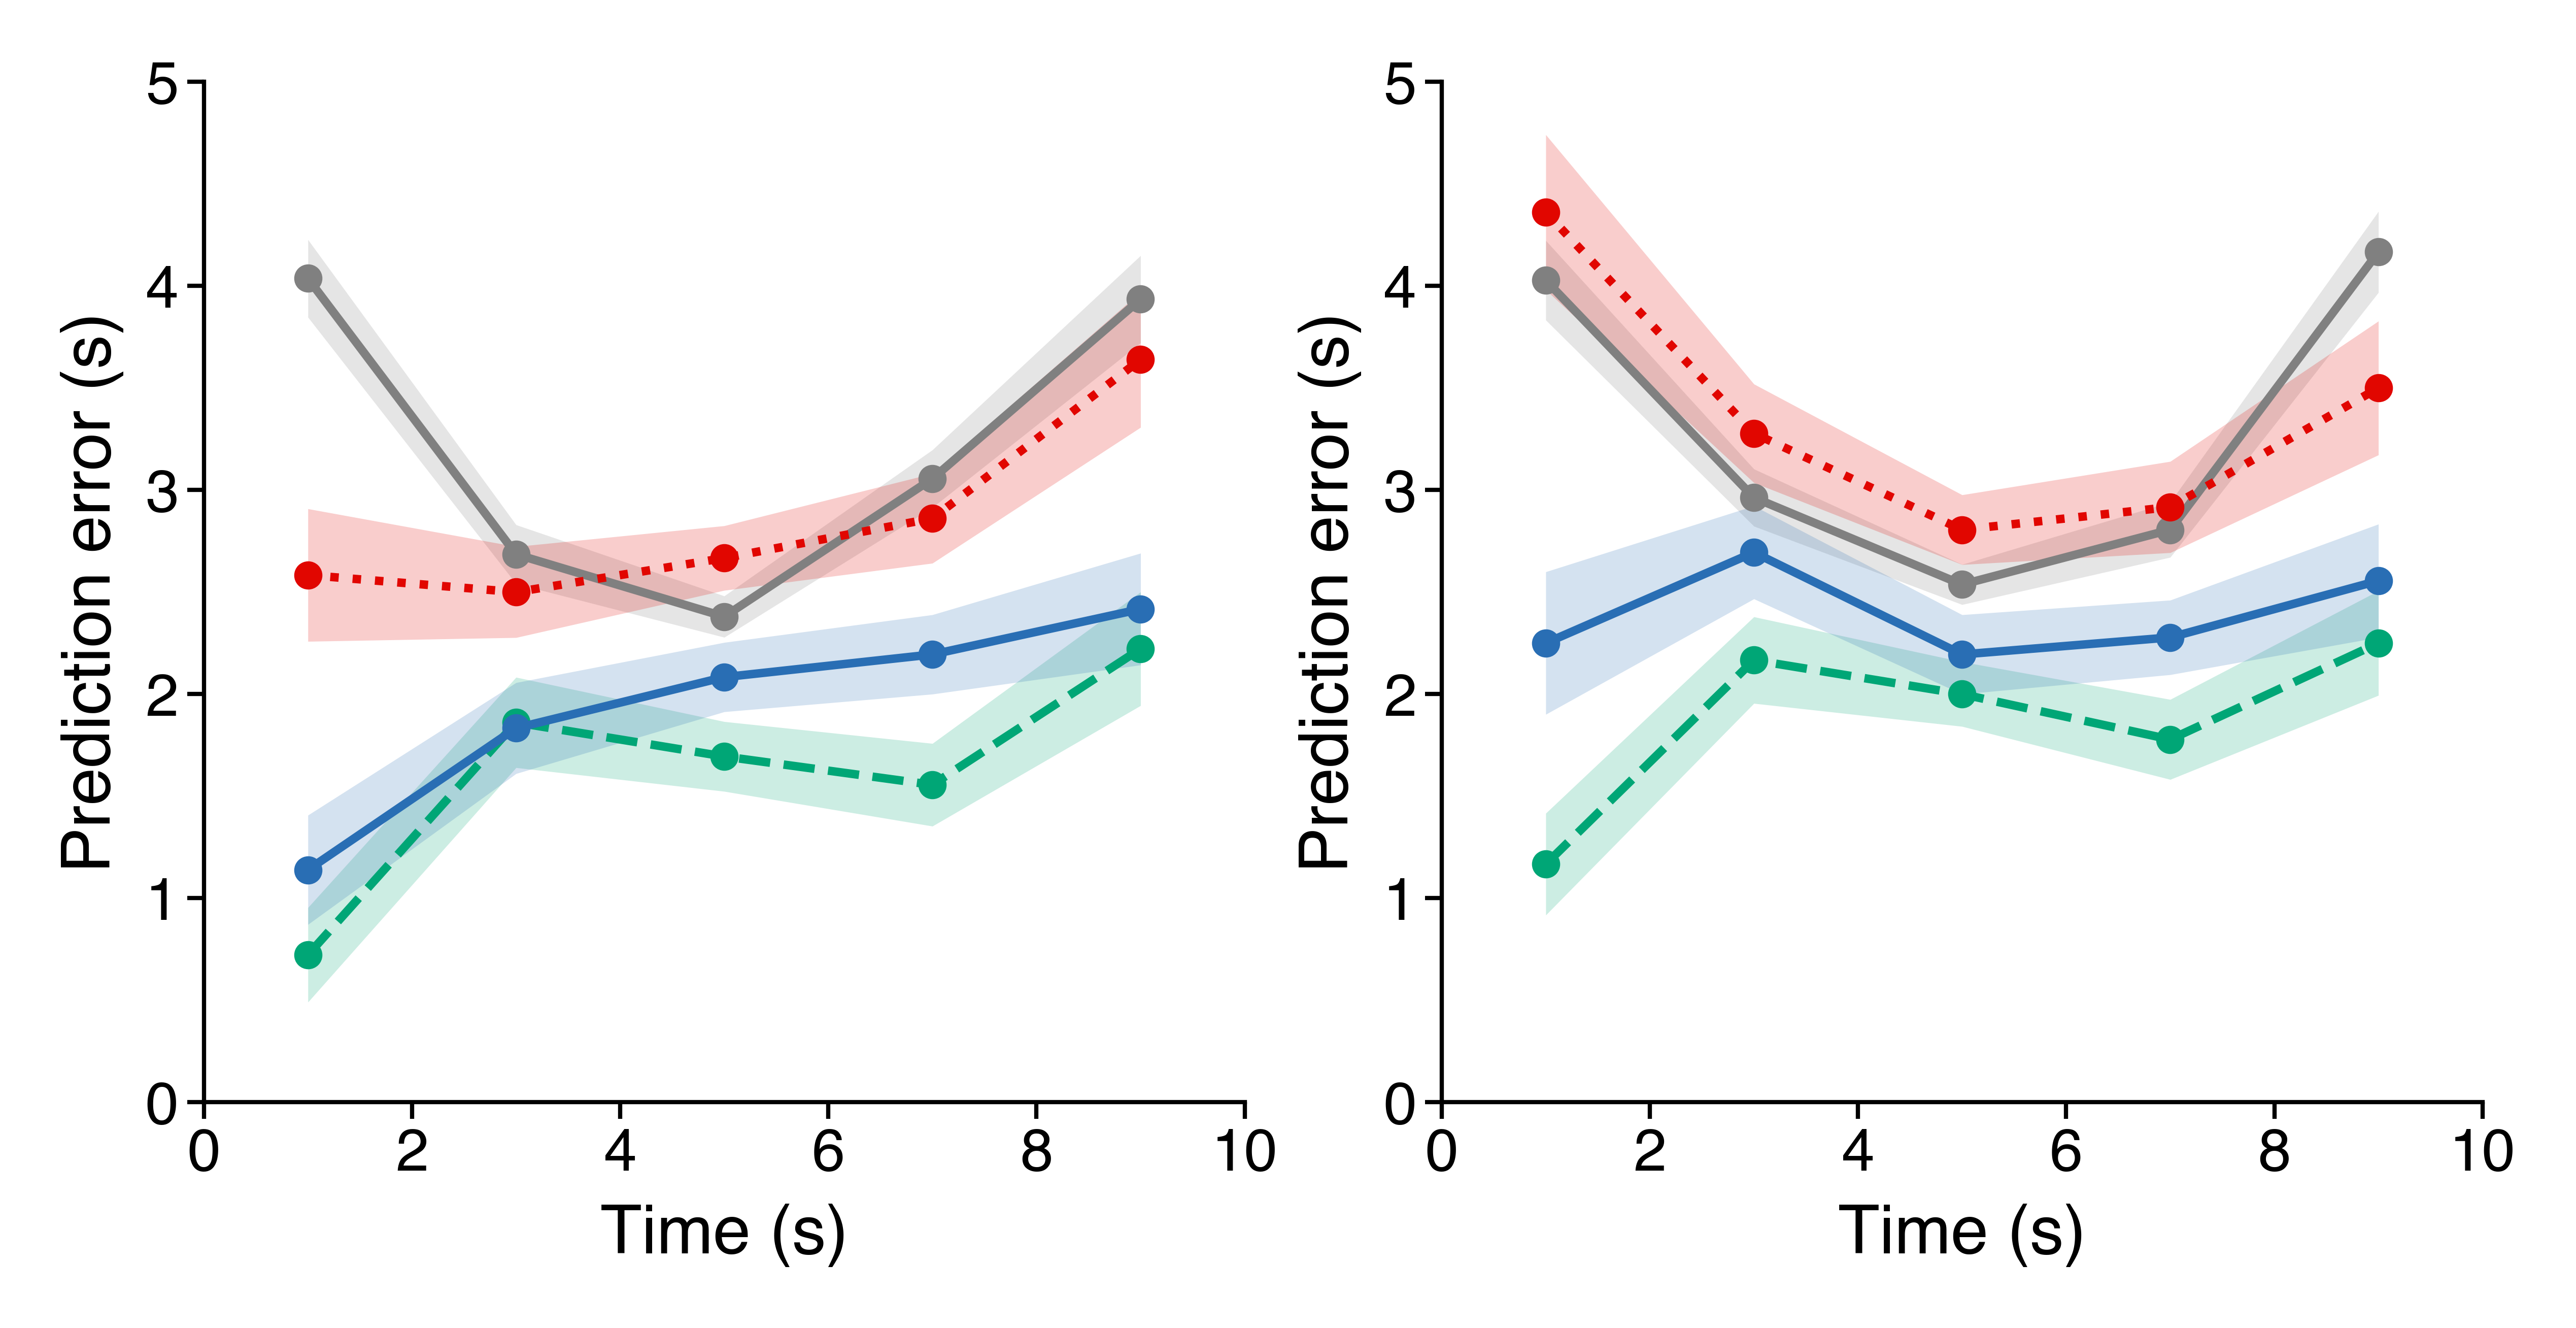

In [150]:
game_states = ['Delay1', 'Delay2']
savefig = 1
overwrite = 0
if 'Delay' in game_states[0]:
    ymin_error_time = 0
    ymax_error_time = 5
    yticks_error_time = [0, 1, 2, 3, 4, 5]
else:
    ymin_error_time = 0
    ymax_error_time = 16
    yticks_error_time = [0, 4, 8, 12, 16]
figsize = (colws[1]*2, colws[1])
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
dpi = 1200
spine_lw = 0.5
spine_len = 2
tickpad = 1
labelpad = 2.5
alpha = 0.2
linewidth = 1
linestyles = {'timeNo': 'dotted',
              'timeAll': '--',
              'all': '-'}
# colors = {'null': '#808080',
#           'within': '#e10600',
#           'cross': '#296eb4'}
colors = {'null': '#808080',
          'timeNo': '#e10600',
          'timeAll': '#00A676',
          'all': '#296eb4'}

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_clf_results = clf_results.query("(clf_cat=='within')")
means = np.mean(_clf_results['abs_error_null'].tolist(), axis=0)
sems = stats.sem(_clf_results['abs_error_null'].tolist(), axis=0)
xvals = np.arange(means.size)
_ax.fill_between(xvals, means + sems, means - sems,
                 color=colors['null'], linewidth=0, alpha=alpha)
_ax.plot(xvals, means, color=colors['null'], linewidth=linewidth,
         linestyle='-', marker='o', markersize=font['annot']/3)

for unit_group in ['timeNo', 'timeAll', 'all']:
    for clf_cat in ['within']:
        _clf_results = clf_results.query("(unit_group=='{}') & (clf_cat=='{}')".format(unit_group, clf_cat))
        means = np.mean(_clf_results['abs_error'].tolist(), axis=0)
        sems = stats.sem(_clf_results['abs_error'].tolist(), axis=0)
        xvals = np.arange(means.size)
        _ax.fill_between(xvals, means + sems, means - sems,
                         color=colors[unit_group], linewidth=0, alpha=alpha)
        _ax.plot(xvals, means,
                 color=colors[unit_group], linestyle=linestyles[unit_group],
                 linewidth=linewidth, marker='o', markersize=font['annot']/3)

iax = 1
_ax = ax[iax]
_clf_results = clf_results.query("(clf_cat=='cross')")
means = np.mean(_clf_results['abs_error_null'].tolist(), axis=0)
sems = stats.sem(_clf_results['abs_error_null'].tolist(), axis=0)
xvals = np.arange(means.size)
_ax.fill_between(xvals, means + sems, means - sems,
                 color=colors['null'], linewidth=0, alpha=alpha)
_ax.plot(xvals, means, color=colors['null'], linewidth=linewidth,
         linestyle='-', marker='o', markersize=font['annot']/3)

for unit_group in ['timeNo', 'timeAll', 'all']:
    for clf_cat in ['cross']:
        _clf_results = clf_results.query("(unit_group=='{}') & (clf_cat=='{}')".format(unit_group, clf_cat))
        means = np.mean(_clf_results['abs_error'].tolist(), axis=0)
        sems = stats.sem(_clf_results['abs_error'].tolist(), axis=0)
        xvals = np.arange(means.size)
        _ax.fill_between(xvals, means + sems, means - sems,
                         color=colors[unit_group], linewidth=0, alpha=alpha)
        _ax.plot(xvals, means,
                 color=colors[unit_group], linestyle=linestyles[unit_group],
                 linewidth=linewidth, marker='o', markersize=font['annot']/3)
        
# Plot params.
if 'Delay' in game_states[0]:
    xticks = np.linspace(0, gs_steps[game_states[0]], num=6)
    xticklabs = [0, 2, 4, 6, 8, 10]
else:
    xticks = np.linspace(0, gs_steps[game_states[0]], num=4)
    xticklabs = [0, 10, 20, 30]
for _ax in ax:
    for axis in ['left', 'bottom']:
        _ax.spines[axis].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
    _xticks = xticks - 0.5
    _ax.set_xlim([-0.5, xvals.size-0.5])
    _ax.set_xticks(_xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylim([ymin_error_time, ymax_error_time])
    _ax.set_yticks(yticks_error_time)
    _ax.set_yticklabels(yticks_error_time, fontsize=font['tick'])
    _ax.set_ylabel('Prediction error (s)', fontsize=font['label'], labelpad=labelpad)

fig.tight_layout(pad=0.25, h_pad=1)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-{}-random_search-36fold-{}_{}bins-{}_{}bins-pred_error_over_time.pdf'
                       .format('-'.join(['{}units_{}'.format(unit_groups[unit_group], unit_group) for unit_group in unit_groups]),
                               game_states[0], gs_steps[game_states[0]], game_states[1], gs_steps[game_states[1]]))
    if overwrite or not op.exists(filename):
        print('Saving {}'.format(op.basename(filename)))
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()

within max: 84.7
cross max: 73.6
Saving SVC_predicting_time_step-115units_timeAll-random_search-36fold-Delay1_5bins-Delay2_5bins-confusion_mats.pdf


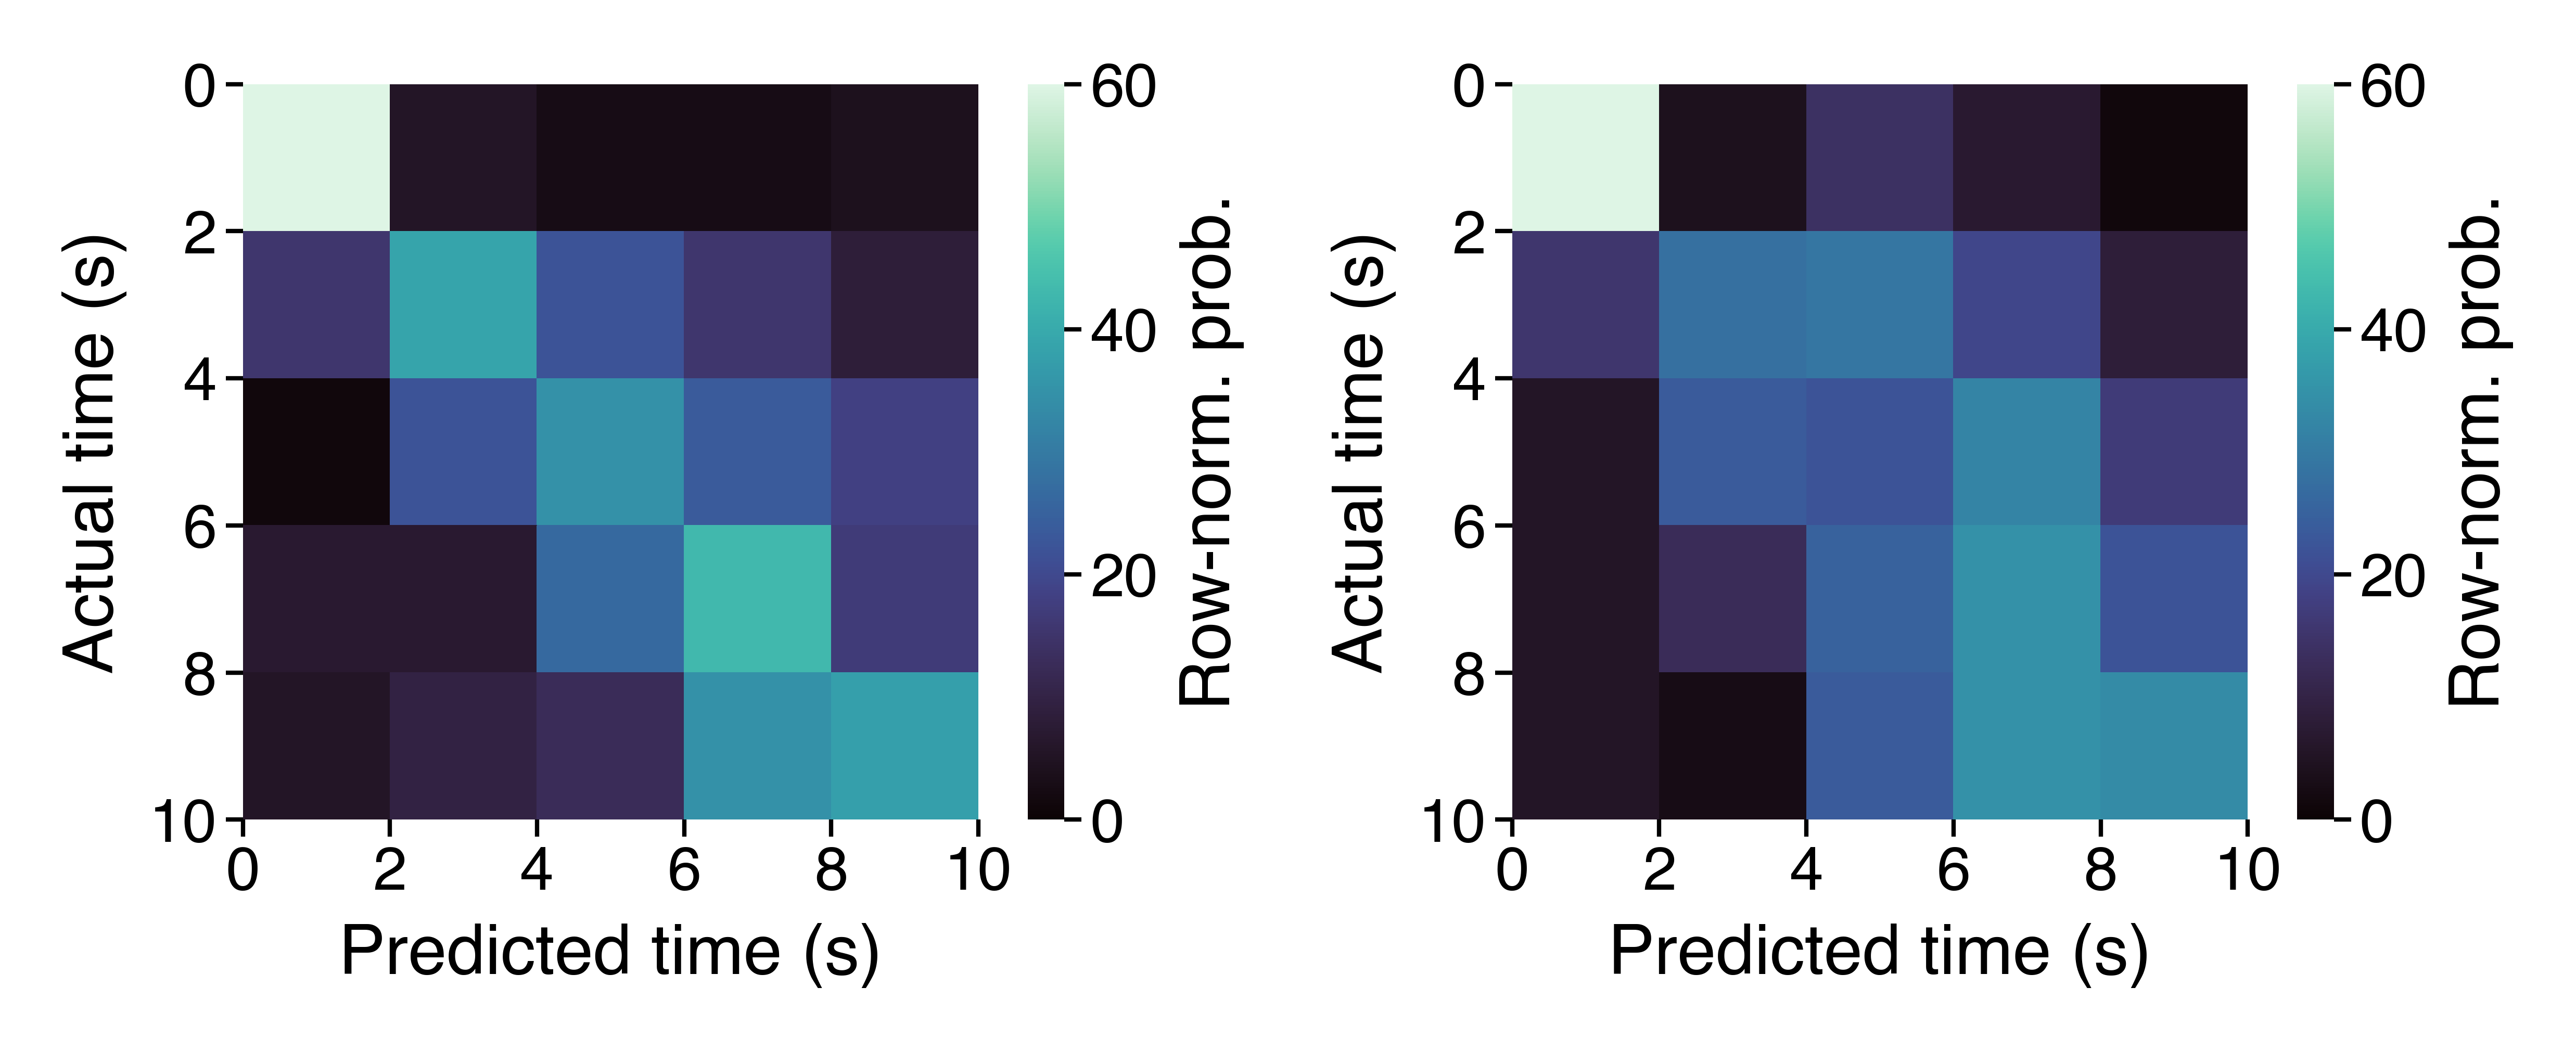

In [153]:
game_states = ['Delay1', 'Delay2']
savefig = 1
overwrite = 0
figsize = (colws[1]*2, colws[1]*.75)
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
dpi = 1200
spine_lw = 0.5
spine_len = 2
tickpad = 1
labelpad = 2.5
cmap = 'mako'
vmin = 0
vmax = 60
add_cbar = True
cbar_ticks = [0, 20, 40, 60]
unit_group = 'timeAll'

# -----------------------
plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for iax, clf_cat in enumerate(['within', 'cross']):
    _ax = ax[iax]
    _clf_results = clf_results.query("(unit_group=='{}') & (clf_cat=='{}')".format(unit_group, clf_cat))
    cmat = np.mean(_clf_results.apply(lambda x: confusion_matrix(
        x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
    print('{} max: {:.1f}'.format(clf_cat, cmat.max()))
    _ax = sns.heatmap(cmat, vmin=vmin, vmax=vmax, cmap=cmap, square=True, ax=_ax)
    
    
    # Plot params.
    if 'Delay' in game_states[0]:
        xticks = np.linspace(0, cmat.shape[0], num=6)
        xticklabels = [0, 2, 4, 6, 8, 10]
    else:
        xticks = np.linspace(0, cmat.shape[0], num=4)
        xticklabels = [0, 10, 20, 30]
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw, rotation=0)
    _xticks = xticks
    _ax.set_xlim((_xticks.min(), _xticks.max()))
    _ax.set_xticks(_xticks)
    _ax.set_xticklabels(xticklabels)
    _ax.set_yticks(_ax.get_xticks())
    _ax.set_yticklabels(_ax.get_xticklabels())
    _ax.set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
    if add_cbar:
        cbar = _ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticks)
        cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
    else:
        _ax.collections[0].colorbar.remove()

fig.tight_layout(pad=0.25, h_pad=1)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}bins-confusion_mats.pdf'
                       .format(unit_groups[unit_group], unit_group, game_states[0], gs_steps[game_states[0]],
                               game_states[1], gs_steps[game_states[1]]))
    if overwrite or not op.exists(filename):
        print('Saving {}'.format(op.basename(filename)))
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()

# Nav: within, cross-delay results; all neurons, time cells, non-time cells

In [175]:
# Load within- and cross-classifier results for all neurons,
# only time cells, and only non-time cells.
game_states = ['Encoding', 'Retrieval']
unit_groups = od([('all', 457),
                  ('timeAll', 119),
                  ('timeNo', 338)])
gs_steps = {'Delay1': 5, 'Delay2': 5, 'Encoding': 15, 'Retrieval': 15}

# ---------------------
timer = Timer()
warnings.filterwarnings('ignore')
fglobs = od([('within', op.join(proj_dir, 'analysis', 'classifiers',
                                'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}bins.pkl')),
             ('cross', op.join(proj_dir, 'analysis', 'classifiers',
                               'SVC_predicting_time_step-{}units_{}-random_search-36fold-cross_decoding-*{}_{}bins-{}_{}bins.pkl'))])

clf_results = []
for unit_group, n_units in unit_groups.items():
    for clf_cat, fglob in fglobs.items():
        fpath = fglob.format(n_units, unit_group, game_states[0], gs_steps[game_states[0]], game_states[1], gs_steps[game_states[1]])
        glob_res = glob(fpath)
        if (unit_group=='all') & (clf_cat=='within'):
            glob_res = [op.join(proj_dir, 'analysis', 'classifiers',
                'SVC_predicting_time_step-457units_all-random_search-36fold-Delay1_5bins-Delay2_5bins-Encoding_15bins-Retrieval_15bins.pkl')]
        assert len(glob_res) == 1
        clf_results.append(dio.open_pickle(glob_res[0]))
        
        # Drop columns that we don't need.
        drop_cols = ['unit_group', 'mean_acc', 'acc_by_time', 'accuracy', 'clf',
                     'mean_acc_null', 'acc_by_time_null', 'accuracy_null', 'clf_null',
                     'best_trainval_score', 'best_trainval_C', 'best_trainval_gamma',
                     'best_trainval_score_null', 'best_trainval_C_null', 'best_trainval_gamma_null']
        _drop_cols = [col for col in drop_cols if col in clf_results[-1].columns]
        if len(_drop_cols) > 0:
            clf_results[-1].drop(columns=_drop_cols, inplace=True)
        
        # Align gameState column naming across dataframes.
        if clf_cat == 'within':
            clf_results[-1].rename(columns={'gameState': 'gameState_train'}, inplace=True)
            clf_results[-1].insert(clf_results[-1].columns.tolist().index('gameState_train') + 1,
                                   'gameState_test',
                                   clf_results[-1]['gameState_train'])
        
        # Restrict rows to game states of interest.
        clf_results[-1] = clf_results[-1].query("(gameState_train=={})".format(game_states))
        
        # Add unique identifying columns.
        clf_results[-1].insert(0, 'unit_group', unit_group)
        clf_results[-1].insert(1, 'n_units', n_units)
        clf_results[-1].insert(2, 'clf_cat', clf_cat)
        
        # Resort y_test_null and y_test_pred_null on the values within each y_test_null test trial.
        for col in ['y_test_pred_null', 'y_test_null']:
            clf_results[-1][col] = clf_results[-1].apply(lambda x: sort_onto(x['y_test_null'],
                                                                             x[col],
                                                                             len(x['test_trials'])),
                                                         axis=1)
        
        # Calculate performance metrics.
        if gs_steps[game_states[0]] in (5, 15):
            err_mult = 2
        else:
            err_mult = 1
        clf_results[-1]['recall'] = clf_results[-1].apply(
            lambda x: metrics.recall_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
        clf_results[-1]['precision'] = clf_results[-1].apply(
            lambda x: metrics.precision_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
        clf_results[-1]['f1'] = clf_results[-1].apply(
            lambda x: metrics.f1_score(x['y_test'], x['y_test_pred'], average=None).tolist(), axis=1)
        clf_results[-1]['error'] = clf_results[-1].apply(
            lambda x: clf_error(x['y_test'], x['y_test_pred'], err_mult), axis=1)
        clf_results[-1]['abs_error'] = clf_results[-1].apply(
            lambda x: np.abs(x['error']).tolist(), axis=1)
        clf_results[-1]['corr'] = clf_results[-1].apply(
            lambda x: stats.pearsonr(x['y_test_pred'], x['y_test'])[0], axis=1).fillna(0)
        clf_results[-1]['recall_null'] = clf_results[-1].apply(
            lambda x: metrics.recall_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
        clf_results[-1]['precision_null'] = clf_results[-1].apply(
            lambda x: metrics.precision_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
        clf_results[-1]['f1_null'] = clf_results[-1].apply(
            lambda x: metrics.f1_score(x['y_test_null'], x['y_test_pred_null'], average=None).tolist(), axis=1)
        clf_results[-1]['error_null'] = clf_results[-1].apply(
            lambda x: clf_error(x['y_test_null'], x['y_test_pred_null'], err_mult), axis=1)
        clf_results[-1]['abs_error_null'] = clf_results[-1].apply(
            lambda x: np.abs(x['error_null']).tolist(), axis=1)
        clf_results[-1]['corr_null'] = clf_results[-1].apply(
            lambda x: stats.pearsonr(x['y_test_pred_null'], x['y_test_null'])[0], axis=1).fillna(0)
        
clf_results = pd.concat(clf_results, axis=0).reset_index(drop=True)

warnings.resetwarnings()
print('clf_results: {}'.format(clf_results.shape))
print(timer)

clf_results: (432, 23)
Ran in 7.8s


In [181]:
stats.ttest_rel(clf_results.query("(unit_group=='timeAll') & (clf_cat=='cross')")['abs_error'].apply(np.mean).tolist(),
                clf_results.query("(unit_group=='timeAll') & (clf_cat=='cross')")['abs_error_null'].apply(np.mean).tolist())

Ttest_relResult(statistic=-1.2227251384119417, pvalue=0.22547680832393324)

Saving SVC_predicting_time_step-457units_all-119units_timeAll-338units_timeNo-random_search-36fold-Encoding_15bins-Retrieval_15bins-pred_error_over_time.pdf


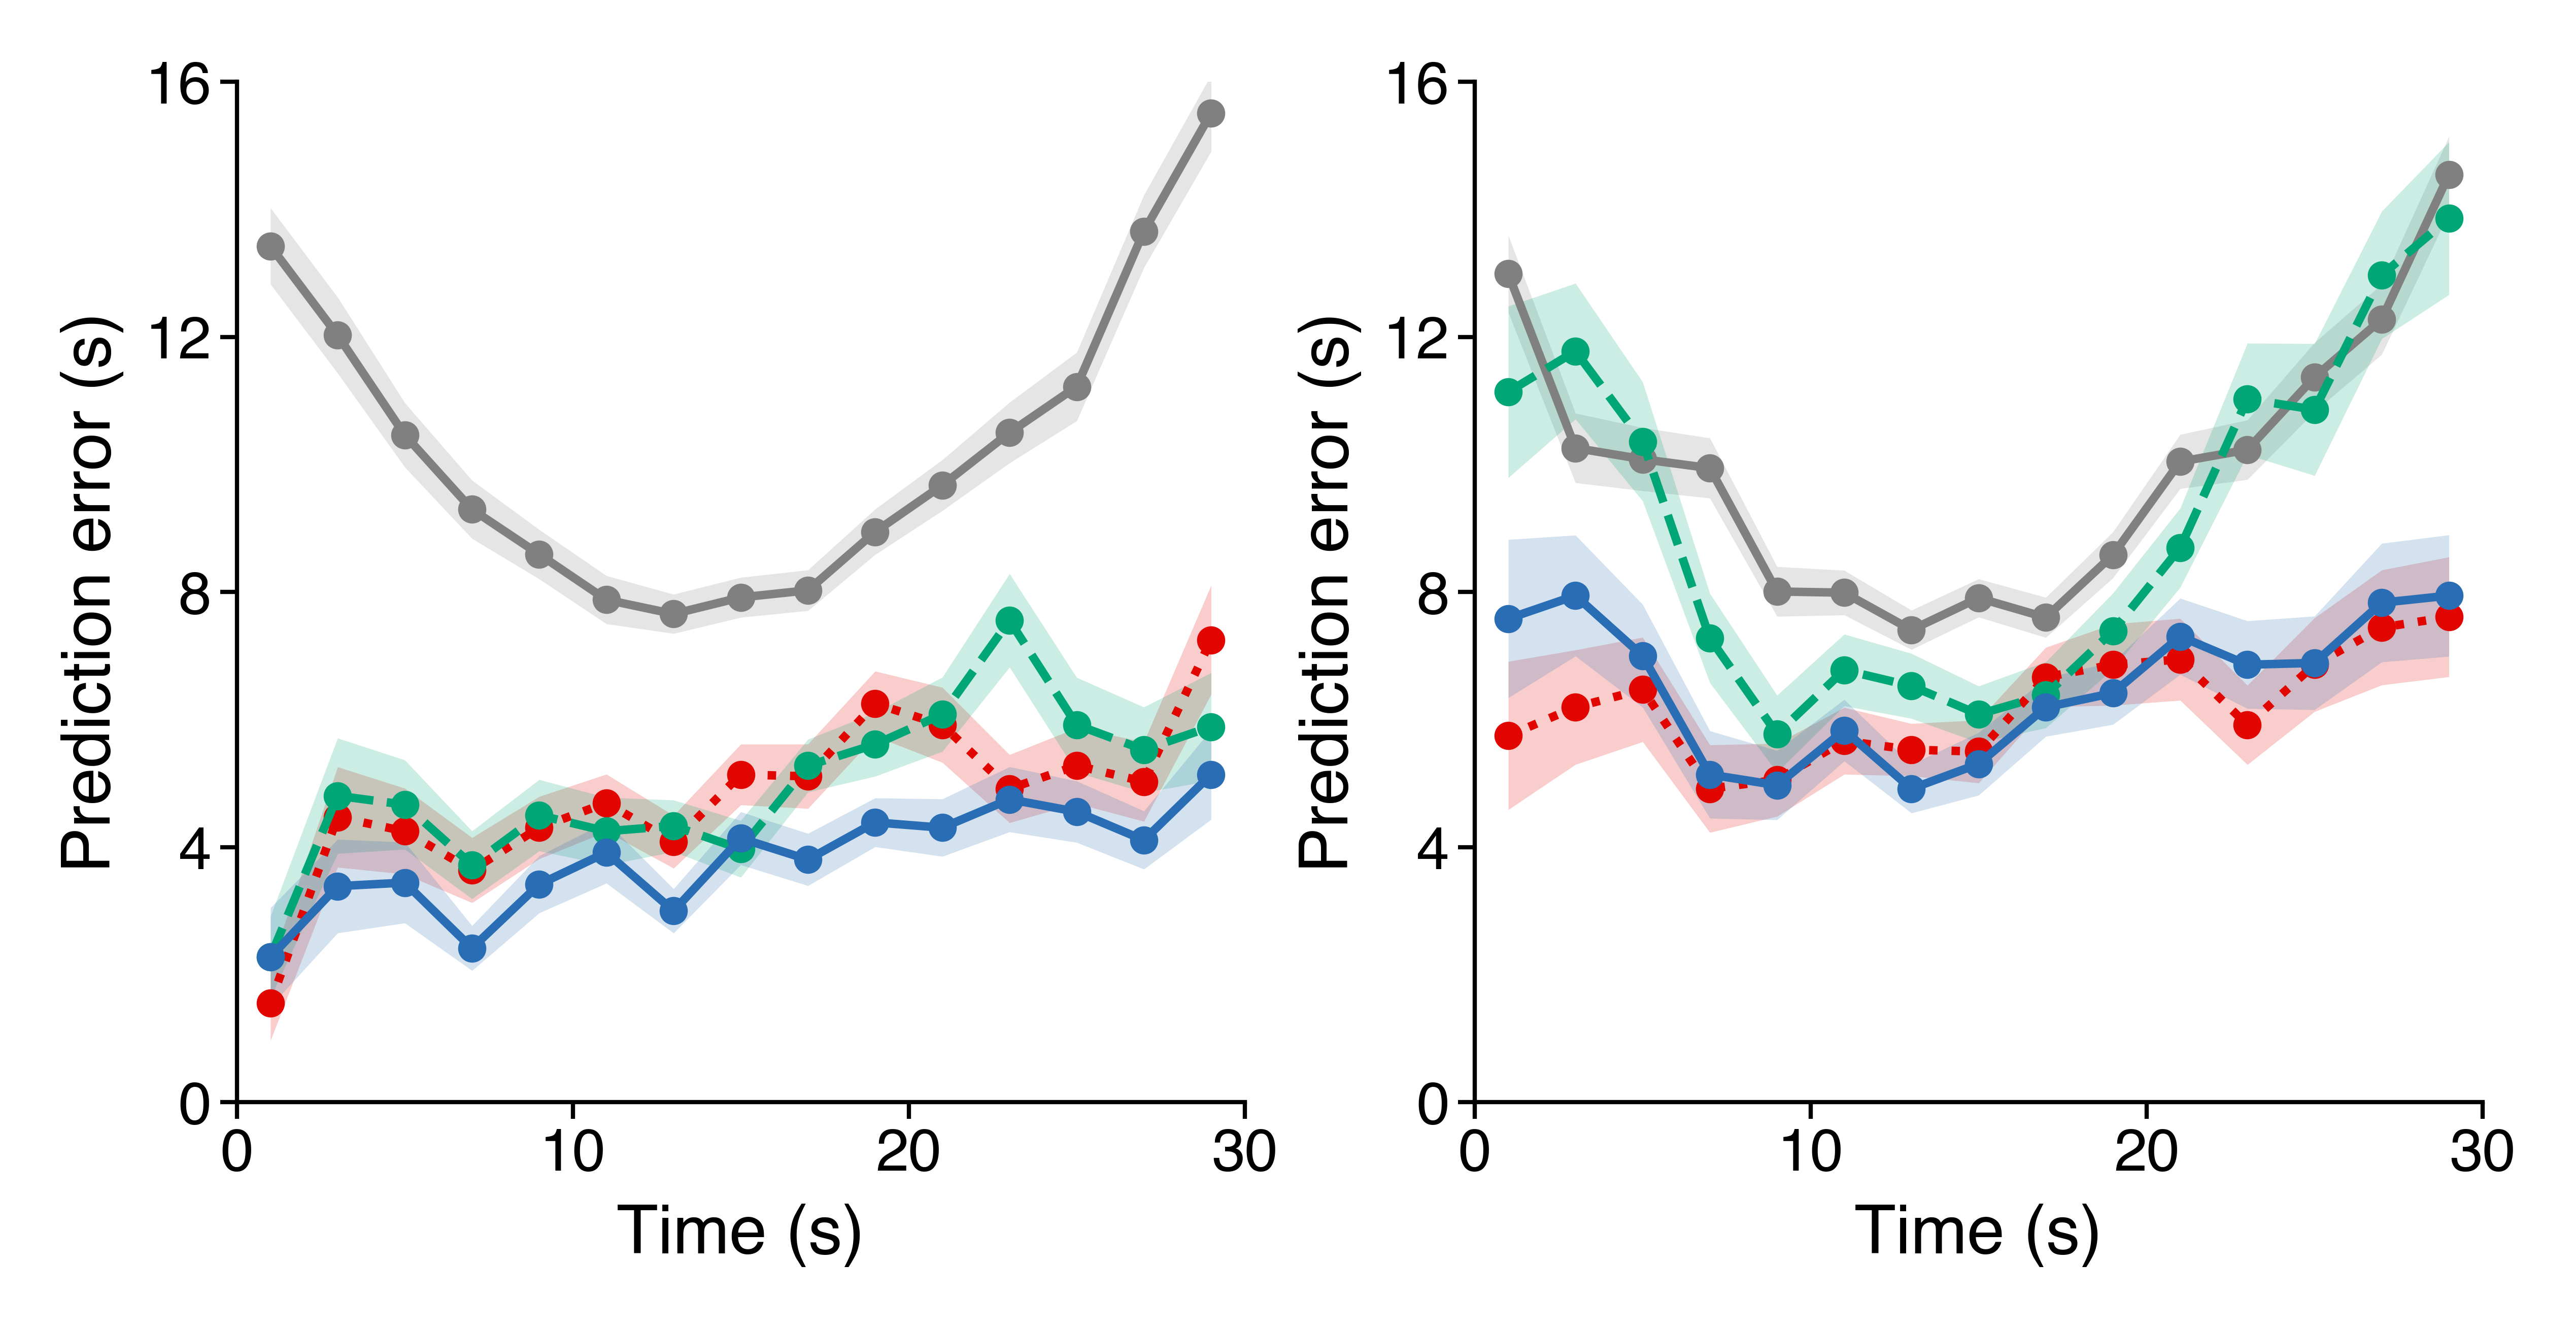

In [146]:
game_states = ['Encoding', 'Retrieval']
savefig = 1
overwrite = 0
if 'Delay' in game_states[0]:
    ymin_error_time = 0
    ymax_error_time = 5
    yticks_error_time = [0, 1, 2, 3, 4, 5]
else:
    ymin_error_time = 0
    ymax_error_time = 16
    yticks_error_time = [0, 4, 8, 12, 16]
figsize = (colws[1]*2, colws[1])
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
dpi = 1200
spine_lw = 0.5
spine_len = 2
tickpad = 1
labelpad = 2.5
alpha = 0.2
linewidth = 1
linestyles = {'timeNo': 'dotted',
              'timeAll': '--',
              'all': '-'}
# colors = {'null': '#808080',
#           'within': '#e10600',
#           'cross': '#296eb4'}
colors = {'null': '#808080',
          'timeNo': '#e10600',
          'timeAll': '#00A676',
          'all': '#296eb4'}

plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

iax = 0
_ax = ax[iax]
_clf_results = clf_results.query("(clf_cat=='within')")
means = np.mean(_clf_results['abs_error_null'].tolist(), axis=0)
sems = stats.sem(_clf_results['abs_error_null'].tolist(), axis=0)
xvals = np.arange(means.size)
_ax.fill_between(xvals, means + sems, means - sems,
                 color=colors['null'], linewidth=0, alpha=alpha)
_ax.plot(xvals, means, color=colors['null'], linewidth=linewidth,
         linestyle='-', marker='o', markersize=font['annot']/3)

for unit_group in ['timeNo', 'timeAll', 'all']:
    for clf_cat in ['within']:
        _clf_results = clf_results.query("(unit_group=='{}') & (clf_cat=='{}')".format(unit_group, clf_cat))
        means = np.mean(_clf_results['abs_error'].tolist(), axis=0)
        sems = stats.sem(_clf_results['abs_error'].tolist(), axis=0)
        xvals = np.arange(means.size)
        _ax.fill_between(xvals, means + sems, means - sems,
                         color=colors[unit_group], linewidth=0, alpha=alpha)
        _ax.plot(xvals, means,
                 color=colors[unit_group], linestyle=linestyles[unit_group],
                 linewidth=linewidth, marker='o', markersize=font['annot']/3)

iax = 1
_ax = ax[iax]
_clf_results = clf_results.query("(clf_cat=='cross')")
means = np.mean(_clf_results['abs_error_null'].tolist(), axis=0)
sems = stats.sem(_clf_results['abs_error_null'].tolist(), axis=0)
xvals = np.arange(means.size)
_ax.fill_between(xvals, means + sems, means - sems,
                 color=colors['null'], linewidth=0, alpha=alpha)
_ax.plot(xvals, means, color=colors['null'], linewidth=linewidth,
         linestyle='-', marker='o', markersize=font['annot']/3)

for unit_group in ['timeNo', 'timeAll', 'all']:
    for clf_cat in ['cross']:
        _clf_results = clf_results.query("(unit_group=='{}') & (clf_cat=='{}')".format(unit_group, clf_cat))
        means = np.mean(_clf_results['abs_error'].tolist(), axis=0)
        sems = stats.sem(_clf_results['abs_error'].tolist(), axis=0)
        xvals = np.arange(means.size)
        _ax.fill_between(xvals, means + sems, means - sems,
                         color=colors[unit_group], linewidth=0, alpha=alpha)
        _ax.plot(xvals, means,
                 color=colors[unit_group], linestyle=linestyles[unit_group],
                 linewidth=linewidth, marker='o', markersize=font['annot']/3)
        
# Plot params.
if 'Delay' in game_states[0]:
    xticks = np.linspace(0, gs_steps[game_states[0]], num=6)
    xticklabs = [0, 2, 4, 6, 8, 10]
else:
    xticks = np.linspace(0, gs_steps[game_states[0]], num=4)
    xticklabs = [0, 10, 20, 30]
for _ax in ax:
    for axis in ['left', 'bottom']:
        _ax.spines[axis].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
    _xticks = xticks - 0.5
    _ax.set_xlim([-0.5, xvals.size-0.5])
    _ax.set_xticks(_xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylim([ymin_error_time, ymax_error_time])
    _ax.set_yticks(yticks_error_time)
    _ax.set_yticklabels(yticks_error_time, fontsize=font['tick'])
    _ax.set_ylabel('Prediction error (s)', fontsize=font['label'], labelpad=labelpad)

fig.tight_layout(pad=0.25, h_pad=1)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-{}-random_search-36fold-{}_{}bins-{}_{}bins-pred_error_over_time.pdf'
                       .format('-'.join(['{}units_{}'.format(unit_groups[unit_group], unit_group) for unit_group in unit_groups]),
                               game_states[0], gs_steps[game_states[0]], game_states[1], gs_steps[game_states[1]]))
    if overwrite or not op.exists(filename):
        print('Saving {}'.format(op.basename(filename)))
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()

within max: 80.6
cross max: 41.7
Saving SVC_predicting_time_step-119units_timeAll-random_search-36fold-Encoding_15bins-Retrieval_15bins-confusion_mats.pdf


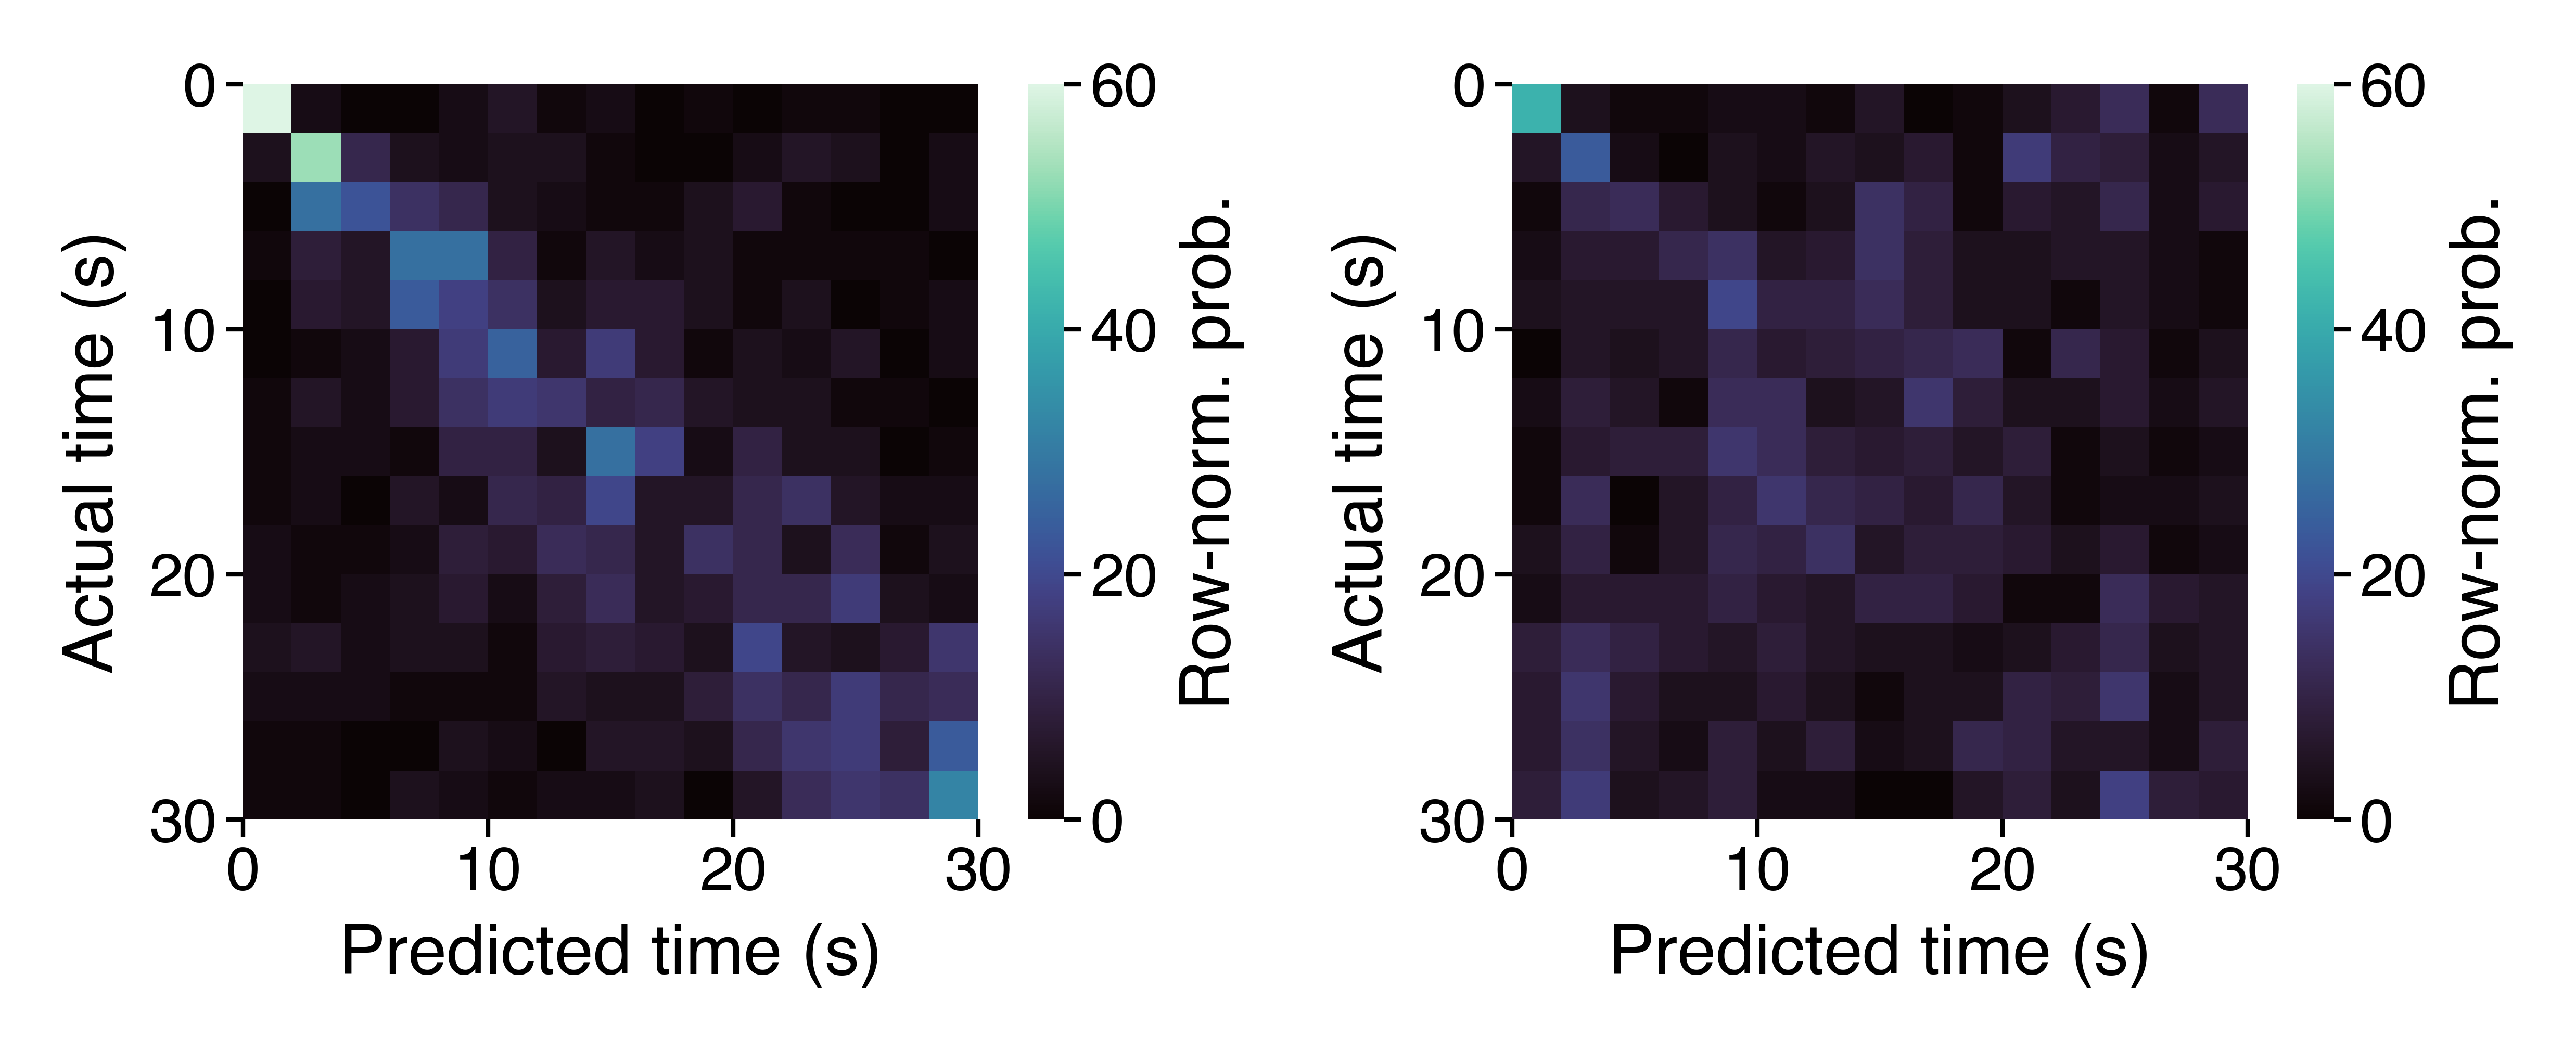

In [155]:
game_states = ['Encoding', 'Retrieval']
savefig = 1
overwrite = 0
figsize = (colws[1]*2, colws[1]*.75)
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
dpi = 1200
spine_lw = 0.5
spine_len = 2
tickpad = 1
labelpad = 2.5
cmap = 'mako'
vmin = 0
vmax = 60
add_cbar = True
cbar_ticks = [0, 20, 40, 60]
unit_group = 'timeAll'

# -----------------------
plt.close()
fig, ax = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for iax, clf_cat in enumerate(['within', 'cross']):
    _ax = ax[iax]
    _clf_results = clf_results.query("(unit_group=='{}') & (clf_cat=='{}')".format(unit_group, clf_cat))
    cmat = np.mean(_clf_results.apply(lambda x: confusion_matrix(
        x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
    print('{} max: {:.1f}'.format(clf_cat, cmat.max()))
    _ax = sns.heatmap(cmat, vmin=vmin, vmax=vmax, cmap=cmap, square=True, ax=_ax)
    
    
    # Plot params.
    if 'Delay' in game_states[0]:
        xticks = np.linspace(0, cmat.shape[0], num=6)
        xticklabels = [0, 2, 4, 6, 8, 10]
    else:
        xticks = np.linspace(0, cmat.shape[0], num=4)
        xticklabels = [0, 10, 20, 30]
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw, rotation=0)
    _xticks = xticks
    _ax.set_xlim((_xticks.min(), _xticks.max()))
    _ax.set_xticks(_xticks)
    _ax.set_xticklabels(xticklabels)
    _ax.set_yticks(_ax.get_xticks())
    _ax.set_yticklabels(_ax.get_xticklabels())
    _ax.set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
    if add_cbar:
        cbar = _ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticks)
        cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
    else:
        _ax.collections[0].colorbar.remove()

fig.tight_layout(pad=0.25, h_pad=1)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}bins-confusion_mats.pdf'
                       .format(unit_groups[unit_group], unit_group, game_states[0], gs_steps[game_states[0]],
                               game_states[1], gs_steps[game_states[1]]))
    if overwrite or not op.exists(filename):
        print('Saving {}'.format(op.basename(filename)))
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()

# Time across all trial events: all neurons, no time cells, no interval cells

In [191]:
# Load within- and cross-classifier results for all neurons,
# only time cells, and only non-time cells.
game_states = ['Encoding', 'Retrieval']
unit_groups = od([('all', 457),
                  ('minusTime', 256),
                  ('minusEvent', 284)])
n_bins = 40

# ---------------------
timer = Timer()
warnings.filterwarnings('ignore')
filestr = op.join(proj_dir, 'analysis', 'classifiers',
                  'SVC_predicting_iGameStateTime-{}-{}units-random_search-{}bins-36fold.pkl')

clf_results = []
for unit_group, n_units in unit_groups.items():
    filepath = filestr.format(unit_group, unit_groups[unit_group], n_bins)
    clf_results.append(dio.open_pickle(filepath))

    # Drop columns that we don't need.    
    drop_cols = ['mean_acc', 'acc_by_time', 'accuracy',
                 'mean_acc_null', 'acc_by_time_null', 'accuracy_null',
                 'best_trainval_score', 'best_trainval_C', 'best_trainval_gamma',
                 'best_trainval_score_null', 'best_trainval_C_null', 'best_trainval_gamma_null']
    _drop_cols = [col for col in drop_cols if col in clf_results[-1].columns]
    if len(_drop_cols) > 0:
        clf_results[-1].drop(columns=_drop_cols, inplace=True)

    # Add unique identifying columns.
    clf_results[-1].insert(0, 'unit_group', unit_group)
    clf_results[-1].insert(1, 'n_units', n_units)

    # Resort y_test_null and y_test_pred_null on the values within each y_test_null test trial.
    for col in ['y_test_pred_null', 'y_test_null']:
        clf_results[-1][col] = clf_results[-1].apply(lambda x: sort_onto(x['y_test_null'],
                                                                         x[col],
                                                                         len(x['test_trials'])),
                                                     axis=1)

    # Calculate performance metrics.
    err_mult = int(80 / n_bins)
    clf_results[-1]['recall'] = clf_results[-1].apply(
        lambda x: metrics.recall_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
    clf_results[-1]['precision'] = clf_results[-1].apply(
        lambda x: metrics.precision_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
    clf_results[-1]['f1'] = clf_results[-1].apply(
        lambda x: metrics.f1_score(x['y_test'], x['y_test_pred'], average=None).tolist(), axis=1)
    clf_results[-1]['error'] = clf_results[-1].apply(
        lambda x: clf_error(x['y_test'], x['y_test_pred'], err_mult), axis=1)
    clf_results[-1]['abs_error'] = clf_results[-1].apply(
        lambda x: np.abs(x['error']).tolist(), axis=1)
    clf_results[-1]['corr'] = clf_results[-1].apply(
        lambda x: stats.pearsonr(x['y_test_pred'], x['y_test'])[0], axis=1).fillna(0)
    clf_results[-1]['recall_null'] = clf_results[-1].apply(
        lambda x: metrics.recall_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
    clf_results[-1]['precision_null'] = clf_results[-1].apply(
        lambda x: metrics.precision_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
    clf_results[-1]['f1_null'] = clf_results[-1].apply(
        lambda x: metrics.f1_score(x['y_test_null'], x['y_test_pred_null'], average=None).tolist(), axis=1)
    clf_results[-1]['error_null'] = clf_results[-1].apply(
        lambda x: clf_error(x['y_test_null'], x['y_test_pred_null'], err_mult), axis=1)
    clf_results[-1]['abs_error_null'] = clf_results[-1].apply(
        lambda x: np.abs(x['error_null']).tolist(), axis=1)
    clf_results[-1]['corr_null'] = clf_results[-1].apply(
        lambda x: stats.pearsonr(x['y_test_pred_null'], x['y_test_null'])[0], axis=1).fillna(0)
        
clf_results = pd.concat(clf_results, axis=0).reset_index(drop=True)

warnings.resetwarnings()
print('clf_results: {}'.format(clf_results.shape))
print(timer)

clf_results: (108, 21)
Ran in 0.8s


In [192]:
clf_results.columns

Index(['unit_group', 'n_units', 'gameState', 'n_time_steps', 'test_trials',
       'y_test', 'y_test_pred', 'y_test_null', 'y_test_pred_null', 'recall',
       'precision', 'f1', 'error', 'abs_error', 'corr', 'recall_null',
       'precision_null', 'f1_null', 'error_null', 'abs_error_null',
       'corr_null'],
      dtype='object')

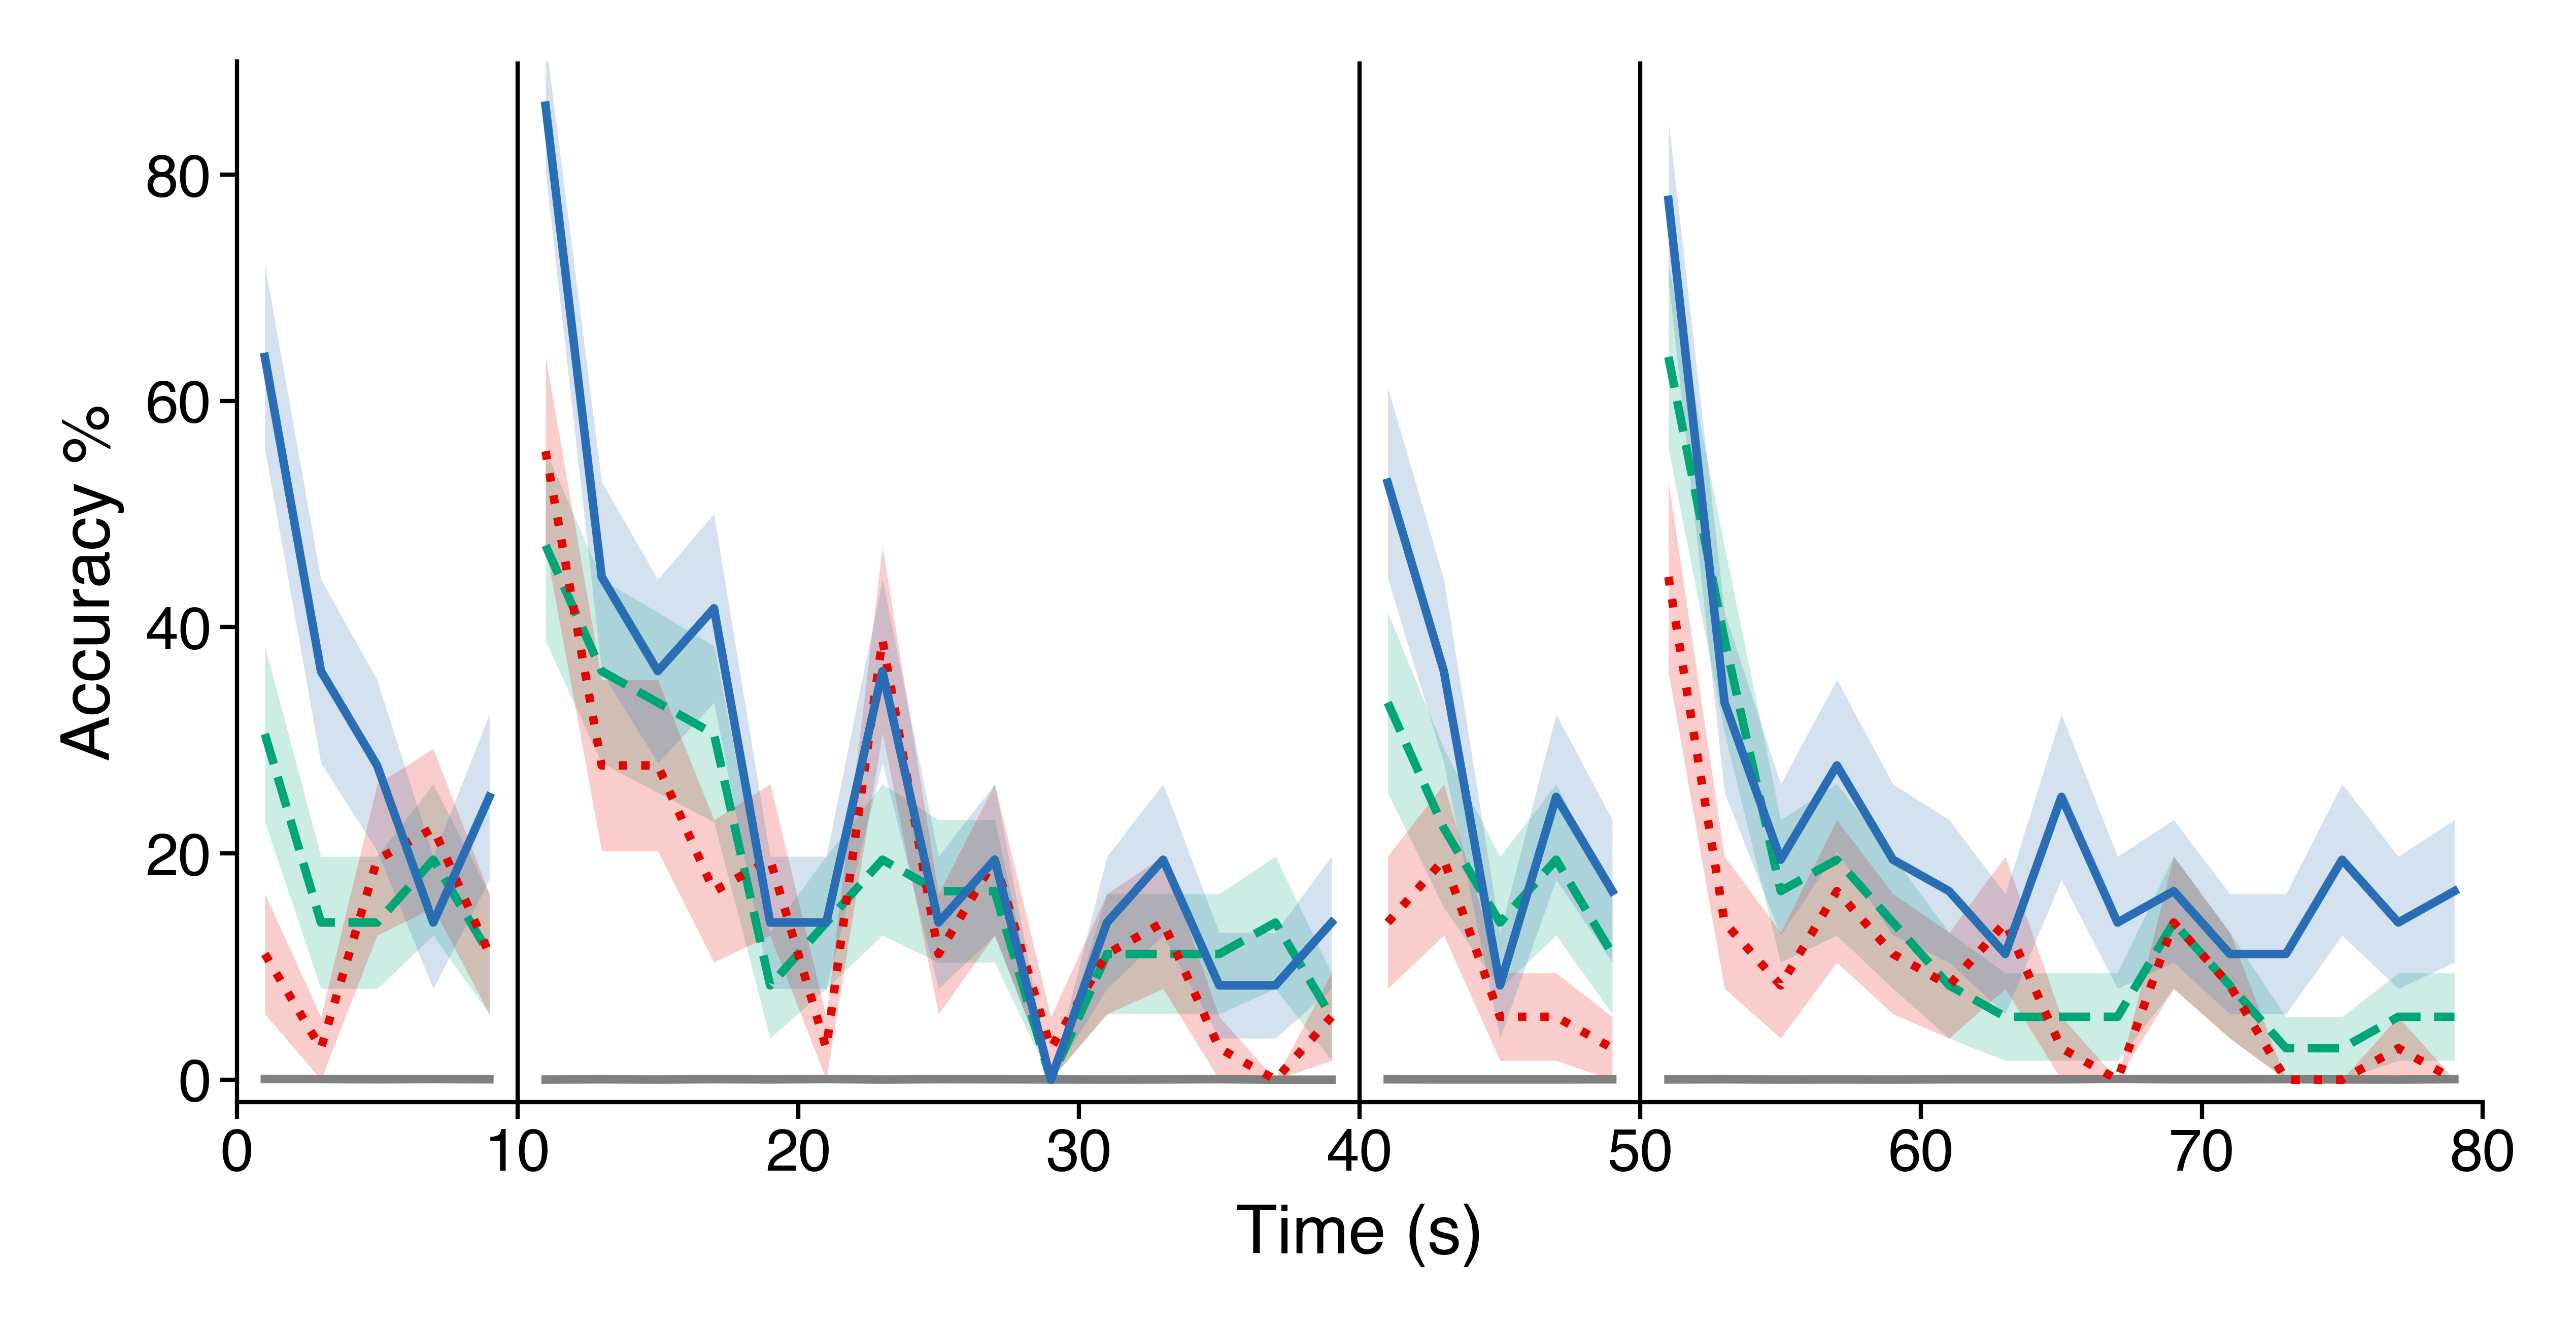

In [216]:
savefig = 0
overwrite = 0
xticks = np.linspace(0, n_bins, 9)
xticklabs = np.linspace(0, 80, 9).astype(int)
vlines = [0, 5, 20, 25, 40]
ymin_error_time = 0
ymax_error_time = 45
yticks_error_time = [0, 10, 20, 30, 40]
ymin_acc_time = -2
ymax_acc_time = 90
yticks_acc_time = [0, 20, 40, 60, 80]
figsize = (colws[1]*2, colws[1])
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
dpi = 1200
spine_lw = 0.5
spine_len = 2
tickpad = 1
labelpad = 2.5
alpha = 0.2
linewidth = 1
linestyles = {'minusTime': 'dotted',
              'minusEvent': '--',
              'all': '-'}
colors = {'null': '#808080',
          'minusTime': '#e10600',
          'minusEvent': '#00A676',
          'all': '#296eb4'}

plt.close()
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

# -----------------------------
# iax = 0
# _ax = ax[iax]
# _clf_results = clf_results
# means = np.mean(_clf_results['abs_error_null'].tolist(), axis=0)
# sems = stats.sem(_clf_results['abs_error_null'].tolist(), axis=0)
# xvals = np.arange(means.size)
# _ax.fill_between(xvals, means + sems, means - sems,
#                  color=colors['null'], linewidth=0, alpha=alpha)
# _ax.plot(xvals, means, color=colors['null'], linewidth=linewidth,
#          linestyle='-', marker='o', markersize=font['annot']/3)

# for unit_group in ['minusEvent', 'minusTime', 'all']:
#     _clf_results = clf_results.query("(unit_group=='{}')".format(unit_group))
#     means = np.mean(_clf_results['abs_error'].tolist(), axis=0)
#     sems = stats.sem(_clf_results['abs_error'].tolist(), axis=0)
#     xvals = np.arange(means.size)
#     _ax.fill_between(xvals, means + sems, means - sems,
#                      color=colors[unit_group], linewidth=0, alpha=alpha)
#     _ax.plot(xvals, means,
#              color=colors[unit_group], linestyle=linestyles[unit_group],
#              linewidth=linewidth, marker='o', markersize=font['annot']/3)
# _ax.set_ylim([ymin_error_time, ymax_error_time])
# _ax.set_yticks(yticks_error_time)
# _ax.set_yticklabels(yticks_error_time, fontsize=font['tick'])
# _ax.set_ylabel('Prediction error (s)', fontsize=font['label'], labelpad=labelpad)

# -----------------------------
iax = 0
_ax = ax[iax]
_clf_results = clf_results
means = np.mean(_clf_results['recall_null'].tolist(), axis=0)
sems = stats.sem(_clf_results['recall_null'].tolist(), axis=0)
xvals = np.arange(means.size) + 0.5
for ii in range(len(vlines)-1):
    if ii < (len(vlines)-2):
        _ax.axvline(vlines[ii+1], lw=spine_lw, color='k')
    start, stop = vlines[ii], vlines[ii+1]
    _ax.fill_between(xvals[start:stop],
                     means[start:stop] + sems[start:stop],
                     means[start:stop] - sems[start:stop],
                     color=colors['null'], linewidth=0, alpha=alpha)
    _ax.plot(xvals[start:stop], means[start:stop], color=colors['null'],
             linewidth=linewidth, linestyle='-', markersize=0)

for unit_group in ['minusEvent', 'minusTime', 'all']:
    _clf_results = clf_results.query("(unit_group=='{}')".format(unit_group))
    means = np.mean(_clf_results['recall'].tolist(), axis=0) * 100
    sems = stats.sem(_clf_results['recall'].tolist(), axis=0) * 100
    xvals = np.arange(means.size) + 0.5
    for ii in range(len(vlines)-1):
        start, stop = vlines[ii], vlines[ii+1]
        _ax.fill_between(xvals[start:stop],
                         means[start:stop] + sems[start:stop],
                         means[start:stop] - sems[start:stop],
                         color=colors[unit_group], linewidth=0, alpha=alpha)
        _ax.plot(xvals[start:stop], means[start:stop], color=colors[unit_group],
                 linewidth=linewidth, linestyle=linestyles[unit_group], markersize=0)
_ax.set_ylim([ymin_acc_time, ymax_acc_time])
_ax.set_yticks(yticks_acc_time)
_ax.set_yticklabels(yticks_acc_time, fontsize=font['tick'])
_ax.set_ylabel('Accuracy %', fontsize=font['label'], labelpad=labelpad)

# Plot params.    
for _ax in ax:
    for axis in ['left', 'bottom']:
        _ax.spines[axis].set_linewidth(spine_lw)
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
    _xticks = xticks# - 0.5
    _ax.set_xlim([0, xvals.size])
    _ax.set_xticks(_xticks)
    _ax.set_xticklabels(xticklabs)
    _ax.set_xlabel('Time (s)', fontsize=font['label'], labelpad=labelpad)

fig.tight_layout(pad=0.25, w_pad=1)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-{}-random_search-36fold-{}bins-pred_error_over_time.pdf'
                       .format('-'.join(['{}units_{}'.format(unit_groups[unit_group], unit_group) for unit_group in unit_groups]), n_bins))
    if overwrite or not op.exists(filename):
        print('Saving {}'.format(op.basename(filename)))
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()

minusTime max: 55.6
minusEvent max: 63.9
all max: 86.1


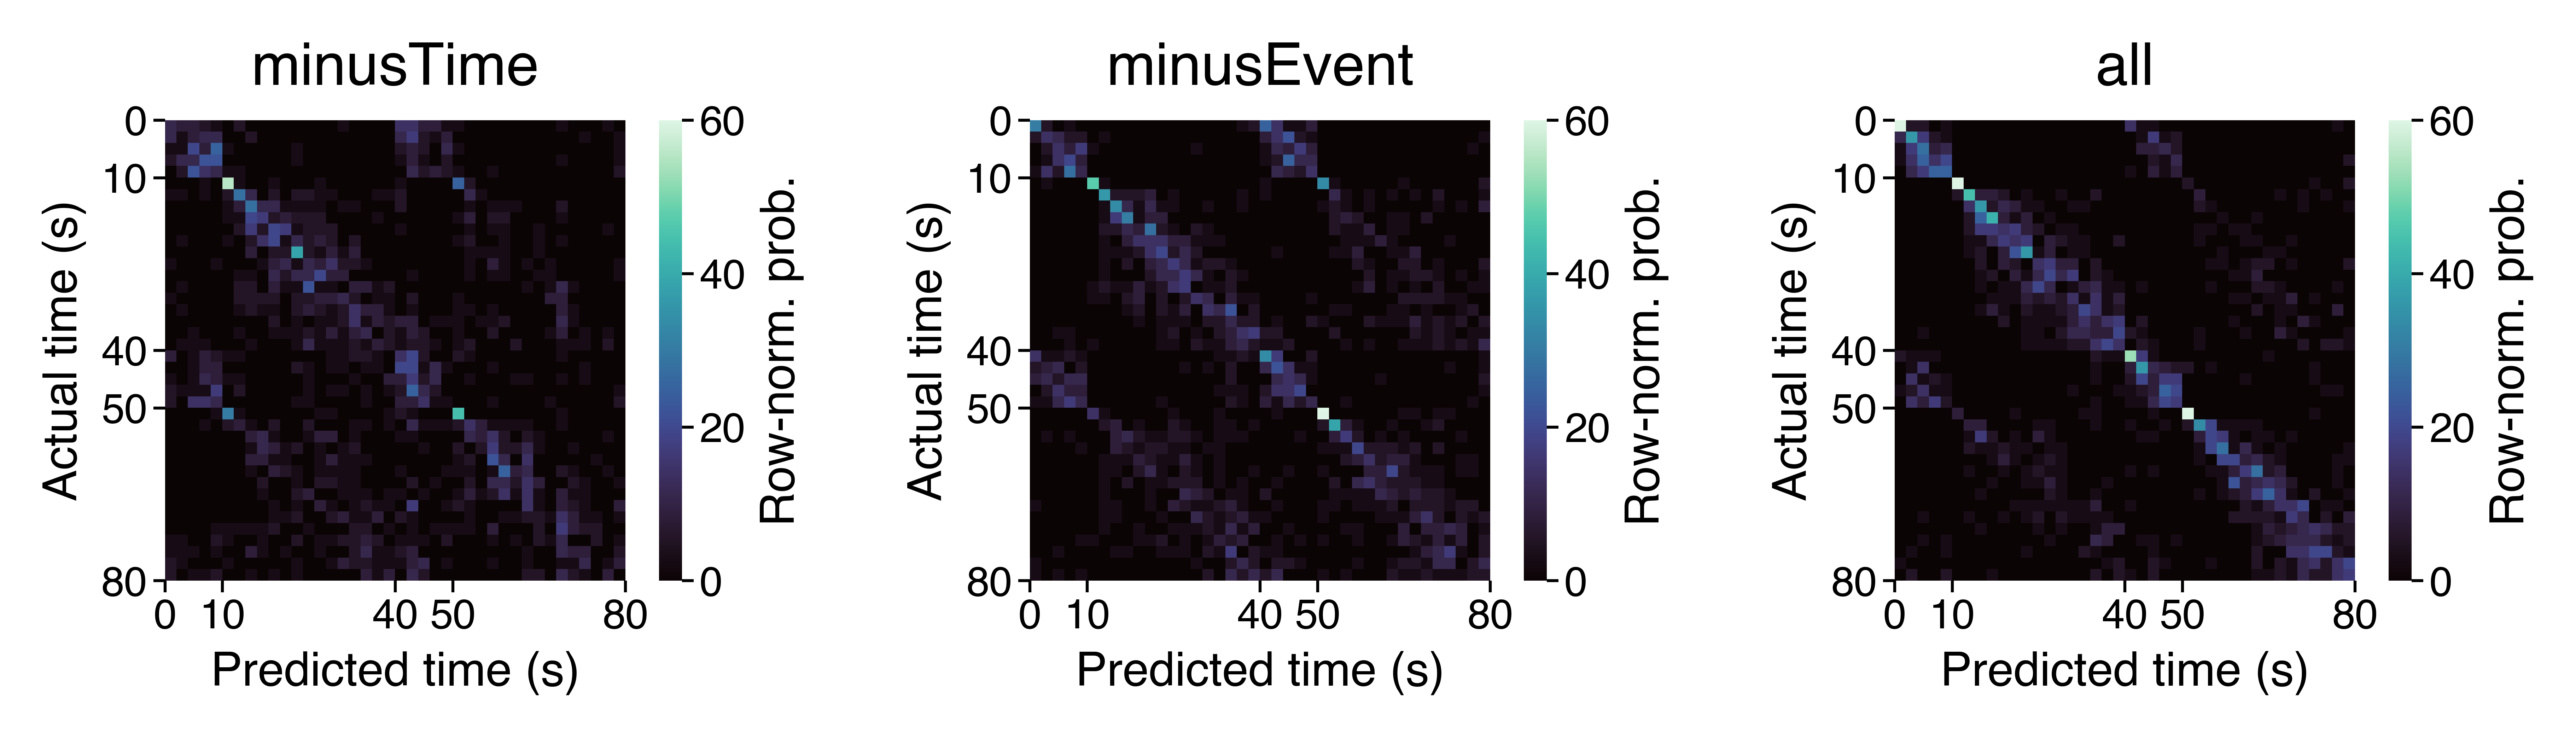

In [226]:
savefig = 0
overwrite = 0
figsize = (colws[1]*3, colws[1]*.75)
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
dpi = 1200
spine_lw = 0.5
spine_len = 2
tickpad = 1
labelpad = 2.5
cmap = 'mako'
vmin = 0
vmax = 60
add_cbar = True
cbar_ticks = [0, 20, 40, 60]
unit_groups = ['minusTime', 'minusEvent', 'all']

# -----------------------
plt.close()
fig, ax = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for iax, unit_group in enumerate(unit_groups):
    _ax = ax[iax]
    _clf_results = clf_results.query("(unit_group=='{}')".format(unit_group))
    cmat = np.mean(_clf_results.apply(lambda x: confusion_matrix(
        x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
    print('{} max: {:.1f}'.format(unit_group, cmat.max()))
    _ax = sns.heatmap(cmat, vmin=vmin, vmax=vmax, cmap=cmap, square=True, ax=_ax)
    
    # Plot params.
    xticks = np.array([0, 5, 20, 25, 40])
    xticklabels = np.array([0, 10, 40, 50, 80])
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw, rotation=0)
    _xticks = xticks
    _ax.set_xlim((_xticks.min(), _xticks.max()))
    _ax.set_xticks(_xticks)
    _ax.set_xticklabels(xticklabels)
    _ax.set_yticks(_ax.get_xticks())
    _ax.set_yticklabels(_ax.get_xticklabels())
    _ax.set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_title(unit_group, fontsize=font['fig'])
    if add_cbar:
        cbar = _ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticks)
        cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
    else:
        _ax.collections[0].colorbar.remove()

fig.tight_layout(pad=0.25)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}bins-confusion_mats.pdf'
                       .format(n_bins))
    if overwrite or not op.exists(filename):
        print('Saving {}'.format(op.basename(filename)))
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()

# Delay classifiers predicting navigation time

In [227]:
# Load within- and cross-classifier results for all neurons,
# only time cells, and only non-time cells.
game_states = ['Delay1', 'Delay2']
unit_groups = od([('all', 457)])
gs_steps = {'Delay1': 5, 'Delay2': 5, 'Encoding': 15, 'Retrieval': 15}

# ---------------------
timer = Timer()
warnings.filterwarnings('ignore')
fglobs = od([('within', op.join(proj_dir, 'analysis', 'classifiers',
                                'SVC_predicting_time_step-{}units_{}-random_search-36fold-{}_{}bins-{}_{}*bins.pkl')),
             ('cross', op.join(proj_dir, 'analysis', 'classifiers',
    'SVC_predicting_time_step-457units_all-random_search-36fold-delay_to_nav_cross_decoding-Delay1_5bins-Delay2_5bins-Encoding_15bins-Retrieval_15bins.pkl'))])

clf_results = []
for unit_group, n_units in unit_groups.items():
    for clf_cat, fglob in fglobs.items():
        fpath = fglob.format(n_units, unit_group, game_states[0], gs_steps[game_states[0]], game_states[1], gs_steps[game_states[1]])
        glob_res = glob(fpath)
        assert len(glob_res) == 1
        clf_results.append(dio.open_pickle(glob_res[0]))
        
        # Drop columns that we don't need.
        drop_cols = ['unit_group', 'mean_acc', 'acc_by_time', 'accuracy', 'clf',
                     'mean_acc_null', 'acc_by_time_null', 'accuracy_null', 'clf_null',
                     'best_trainval_score', 'best_trainval_C', 'best_trainval_gamma',
                     'best_trainval_score_null', 'best_trainval_C_null', 'best_trainval_gamma_null']
        _drop_cols = [col for col in drop_cols if col in clf_results[-1].columns]
        if len(_drop_cols) > 0:
            clf_results[-1].drop(columns=_drop_cols, inplace=True)
        
        # Align gameState column naming across dataframes.
        if clf_cat == 'within':
            clf_results[-1].rename(columns={'gameState': 'gameState_train'}, inplace=True)
            clf_results[-1].insert(clf_results[-1].columns.tolist().index('gameState_train') + 1,
                                   'gameState_test',
                                   clf_results[-1]['gameState_train'])
        
        # Restrict rows to game states of interest.
        clf_results[-1] = clf_results[-1].query("(gameState_train=={})".format(game_states))
        
        # Add unique identifying columns.
        clf_results[-1].insert(0, 'unit_group', unit_group)
        clf_results[-1].insert(1, 'n_units', n_units)
        clf_results[-1].insert(2, 'clf_cat', clf_cat)
        
        # Resort y_test_null and y_test_pred_null on the values within each y_test_null test trial.
        for col in ['y_test_pred_null', 'y_test_null']:
            clf_results[-1][col] = clf_results[-1].apply(lambda x: sort_onto(x['y_test_null'],
                                                                             x[col],
                                                                             len(x['test_trials'])),
                                                         axis=1)
        
        # Calculate performance metrics.
        if gs_steps[game_states[0]] in (5, 15):
            err_mult = 2
        else:
            err_mult = 1
        clf_results[-1]['recall'] = clf_results[-1].apply(
            lambda x: metrics.recall_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
        clf_results[-1]['precision'] = clf_results[-1].apply(
            lambda x: metrics.precision_score(x['y_test'], x['y_test_pred'], average=None), axis=1)
        clf_results[-1]['f1'] = clf_results[-1].apply(
            lambda x: metrics.f1_score(x['y_test'], x['y_test_pred'], average=None).tolist(), axis=1)
        clf_results[-1]['error'] = clf_results[-1].apply(
            lambda x: clf_error(x['y_test'], x['y_test_pred'], err_mult), axis=1)
        clf_results[-1]['abs_error'] = clf_results[-1].apply(
            lambda x: np.abs(x['error']).tolist(), axis=1)
        clf_results[-1]['corr'] = clf_results[-1].apply(
            lambda x: stats.pearsonr(x['y_test_pred'], x['y_test'])[0], axis=1).fillna(0)
        clf_results[-1]['recall_null'] = clf_results[-1].apply(
            lambda x: metrics.recall_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
        clf_results[-1]['precision_null'] = clf_results[-1].apply(
            lambda x: metrics.precision_score(x['y_test_null'], x['y_test_pred_null'], average=None), axis=1)
        clf_results[-1]['f1_null'] = clf_results[-1].apply(
            lambda x: metrics.f1_score(x['y_test_null'], x['y_test_pred_null'], average=None).tolist(), axis=1)
        clf_results[-1]['error_null'] = clf_results[-1].apply(
            lambda x: clf_error(x['y_test_null'], x['y_test_pred_null'], err_mult), axis=1)
        clf_results[-1]['abs_error_null'] = clf_results[-1].apply(
            lambda x: np.abs(x['error_null']).tolist(), axis=1)
        clf_results[-1]['corr_null'] = clf_results[-1].apply(
            lambda x: stats.pearsonr(x['y_test_pred_null'], x['y_test_null'])[0], axis=1).fillna(0)
        
clf_results = pd.concat(clf_results, axis=0).reset_index(drop=True)

warnings.resetwarnings()
print('clf_results: {}'.format(clf_results.shape))
print(timer)

clf_results: (504, 24)
Ran in 4.8s


In [240]:
clf_results.query("(clf_cat=='cross')").groupby(['alignment']).size()

alignment
first10     144
last10      144
relative    144
dtype: int64

first10 max: 48.6
last10 max: 47.9
relative max: 63.9
Saving SVC_predicting_time_step-457units_all-random_search-36fold-5bins-delay_to_nav-confusion_mats.pdf


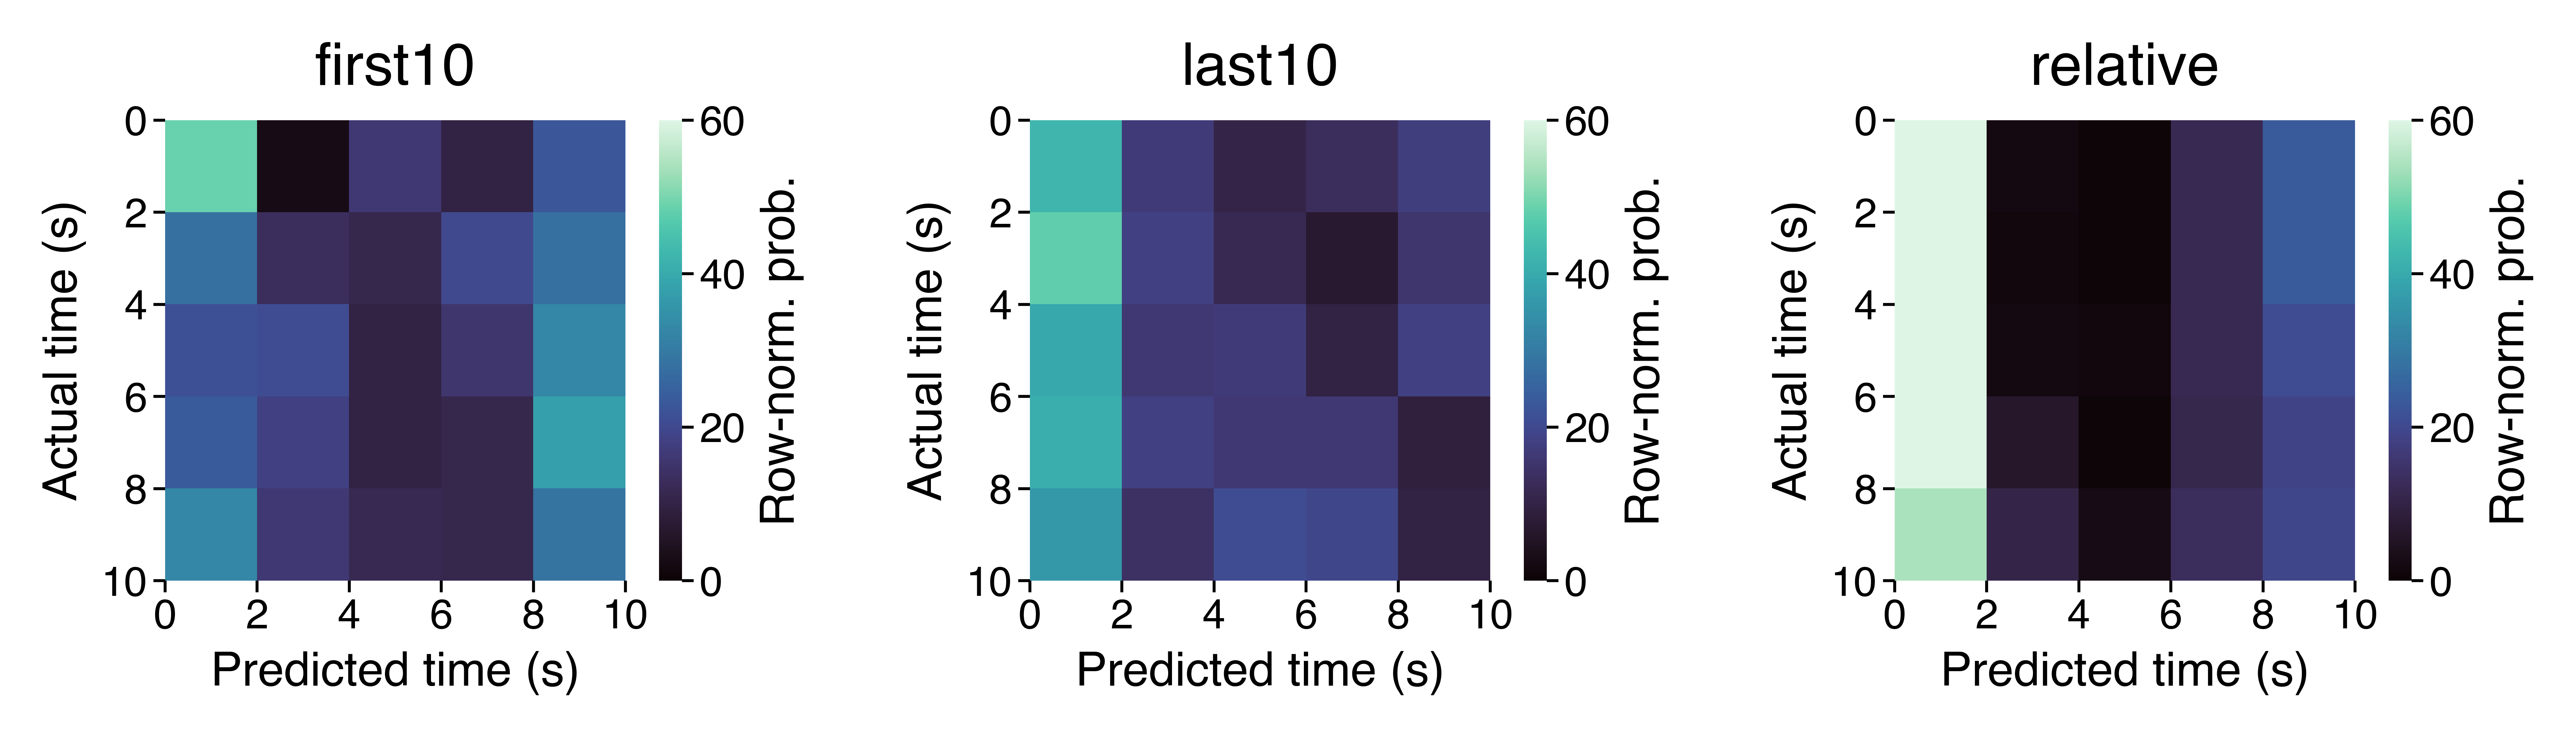

In [247]:
savefig = 1
overwrite = 0
figsize = (colws[1]*3, colws[1]*.75)
font = {'tick': 7, 'label': 8, 'fig': 10, 'annot': 7}
dpi = 1200
spine_lw = 0.5
spine_len = 2
tickpad = 1
labelpad = 2.5
cmap = 'mako'
vmin = 0
vmax = 60
add_cbar = True
cbar_ticks = [0, 20, 40, 60]
alignments = ['first10', 'last10', 'relative']

# -----------------------
plt.close()
fig, ax = plt.subplots(1, 3, figsize=figsize, dpi=dpi)
ax = np.ravel(ax)

for iax, alignment in enumerate(alignments):
    _ax = ax[iax]
    _clf_results = clf_results.query("(clf_cat=='cross') & (alignment=='{}')".format(alignment))
    cmat = np.mean(_clf_results.apply(lambda x: confusion_matrix(
        x['y_test'], x['y_test_pred'], normalize='true'), axis=1).tolist(), axis=0) * 100
    print('{} max: {:.1f}'.format(alignment, cmat.max()))
    _ax = sns.heatmap(cmat, vmin=vmin, vmax=vmax, cmap=cmap, square=True, ax=_ax)
    
    # Plot params.
    n_time_steps = _clf_results.iloc[0]['n_time_steps']
    xticks = np.linspace(0, n_time_steps, num=6)
    xticklabels = [0, 2, 4, 6, 8, 10]
    yticks = np.linspace(0, n_time_steps, num=6)
    if alignment == 'first10':
        yticklabels = [0, 2, 4, 6, 8, 10]
    elif alignment == 'last10':
        yticklabels = [20, 22, 24, 26, 28, 30]
    else:
        yticklabels = [0, 6, 12, 18, 24, 30]
    _ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw, rotation=0)
    _xticks = xticks
    _ax.set_xlim((_xticks.min(), _xticks.max()))
    _ax.set_xticks(_xticks)
    _ax.set_xticklabels(xticklabels)
    _ax.set_yticks(_ax.get_xticks())
    _ax.set_yticklabels(_ax.get_xticklabels())
    _ax.set_xlabel('Predicted time (s)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_ylabel('Actual time (s)', fontsize=font['label'], labelpad=labelpad)
    _ax.set_title(alignment, fontsize=font['fig'])
    if add_cbar:
        cbar = _ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=font['tick'], pad=tickpad, length=spine_len, width=spine_lw)
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels(cbar_ticks)
        cbar.set_label('Row-norm. prob.', fontsize=font['label'], labelpad=labelpad)
    else:
        _ax.collections[0].colorbar.remove()

fig.tight_layout(pad=0.25)

if savefig:
    filename = op.join(proj_dir, 'figs', 'classifiers',
                       'SVC_predicting_time_step-457units_all-random_search-36fold-5bins-delay_to_nav-confusion_mats.pdf')
    if overwrite or not op.exists(filename):
        print('Saving {}'.format(op.basename(filename)))
        fig.savefig(filename, format='pdf', bbox_inches='tight', pad_inches=0)
        fig.savefig(filename.replace('pdf', 'png'), format='png', dpi=dpi, bbox_inches='tight', pad_inches=0)

fig.show()